In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
print("pytorch ver . ",torch.__version__)
print("Is CUDA available?",torch.cuda.is_available())
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.utils.data as Data
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import math

/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pytorch ver .  1.11.0+cu113
Is CUDA available? True


# Data

In [2]:
data=pd.read_csv('/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/data_final.csv')
data

,SITE_ID,date,FCST_TIME,TAU,pm25_cal,pm25_obs
0,EPA001,2020-02-24 08:00:00,2020-02-24 09:00:00,1,4.9510,10.0
1,EPA001,2020-02-24 08:00:00,2020-02-24 10:00:00,2,4.4674,13.0
2,EPA001,2020-02-24 08:00:00,2020-02-24 11:00:00,3,4.6159,11.0
3,EPA001,2020-02-24 08:00:00,2020-02-24 12:00:00,4,3.9937,11.0
4,EPA001,2020-02-24 08:00:00,2020-02-24 13:00:00,5,3.9602,9.0
...,...,...,...,...,...,...
3092755,EPA080,2021-10-30 08:00:00,2021-11-02 04:00:00,68,3.6190,4.0
3092756,EPA080,2021-10-30 08:00:00,2021-11-02 05:00:00,69,3.7908,7.0
3092757,EPA080,2021-10-30 08:00:00,2021-11-02 06:00:00,70,4.0454,7.0
3092758,EPA080,2021-10-30 08:00:00,2021-11-02 07:00:00,71,3.9015,4.0


In [3]:
x1=np.zeros([604,1704])
x2=np.zeros([604,5112])

#x1 (0th~1703th column as x)
for i in range (0,604):
    for j in range (0,71):
        a=np.array(data['pm25_obs'][5112*i+72*j:5112*i+72*j+24])
        for k in range (0,24):
            x1[i][j*24+k]=a[k]

#x2 (1704th~8519th column as x)
for i in range (1,604):
    b=np.array(data['pm25_cal'][5112*i:5112*i+5112])
    for j in range(0,5112):
        x2[i-1][j]=b[j]
        
print(np.shape(x1))
print(np.shape(x2))

(604, 1704)
(604, 5112)


In [4]:
x1Restruct_Fun=x1
x2Restruct_Fun=x2
print(np.shape(x1Restruct_Fun))
print(np.shape(x2Restruct_Fun))

(604, 1704)
(604, 5112)


In [5]:
YRestruct_Fun=np.zeros([601,5112])
for j in range (0,71):
    for i in range(0,601):
        YRestruct_Fun[i][72*j:72*j+24]=x1Restruct_Fun[1+i][24*j:24*j+24]
        YRestruct_Fun[i][72*j+24:72*j+48]=x1Restruct_Fun[1+i+1][24*j:24*j+24]
        YRestruct_Fun[i][72*j+48:72*j+72]=x1Restruct_Fun[1+i+2][24*j:24*j+24]
print(np.shape(YRestruct_Fun))

(601, 5112)


In [6]:
XRestruct_Fun=np.zeros([601,6816])
for i in range (0,601):
    for j in range (0,1704):
        XRestruct_Fun[i][j]=x1Restruct_Fun[i][j]
    for j in range (1704,6816):
        XRestruct_Fun[i][j]=x2Restruct_Fun[i][j-1704]
print(np.shape(XRestruct_Fun))

(601, 6816)


In [7]:
Xhat=XRestruct_Fun
Yhat=YRestruct_Fun
Xhat_train = np.zeros([540,6816])
Yhat_train = np.zeros([540,5112])
Xhat_val = np.zeros([61,6816])
Yhat_val = np.zeros([61,5112])
Xhat_test = np.zeros([61,6816])
Yhat_test = np.zeros([61,5112])

for i in range (0,540):
    for j in range (0,1704):
        Xhat_train[i][j] = Xhat[i][j]
    for j in range (0,5112):    
        Xhat_train[i][j+1704] = Xhat[i][j+1704]
        Yhat_train[i][j] = Yhat[i][j]
        
for i in range (540,601):
    for j in range (0,1704):
        Xhat_val[i-540][j] = Xhat[i][j]
    for j in range (0,5112):
        Xhat_val[i-540][j+1704] = Xhat[i][j+1704]
        Yhat_val[i-540][j] = Yhat[i][j]     
        
for i in range (540,601):
    for j in range (0,1704):
        Xhat_test[i-540][j] = Xhat[i][j]
    for j in range (0,5112):
        Xhat_test[i-540][j+1704] = Xhat[i][j+1704]
        Yhat_test[i-540][j] = Yhat[i][j]
        
print('Xhat_train')
print(np.shape(Xhat_train))
print('Yhat_train')
print(np.shape(Yhat_train))
print('Xhat_val')
print(np.shape(Xhat_val))
print('Yhat_val')
print(np.shape(Yhat_val))
print('Xhat_test')
print(np.shape(Xhat_test))
print('Yhat_test')
print(np.shape(Yhat_test))

Xhat_train
(540, 6816)
Yhat_train
(540, 5112)
Xhat_val
(61, 6816)
Yhat_val
(61, 5112)
Xhat_test
(61, 6816)
Yhat_test
(61, 5112)


In [8]:
Xhat_train_n = np.zeros([71,540,96])
Yhat_train_n = np.zeros([71,540,72])
Xhat_test_n = np.zeros([71,61,96])
Yhat_test_n = np.zeros([71,61,72])
for i in range (0,71):
    for j in range (0,540):
        for k in range (0,24):
            Xhat_train_n[i][j][k] = Xhat_train[j][24*i+k]
        for k in range (0,72):
            Xhat_train_n[i][j][k+24] = Xhat_train[j][1704+(72*i)+k]
            Yhat_train_n[i][j][k] = Yhat_train[j][(72*i)+k]
    for j in range (0,61):
        for k in range (0,24):
            Xhat_test_n[i][j][k] = Xhat_test[j][24*i+k]
        for k in range (0,72):
            Xhat_test_n[i][j][k+24] = Xhat_test[j][1704+(72*i)+k]
            Yhat_test_n[i][j][k] = Yhat_test[j][(72*i)+k]
print('Xhat_train')
print(np.shape(Xhat_train_n))
print('Yhat_train')
print(np.shape(Yhat_train_n))
print('Xhat_test')
print(np.shape(Xhat_test_n))
print('Yhat_test')
print(np.shape(Yhat_test_n))
Xhat_val_n=Xhat_test_n
Yhat_val_n=Yhat_test_n
print('Xhat_val')
print(np.shape(Xhat_val_n))
print('Yhat_val')
print(np.shape(Yhat_val_n))

Xhat_train
(71, 540, 96)
Yhat_train
(71, 540, 72)
Xhat_test
(71, 61, 96)
Yhat_test
(71, 61, 72)
Xhat_val
(71, 61, 96)
Yhat_val
(71, 61, 72)


In [9]:
Xhat_train_n0 = np.zeros([71, 540, 168])
Xhat_val_n0 = np.zeros([71, 61, 168])
Xhat_test_n0 = np.zeros([71, 61, 168])
for k in range(0,71):
    for i in range (0,540):
        for j in range (0,96):
            Xhat_train_n0[k][i][j] = Xhat_train_n[k][i][j]
        for j in range (96,168):
            Xhat_train_n0[k][i][j] = Yhat_train_n[k][i][j-96]
for k in range(0,71):
    for i in range (0,61):
        for j in range (0,96):
            Xhat_val_n0[k][i][j] = Xhat_val_n[k][i][j]
        for j in range (96,168):
            Xhat_val_n0[k][i][j] = Yhat_val_n[k][i][j-96]
for k in range(0,71):
    for i in range (0,61):
        for j in range (0,96):
            Xhat_test_n0[k][i][j] = Xhat_test_n[k][i][j]
        for j in range (96,168):
            Xhat_test_n0[k][i][j] = Yhat_test_n[k][i][j-96]
print('Xhat_train')
print(np.shape(Xhat_train_n0))
print('Yhat_train')
print(np.shape(Yhat_train_n))
print('Xhat_test')
print(np.shape(Xhat_test_n0))
print('Yhat_test')
print(np.shape(Yhat_test_n))
print('Xhat_val')
print(np.shape(Xhat_val_n0))
print('Yhat_val')
print(np.shape(Yhat_val_n))

Xhat_train
(71, 540, 168)
Yhat_train
(71, 540, 72)
Xhat_test
(71, 61, 168)
Yhat_test
(71, 61, 72)
Xhat_val
(71, 61, 168)
Yhat_val
(71, 61, 72)


# Modeling

In [37]:
x_train = torch.from_numpy(Xhat_train_n0[36]).float()
y_train = torch.from_numpy(Yhat_train_n[36]).float()
x_test = torch.from_numpy(Xhat_test_n0[36]).float()
y_test = torch.from_numpy(Yhat_test_n[36]).float()
x_val = torch.from_numpy(Xhat_val_n0[36]).float()
y_val = torch.from_numpy(Yhat_val_n[36]).float()

In [10]:
class PytorchLightningModel(pl.LightningModule): # 一定要繼承pl.LightningModule
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(96,72)
        self.layer2 = nn.Transformer(d_model=72, nhead=72)
    
    def forward(self, x):
        ouput = self.layer1(x[:,:96])
        ouput = self.layer2(ouput, x[:,96:]) 
        return ouput

    def configure_optimizers(self): # 自動訓練時會呼叫此方法來獲取Optimizer.
        return optim.Adam(self.parameters(), lr=1e-1) # 這邊注意要調整的參數是`self.parameters()`

    def prepare_data(self): # 此方法會在初始化後優先執行。 所以可以在此方法中先將會用到的資料都讀取進來.
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    # 以下三個方法則是設定進行訓練及驗證時所要使用的Data Loader格式。
    def train_dataloader(self):
        # return Data.DataLoader(dataset=self.train_set, batch_size= self.batch_size, shuffle=True)
        return Data.DataLoader(dataset=self.train_set , batch_size=540 , shuffle=True)

    def test_dataloader(self):
        # return Data.DataLoader(dataset=self.test_set, batch_size= self.batch_size, shuffle=True)
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        #return Data.DataLoader(dataset=self.val_set, batch_size= self.batch_size, shuffle=True)
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

#----------------------------------------------------------------------------------------------------------------------------------------------

    def training_step(self, batch, batch_idx): # 定義訓練過程的Step要如何進行
        x, y = batch # 從self.train_dataloader()的Data Loader取一個batch出來。
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        logs = {'loss' : loss }
        self.log("train_loss_MAE", loss)
        return {'loss' : loss ,'log' : logs }

    def test_step(self, batch, batch_idx): #定義 Test 階段
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        logs = {'loss' : loss }
        self.log("test_loss_MAE", loss)
        return {'loss' : loss ,'log' : logs}

    # def test_eposh_end(self, outputs):
    #     avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
    #     logs = {'test_loss': avg_loss}      
    #     #return {'avg_test_loss': avg_loss, 'log': logs, 'progress_bar': logs }
    #     return {'avg_test_loss': avg_loss, 'log': logs}

    def validation_step(self, batch, batch_idx): # 定義Validation如何進行，以這邊為例就再加上了計算Acc.
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        logs = {'loss' : loss }
        self.log("val_loss_MAE", loss)
        return {'loss' : loss ,  'log' : logs}
    
    # def validation_epoch_end(self, outputs): # 在Validation的一個Epoch結束後，計算平均的Loss.
    #     avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
    #     logs = {'val_loss': avg_loss}
    #     return {'avg_val_loss': avg_loss, 'log' : logs, 'progress_bar': logs}

In [44]:
logger1 = TensorBoardLogger("jupyterNB_logs", name="Transformer")
logger2 = CSVLogger("jupyterNB_logs", name="Transformer_csv")
model = PytorchLightningModel() 
trainer = pl.Trainer(max_epochs=1500 , gpus=1 , logger=logger1)
trainer.fit(model)
trainer.test(model)
trainer.test(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | layer1 | Linear      | 7.0 K 
1 | layer2 | Transformer | 3.9 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.818    Total estimated model params size (MB)


Epoch 0:  50%|███████▌       | 1/2 [00:00<00:00, 16.21it/s, loss=18.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|███████▌       | 1/2 [00:00<00:00,  4.36it/s, loss=18.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|███████▌       | 1/2 [00:00<00:00,  2.50it/s, loss=18.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|████████▌        | 1/2 [00:00<00:00,  1.76it/s, loss=18, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|████████▌        | 1/2 [00:00<00:00,  1.32it/s, loss=18, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|████████▌        | 1/2 [00:00<00:00,  1.08it/s, loss=18, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|████████▌        | 1/2 [00:01<00:01,  1.10s/it, loss=18, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|████████▌        | 1/2 [00:01<00:01,  1.27s/it, loss=18, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|████████▌        | 1/2 [00:01<00:01,  1.44s/it, loss=18, v_num=11]
Validation: 0it [00:00,

Epoch 57:  50%|███████       | 1/2 [00:09<00:09,  9.83s/it, loss=17.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 58:  50%|███████       | 1/2 [00:10<00:10, 10.01s/it, loss=17.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 59:  50%|███████       | 1/2 [00:10<00:10, 10.19s/it, loss=17.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 60:  50%|███████       | 1/2 [00:10<00:10, 10.38s/it, loss=17.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 61:  50%|███████       | 1/2 [00:10<00:10, 10.55s/it, loss=17.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 62:  50%|███████       | 1/2 [00:10<00:10, 10.72s/it, loss=17.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 63:  50%|███████       | 1/2 [00:10<00:10, 10.89s/it, loss=17.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 64:  50%|███████       | 1/2 [00:11<00:11, 11.07s/it, loss=17.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 65:  50%|████████        | 1/2 [00:11<00:11, 11.23s/it, loss=17, v_num=11]
Validation: 0it [00:00,

Epoch 114:  50%|██████▌      | 1/2 [00:19<00:19, 19.64s/it, loss=16.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 115:  50%|██████▌      | 1/2 [00:19<00:19, 19.81s/it, loss=16.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 116:  50%|██████▌      | 1/2 [00:19<00:19, 19.97s/it, loss=16.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 117:  50%|██████▌      | 1/2 [00:20<00:20, 20.13s/it, loss=16.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 118:  50%|███████▌       | 1/2 [00:20<00:20, 20.29s/it, loss=16, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 119:  50%|███████▌       | 1/2 [00:20<00:20, 20.45s/it, loss=16, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 120:  50%|███████▌       | 1/2 [00:20<00:20, 20.62s/it, loss=16, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 121:  50%|███████▌       | 1/2 [00:20<00:20, 20.78s/it, loss=16, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 122:  50%|███████▌       | 1/2 [00:20<00:20, 20.95s/it, loss=16, v_num=11]
Validation: 0it [00:00,

Epoch 171:  50%|██████▌      | 1/2 [00:29<00:29, 29.05s/it, loss=15.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 172:  50%|██████▌      | 1/2 [00:29<00:29, 29.21s/it, loss=15.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 173:  50%|██████▌      | 1/2 [00:29<00:29, 29.38s/it, loss=15.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 174:  50%|██████▌      | 1/2 [00:29<00:29, 29.54s/it, loss=15.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 175:  50%|██████▌      | 1/2 [00:29<00:29, 29.71s/it, loss=15.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 176:  50%|██████▌      | 1/2 [00:29<00:29, 29.88s/it, loss=15.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 177:  50%|██████▌      | 1/2 [00:30<00:30, 30.05s/it, loss=15.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 178:  50%|██████▌      | 1/2 [00:30<00:30, 30.22s/it, loss=15.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 179:  50%|███████▌       | 1/2 [00:30<00:30, 30.38s/it, loss=15, v_num=11]
Validation: 0it [00:00,

Epoch 228:  50%|██████▌      | 1/2 [00:38<00:38, 38.48s/it, loss=14.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 229:  50%|██████▌      | 1/2 [00:38<00:38, 38.64s/it, loss=14.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 230:  50%|██████▌      | 1/2 [00:38<00:38, 38.80s/it, loss=14.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 231:  50%|██████▌      | 1/2 [00:38<00:38, 38.97s/it, loss=14.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 232:  50%|██████▌      | 1/2 [00:39<00:39, 39.13s/it, loss=14.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 233:  50%|██████▌      | 1/2 [00:39<00:39, 39.30s/it, loss=14.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 234:  50%|██████▌      | 1/2 [00:39<00:39, 39.46s/it, loss=14.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 235:  50%|██████▌      | 1/2 [00:39<00:39, 39.62s/it, loss=14.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 236:  50%|██████▌      | 1/2 [00:39<00:39, 39.79s/it, loss=14.2, v_num=11]
Validation: 0it [00:00,

Epoch 285:  50%|██████▌      | 1/2 [00:47<00:47, 47.94s/it, loss=13.5, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 286:  50%|██████▌      | 1/2 [00:48<00:48, 48.10s/it, loss=13.5, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 287:  50%|██████▌      | 1/2 [00:48<00:48, 48.26s/it, loss=13.5, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 288:  50%|██████▌      | 1/2 [00:48<00:48, 48.43s/it, loss=13.5, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 289:  50%|██████▌      | 1/2 [00:48<00:48, 48.60s/it, loss=13.5, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 290:  50%|██████▌      | 1/2 [00:48<00:48, 48.76s/it, loss=13.5, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 291:  50%|██████▌      | 1/2 [00:48<00:48, 48.93s/it, loss=13.5, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 292:  50%|██████▌      | 1/2 [00:49<00:49, 49.09s/it, loss=13.5, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 293:  50%|██████▌      | 1/2 [00:49<00:49, 49.25s/it, loss=13.5, v_num=11]
Validation: 0it [00:00,

Epoch 342:  50%|██████▌      | 1/2 [00:57<00:57, 57.41s/it, loss=12.9, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 343:  50%|██████▌      | 1/2 [00:57<00:57, 57.57s/it, loss=12.9, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 344:  50%|██████▌      | 1/2 [00:57<00:57, 57.74s/it, loss=12.9, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 345:  50%|██████▌      | 1/2 [00:57<00:57, 57.91s/it, loss=12.9, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 346:  50%|██████▌      | 1/2 [00:58<00:58, 58.08s/it, loss=12.9, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 347:  50%|██████▌      | 1/2 [00:58<00:58, 58.25s/it, loss=12.9, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 348:  50%|██████▌      | 1/2 [00:58<00:58, 58.42s/it, loss=12.8, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 349:  50%|██████▌      | 1/2 [00:58<00:58, 58.59s/it, loss=12.8, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 350:  50%|██████▌      | 1/2 [00:58<00:58, 58.76s/it, loss=12.8, v_num=11]
Validation: 0it [00:00,

Epoch 399:  50%|██████▌      | 1/2 [01:06<01:06, 66.91s/it, loss=12.4, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 400:  50%|██████▌      | 1/2 [01:07<01:07, 67.07s/it, loss=12.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 401:  50%|██████▌      | 1/2 [01:07<01:07, 67.23s/it, loss=12.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 402:  50%|██████▌      | 1/2 [01:07<01:07, 67.40s/it, loss=12.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 403:  50%|██████▌      | 1/2 [01:07<01:07, 67.56s/it, loss=12.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 404:  50%|██████▌      | 1/2 [01:07<01:07, 67.73s/it, loss=12.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 405:  50%|██████▌      | 1/2 [01:07<01:07, 67.89s/it, loss=12.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 406:  50%|██████▌      | 1/2 [01:08<01:08, 68.06s/it, loss=12.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 407:  50%|██████▌      | 1/2 [01:08<01:08, 68.22s/it, loss=12.3, v_num=11]
Validation: 0it [00:00,

Epoch 456:  50%|██████▌      | 1/2 [01:16<01:16, 76.37s/it, loss=11.9, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 457:  50%|██████▌      | 1/2 [01:16<01:16, 76.54s/it, loss=11.9, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 458:  50%|██████▌      | 1/2 [01:16<01:16, 76.70s/it, loss=11.9, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 459:  50%|██████▌      | 1/2 [01:16<01:16, 76.88s/it, loss=11.9, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 460:  50%|██████▌      | 1/2 [01:17<01:17, 77.04s/it, loss=11.9, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 461:  50%|██████▌      | 1/2 [01:17<01:17, 77.20s/it, loss=11.9, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 462:  50%|██████▌      | 1/2 [01:17<01:17, 77.37s/it, loss=11.9, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 463:  50%|██████▌      | 1/2 [01:17<01:17, 77.53s/it, loss=11.9, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 464:  50%|██████▌      | 1/2 [01:17<01:17, 77.69s/it, loss=11.9, v_num=11]
Validation: 0it [00:00,

Epoch 513:  50%|██████▌      | 1/2 [01:25<01:25, 85.84s/it, loss=11.5, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 514:  50%|██████▌      | 1/2 [01:26<01:26, 86.01s/it, loss=11.5, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 515:  50%|██████▌      | 1/2 [01:26<01:26, 86.18s/it, loss=11.5, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 516:  50%|██████▌      | 1/2 [01:26<01:26, 86.34s/it, loss=11.5, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 517:  50%|██████▌      | 1/2 [01:26<01:26, 86.51s/it, loss=11.5, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 518:  50%|██████▌      | 1/2 [01:26<01:26, 86.67s/it, loss=11.5, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 519:  50%|██████▌      | 1/2 [01:26<01:26, 86.83s/it, loss=11.5, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 520:  50%|██████▌      | 1/2 [01:26<01:26, 87.00s/it, loss=11.5, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 521:  50%|██████▌      | 1/2 [01:27<01:27, 87.16s/it, loss=11.5, v_num=11]
Validation: 0it [00:00,

Epoch 570:  50%|██████▌      | 1/2 [01:35<01:35, 95.24s/it, loss=11.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 571:  50%|██████▌      | 1/2 [01:35<01:35, 95.41s/it, loss=11.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 572:  50%|██████▌      | 1/2 [01:35<01:35, 95.57s/it, loss=11.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 573:  50%|██████▌      | 1/2 [01:35<01:35, 95.74s/it, loss=11.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 574:  50%|██████▌      | 1/2 [01:35<01:35, 95.90s/it, loss=11.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 575:  50%|██████▌      | 1/2 [01:36<01:36, 96.07s/it, loss=11.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 576:  50%|██████▌      | 1/2 [01:36<01:36, 96.23s/it, loss=11.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 577:  50%|██████▌      | 1/2 [01:36<01:36, 96.40s/it, loss=11.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 578:  50%|██████▌      | 1/2 [01:36<01:36, 96.56s/it, loss=11.2, v_num=11]
Validation: 0it [00:00,

Epoch 627:  50%|███████       | 1/2 [01:44<01:44, 104.67s/it, loss=11, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 628:  50%|███████       | 1/2 [01:44<01:44, 104.83s/it, loss=11, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 629:  50%|███████       | 1/2 [01:44<01:44, 105.00s/it, loss=11, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 630:  50%|███████       | 1/2 [01:45<01:45, 105.16s/it, loss=11, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 631:  50%|███████       | 1/2 [01:45<01:45, 105.32s/it, loss=11, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 632:  50%|███████       | 1/2 [01:45<01:45, 105.49s/it, loss=11, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 633:  50%|███████       | 1/2 [01:45<01:45, 105.65s/it, loss=11, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 634:  50%|███████       | 1/2 [01:45<01:45, 105.82s/it, loss=11, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 635:  50%|███████       | 1/2 [01:45<01:45, 105.99s/it, loss=11, v_num=11]
Validation: 0it [00:00,

Epoch 684:  50%|██████      | 1/2 [01:54<01:54, 114.07s/it, loss=10.8, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 685:  50%|██████      | 1/2 [01:54<01:54, 114.23s/it, loss=10.8, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 686:  50%|██████      | 1/2 [01:54<01:54, 114.45s/it, loss=10.8, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 687:  50%|██████      | 1/2 [01:54<01:54, 114.61s/it, loss=10.8, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 688:  50%|██████      | 1/2 [01:54<01:54, 114.78s/it, loss=10.8, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 689:  50%|██████      | 1/2 [01:54<01:54, 114.94s/it, loss=10.8, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 690:  50%|██████      | 1/2 [01:55<01:55, 115.10s/it, loss=10.8, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 691:  50%|██████      | 1/2 [01:55<01:55, 115.27s/it, loss=10.8, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 692:  50%|██████      | 1/2 [01:55<01:55, 115.43s/it, loss=10.8, v_num=11]
Validation: 0it [00:00,

Epoch 741:  50%|██████      | 1/2 [02:03<02:03, 123.52s/it, loss=10.6, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 742:  50%|██████      | 1/2 [02:03<02:03, 123.69s/it, loss=10.6, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 743:  50%|██████      | 1/2 [02:03<02:03, 123.85s/it, loss=10.6, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 744:  50%|██████      | 1/2 [02:04<02:04, 124.01s/it, loss=10.6, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 745:  50%|██████      | 1/2 [02:04<02:04, 124.18s/it, loss=10.6, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 746:  50%|██████      | 1/2 [02:04<02:04, 124.39s/it, loss=10.6, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 747:  50%|██████      | 1/2 [02:04<02:04, 124.55s/it, loss=10.6, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 748:  50%|██████      | 1/2 [02:04<02:04, 124.71s/it, loss=10.6, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 749:  50%|██████      | 1/2 [02:04<02:04, 124.87s/it, loss=10.6, v_num=11]
Validation: 0it [00:00,

Epoch 798:  50%|██████      | 1/2 [02:13<02:13, 133.10s/it, loss=10.5, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 799:  50%|██████      | 1/2 [02:13<02:13, 133.26s/it, loss=10.5, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 800:  50%|██████      | 1/2 [02:13<02:13, 133.42s/it, loss=10.5, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 801:  50%|██████      | 1/2 [02:13<02:13, 133.59s/it, loss=10.5, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 802:  50%|██████      | 1/2 [02:13<02:13, 133.75s/it, loss=10.5, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 803:  50%|██████      | 1/2 [02:13<02:13, 133.92s/it, loss=10.5, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 804:  50%|██████      | 1/2 [02:14<02:14, 134.08s/it, loss=10.5, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 805:  50%|██████      | 1/2 [02:14<02:14, 134.25s/it, loss=10.5, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 806:  50%|██████      | 1/2 [02:14<02:14, 134.46s/it, loss=10.5, v_num=11]
Validation: 0it [00:00,

Epoch 855:  50%|██████      | 1/2 [02:22<02:22, 142.52s/it, loss=10.4, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 856:  50%|██████      | 1/2 [02:22<02:22, 142.68s/it, loss=10.4, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 857:  50%|██████      | 1/2 [02:22<02:22, 142.85s/it, loss=10.4, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 858:  50%|██████      | 1/2 [02:23<02:23, 143.02s/it, loss=10.4, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 859:  50%|██████      | 1/2 [02:23<02:23, 143.18s/it, loss=10.4, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 860:  50%|██████      | 1/2 [02:23<02:23, 143.34s/it, loss=10.4, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 861:  50%|██████      | 1/2 [02:23<02:23, 143.51s/it, loss=10.4, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 862:  50%|██████      | 1/2 [02:23<02:23, 143.67s/it, loss=10.4, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 863:  50%|██████      | 1/2 [02:23<02:23, 143.84s/it, loss=10.4, v_num=11]
Validation: 0it [00:00,

Epoch 912:  50%|██████      | 1/2 [02:31<02:31, 151.94s/it, loss=10.4, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 913:  50%|██████      | 1/2 [02:32<02:32, 152.11s/it, loss=10.4, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 914:  50%|██████      | 1/2 [02:32<02:32, 152.27s/it, loss=10.4, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 915:  50%|██████      | 1/2 [02:32<02:32, 152.44s/it, loss=10.4, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 916:  50%|██████      | 1/2 [02:32<02:32, 152.60s/it, loss=10.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 917:  50%|██████      | 1/2 [02:32<02:32, 152.76s/it, loss=10.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 918:  50%|██████      | 1/2 [02:32<02:32, 152.93s/it, loss=10.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 919:  50%|██████      | 1/2 [02:33<02:33, 153.09s/it, loss=10.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 920:  50%|██████      | 1/2 [02:33<02:33, 153.25s/it, loss=10.3, v_num=11]
Validation: 0it [00:00,

Epoch 969:  50%|██████      | 1/2 [02:41<02:41, 161.39s/it, loss=10.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 970:  50%|██████      | 1/2 [02:41<02:41, 161.55s/it, loss=10.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 971:  50%|██████      | 1/2 [02:41<02:41, 161.71s/it, loss=10.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 972:  50%|██████      | 1/2 [02:41<02:41, 161.87s/it, loss=10.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 973:  50%|██████      | 1/2 [02:42<02:42, 162.04s/it, loss=10.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 974:  50%|██████      | 1/2 [02:42<02:42, 162.20s/it, loss=10.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 975:  50%|██████      | 1/2 [02:42<02:42, 162.37s/it, loss=10.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 976:  50%|██████      | 1/2 [02:42<02:42, 162.55s/it, loss=10.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 977:  50%|██████      | 1/2 [02:42<02:42, 162.72s/it, loss=10.3, v_num=11]
Validation: 0it [00:00,

Epoch 1026:  50%|█████▌     | 1/2 [02:50<02:50, 170.95s/it, loss=10.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1027:  50%|█████▌     | 1/2 [02:51<02:51, 171.12s/it, loss=10.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1028:  50%|█████▌     | 1/2 [02:51<02:51, 171.28s/it, loss=10.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1029:  50%|█████▌     | 1/2 [02:51<02:51, 171.45s/it, loss=10.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1030:  50%|█████▌     | 1/2 [02:51<02:51, 171.62s/it, loss=10.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1031:  50%|█████▌     | 1/2 [02:51<02:51, 171.78s/it, loss=10.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1032:  50%|█████▌     | 1/2 [02:51<02:51, 171.95s/it, loss=10.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1033:  50%|█████▌     | 1/2 [02:52<02:52, 172.13s/it, loss=10.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1034:  50%|█████▌     | 1/2 [02:52<02:52, 172.30s/it, loss=10.2, v_num=11]
Validation: 0it [00:00,

Epoch 1083:  50%|█████▌     | 1/2 [03:00<03:00, 180.51s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1084:  50%|█████▌     | 1/2 [03:00<03:00, 180.68s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1085:  50%|█████▌     | 1/2 [03:00<03:00, 180.84s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1086:  50%|█████▌     | 1/2 [03:01<03:01, 181.01s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1087:  50%|█████▌     | 1/2 [03:01<03:01, 181.17s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1088:  50%|█████▌     | 1/2 [03:01<03:01, 181.33s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1089:  50%|█████▌     | 1/2 [03:01<03:01, 181.50s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1090:  50%|█████▌     | 1/2 [03:01<03:01, 181.66s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1091:  50%|█████▌     | 1/2 [03:01<03:01, 181.83s/it, loss=10.2, v_num=11]
Validation: 0it [00:00,

Epoch 1140:  50%|█████▌     | 1/2 [03:10<03:10, 190.10s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1141:  50%|█████▌     | 1/2 [03:10<03:10, 190.28s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1142:  50%|█████▌     | 1/2 [03:10<03:10, 190.46s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1143:  50%|█████▌     | 1/2 [03:10<03:10, 190.63s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1144:  50%|█████▌     | 1/2 [03:10<03:10, 190.79s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1145:  50%|█████▌     | 1/2 [03:10<03:10, 190.96s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1146:  50%|█████▌     | 1/2 [03:11<03:11, 191.13s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1147:  50%|█████▌     | 1/2 [03:11<03:11, 191.31s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1148:  50%|█████▌     | 1/2 [03:11<03:11, 191.48s/it, loss=10.2, v_num=11]
Validation: 0it [00:00,

Epoch 1197:  50%|█████▌     | 1/2 [03:19<03:19, 199.75s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1198:  50%|█████▌     | 1/2 [03:19<03:19, 199.91s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1199:  50%|█████▌     | 1/2 [03:20<03:20, 200.08s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1200:  50%|█████▌     | 1/2 [03:20<03:20, 200.25s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1201:  50%|█████▌     | 1/2 [03:20<03:20, 200.41s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1202:  50%|█████▌     | 1/2 [03:20<03:20, 200.57s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1203:  50%|█████▌     | 1/2 [03:20<03:20, 200.73s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1204:  50%|█████▌     | 1/2 [03:20<03:20, 200.89s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1205:  50%|█████▌     | 1/2 [03:21<03:21, 201.06s/it, loss=10.2, v_num=11]
Validation: 0it [00:00,

Epoch 1254:  50%|█████▌     | 1/2 [03:29<03:29, 209.39s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1255:  50%|█████▌     | 1/2 [03:29<03:29, 209.57s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1256:  50%|█████▌     | 1/2 [03:29<03:29, 209.74s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1257:  50%|█████▌     | 1/2 [03:29<03:29, 209.91s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1258:  50%|█████▌     | 1/2 [03:30<03:30, 210.07s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1259:  50%|█████▌     | 1/2 [03:30<03:30, 210.25s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1260:  50%|█████▌     | 1/2 [03:30<03:30, 210.43s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1261:  50%|█████▌     | 1/2 [03:30<03:30, 210.60s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1262:  50%|█████▌     | 1/2 [03:30<03:30, 210.77s/it, loss=10.2, v_num=11]
Validation: 0it [00:00,

Epoch 1311:  50%|█████▌     | 1/2 [03:39<03:39, 219.07s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1312:  50%|█████▌     | 1/2 [03:39<03:39, 219.24s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1313:  50%|█████▌     | 1/2 [03:39<03:39, 219.41s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1314:  50%|█████▌     | 1/2 [03:39<03:39, 219.59s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1315:  50%|█████▌     | 1/2 [03:39<03:39, 219.77s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1316:  50%|█████▌     | 1/2 [03:39<03:39, 219.93s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1317:  50%|█████▌     | 1/2 [03:40<03:40, 220.10s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1318:  50%|█████▌     | 1/2 [03:40<03:40, 220.26s/it, loss=10.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1319:  50%|█████▌     | 1/2 [03:40<03:40, 220.43s/it, loss=10.2, v_num=11]
Validation: 0it [00:00,

Epoch 1368:  50%|█████▌     | 1/2 [03:48<03:48, 228.67s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1369:  50%|█████▌     | 1/2 [03:48<03:48, 228.84s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1370:  50%|█████▌     | 1/2 [03:49<03:49, 229.00s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1371:  50%|█████▌     | 1/2 [03:49<03:49, 229.17s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1372:  50%|█████▌     | 1/2 [03:49<03:49, 229.34s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1373:  50%|█████▌     | 1/2 [03:49<03:49, 229.51s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1374:  50%|█████▌     | 1/2 [03:49<03:49, 229.68s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1375:  50%|█████▌     | 1/2 [03:49<03:49, 229.84s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1376:  50%|█████▌     | 1/2 [03:50<03:50, 230.00s/it, loss=10.1, v_num=11]
Validation: 0it [00:00,

Epoch 1425:  50%|█████▌     | 1/2 [03:58<03:58, 238.16s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1426:  50%|█████▌     | 1/2 [03:58<03:58, 238.33s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1427:  50%|█████▌     | 1/2 [03:58<03:58, 238.50s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1428:  50%|█████▌     | 1/2 [03:58<03:58, 238.66s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1429:  50%|█████▌     | 1/2 [03:58<03:58, 238.82s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1430:  50%|█████▌     | 1/2 [03:58<03:58, 238.99s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1431:  50%|█████▌     | 1/2 [03:59<03:59, 239.15s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1432:  50%|█████▌     | 1/2 [03:59<03:59, 239.32s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1433:  50%|█████▌     | 1/2 [03:59<03:59, 239.48s/it, loss=10.1, v_num=11]
Validation: 0it [00:00,

Epoch 1482:  50%|█████▌     | 1/2 [04:07<04:07, 247.75s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1483:  50%|█████▌     | 1/2 [04:07<04:07, 247.92s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1484:  50%|█████▌     | 1/2 [04:08<04:08, 248.09s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1485:  50%|█████▌     | 1/2 [04:08<04:08, 248.26s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1486:  50%|█████▌     | 1/2 [04:08<04:08, 248.42s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1487:  50%|█████▌     | 1/2 [04:08<04:08, 248.59s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1488:  50%|█████▌     | 1/2 [04:08<04:08, 248.76s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1489:  50%|█████▌     | 1/2 [04:08<04:08, 248.92s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1490:  50%|█████▌     | 1/2 [04:09<04:09, 249.09s/it, loss=10.1, v_num=11]
Validation: 0it [00:00,

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████████| 1/1 [00:00<00:00, 94.14it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_loss_MAE          8.241721153259277
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|██████████████████████| 1/1 [00:00<00:00, 103.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_loss_MAE          8.241721153259277
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_MAE': 8.241721153259277}]

In [33]:
model_test = PytorchLightningModel.load_from_checkpoint('/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/jupyterNB_logs/Transformer/version_6/checkpoints/epoch=499-step=500.ckpt')
trainer = pl.Trainer()  
trainer.test(model_test)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Testing DataLoader 0: 100%|███████████████████████| 1/1 [00:00<00:00, 72.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_loss_MAE          3.91094970703125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_MAE': 3.91094970703125}]

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n0[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n0[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val_n0[i]).float()
    y_val = torch.from_numpy(Yhat_val_n[i]).float()
    
    logger = CSVLogger("jupyterNB_logs", name="Transformer_csv_v2")
    model = PytorchLightningModel() 
    trainer = pl.Trainer(max_epochs=500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: jupyterNB_logs/Transformer_csv_v2
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | layer1 | Linear      | 7.0 K 
1 | layer2 | Transformer | 3.9 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.818    Total estimated model params size (MB)


/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1942: PossibleUserWarning: The number

Epoch 0:  50%|████████        | 1/2 [00:00<00:00, 14.75it/s, loss=11.8, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|████████        | 1/2 [00:00<00:00,  4.10it/s, loss=11.7, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|████████        | 1/2 [00:00<00:00,  2.35it/s, loss=11.6, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|████████        | 1/2 [00:00<00:00,  1.62it/s, loss=11.6, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|████████        | 1/2 [00:00<00:00,  1.27it/s, loss=11.5, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|████████        | 1/2 [00:00<00:00,  1.04it/s, loss=11.4, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|████████        | 1/2 [00:01<00:01,  1.13s/it, loss=11.3, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|████████        | 1/2 [00:01<00:01,  1.30s/it, loss=11.2, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|████████        | 1/2 [00:01<00:01,  1.47s/it, loss=11.1, v_num=0]
Validation: 0it [00:00,

Epoch 29:  50%|███████▌       | 1/2 [00:05<00:05,  5.06s/it, loss=8.64, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 30:  50%|███████▌       | 1/2 [00:05<00:05,  5.23s/it, loss=8.49, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 31:  50%|███████▌       | 1/2 [00:05<00:05,  5.40s/it, loss=8.35, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 32:  50%|████████        | 1/2 [00:05<00:05,  5.57s/it, loss=8.2, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 33:  50%|███████▌       | 1/2 [00:05<00:05,  5.74s/it, loss=8.06, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 34:  50%|███████▌       | 1/2 [00:05<00:05,  5.91s/it, loss=7.93, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 35:  50%|███████▌       | 1/2 [00:06<00:06,  6.07s/it, loss=7.79, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 36:  50%|███████▌       | 1/2 [00:06<00:06,  6.24s/it, loss=7.66, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 37:  50%|███████▌       | 1/2 [00:06<00:06,  6.46s/it, loss=7.54, v_num=0]
Validation: 0it [00:00,

Epoch 57:  50%|███████▌       | 1/2 [00:09<00:09,  9.93s/it, loss=5.84, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 58:  50%|████████        | 1/2 [00:10<00:10, 10.10s/it, loss=5.8, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 59:  50%|███████▌       | 1/2 [00:10<00:10, 10.27s/it, loss=5.75, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 60:  50%|███████▌       | 1/2 [00:10<00:10, 10.44s/it, loss=5.72, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 61:  50%|███████▌       | 1/2 [00:10<00:10, 10.61s/it, loss=5.68, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 62:  50%|███████▌       | 1/2 [00:10<00:10, 10.78s/it, loss=5.65, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 63:  50%|███████▌       | 1/2 [00:10<00:10, 10.95s/it, loss=5.62, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 64:  50%|███████▌       | 1/2 [00:11<00:11, 11.13s/it, loss=5.59, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 65:  50%|███████▌       | 1/2 [00:11<00:11, 11.30s/it, loss=5.57, v_num=0]
Validation: 0it [00:00,

Epoch 86:  50%|███████▌       | 1/2 [00:14<00:14, 14.88s/it, loss=5.38, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 87:  50%|███████▌       | 1/2 [00:15<00:15, 15.05s/it, loss=5.38, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 88:  50%|███████▌       | 1/2 [00:15<00:15, 15.23s/it, loss=5.38, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 89:  50%|███████▌       | 1/2 [00:15<00:15, 15.40s/it, loss=5.38, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 90:  50%|███████▌       | 1/2 [00:15<00:15, 15.58s/it, loss=5.38, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 91:  50%|███████▌       | 1/2 [00:15<00:15, 15.75s/it, loss=5.38, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 92:  50%|███████▌       | 1/2 [00:15<00:15, 15.92s/it, loss=5.38, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 93:  50%|███████▌       | 1/2 [00:16<00:16, 16.10s/it, loss=5.38, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 94:  50%|███████▌       | 1/2 [00:16<00:16, 16.27s/it, loss=5.38, v_num=0]
Validation: 0it [00:00,

Epoch 114:  50%|███████       | 1/2 [00:19<00:19, 19.85s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 115:  50%|███████       | 1/2 [00:20<00:20, 20.03s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 116:  50%|███████       | 1/2 [00:20<00:20, 20.20s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 117:  50%|███████       | 1/2 [00:20<00:20, 20.38s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 118:  50%|███████       | 1/2 [00:20<00:20, 20.55s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 119:  50%|███████       | 1/2 [00:20<00:20, 20.72s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 120:  50%|███████       | 1/2 [00:20<00:20, 20.89s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 121:  50%|███████       | 1/2 [00:21<00:21, 21.05s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 122:  50%|███████       | 1/2 [00:21<00:21, 21.22s/it, loss=5.37, v_num=0]
Validation: 0it [00:00,

Epoch 143:  50%|███████       | 1/2 [00:24<00:24, 24.79s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 144:  50%|███████       | 1/2 [00:24<00:24, 24.95s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 145:  50%|███████       | 1/2 [00:25<00:25, 25.12s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 146:  50%|███████       | 1/2 [00:25<00:25, 25.29s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 147:  50%|███████       | 1/2 [00:25<00:25, 25.46s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 148:  50%|███████       | 1/2 [00:25<00:25, 25.63s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 149:  50%|███████       | 1/2 [00:25<00:25, 25.80s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 150:  50%|███████       | 1/2 [00:25<00:25, 25.98s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 151:  50%|███████       | 1/2 [00:26<00:26, 26.15s/it, loss=5.37, v_num=0]
Validation: 0it [00:00,

Epoch 171:  50%|███████       | 1/2 [00:29<00:29, 29.66s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 172:  50%|███████       | 1/2 [00:29<00:29, 29.85s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 173:  50%|███████       | 1/2 [00:30<00:30, 30.03s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 174:  50%|███████       | 1/2 [00:30<00:30, 30.22s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 175:  50%|███████       | 1/2 [00:30<00:30, 30.39s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 176:  50%|███████       | 1/2 [00:30<00:30, 30.56s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 177:  50%|███████       | 1/2 [00:30<00:30, 30.74s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 178:  50%|███████       | 1/2 [00:30<00:30, 30.91s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 179:  50%|███████       | 1/2 [00:31<00:31, 31.08s/it, loss=5.37, v_num=0]
Validation: 0it [00:00,

Epoch 200:  50%|███████       | 1/2 [00:34<00:34, 34.80s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 201:  50%|███████       | 1/2 [00:34<00:34, 34.99s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 202:  50%|███████       | 1/2 [00:35<00:35, 35.17s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 203:  50%|███████       | 1/2 [00:35<00:35, 35.35s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 204:  50%|███████       | 1/2 [00:35<00:35, 35.53s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 205:  50%|███████       | 1/2 [00:35<00:35, 35.71s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 206:  50%|███████       | 1/2 [00:35<00:35, 35.90s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 207:  50%|███████       | 1/2 [00:36<00:36, 36.09s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 208:  50%|███████       | 1/2 [00:36<00:36, 36.27s/it, loss=5.37, v_num=0]
Validation: 0it [00:00,

Epoch 228:  50%|███████       | 1/2 [00:39<00:39, 39.84s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 229:  50%|███████       | 1/2 [00:40<00:40, 40.02s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 230:  50%|███████       | 1/2 [00:40<00:40, 40.19s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 231:  50%|███████       | 1/2 [00:40<00:40, 40.36s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 232:  50%|███████       | 1/2 [00:40<00:40, 40.53s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 233:  50%|███████       | 1/2 [00:40<00:40, 40.70s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 234:  50%|███████       | 1/2 [00:40<00:40, 40.87s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 235:  50%|███████       | 1/2 [00:41<00:41, 41.04s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 236:  50%|███████       | 1/2 [00:41<00:41, 41.21s/it, loss=5.37, v_num=0]
Validation: 0it [00:00,

Epoch 257:  50%|███████       | 1/2 [00:44<00:44, 44.95s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 258:  50%|███████       | 1/2 [00:45<00:45, 45.13s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 259:  50%|███████       | 1/2 [00:45<00:45, 45.30s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 260:  50%|███████       | 1/2 [00:45<00:45, 45.47s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 261:  50%|███████       | 1/2 [00:45<00:45, 45.66s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 262:  50%|███████       | 1/2 [00:45<00:45, 45.85s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 263:  50%|███████       | 1/2 [00:46<00:46, 46.04s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 264:  50%|███████       | 1/2 [00:46<00:46, 46.22s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 265:  50%|███████       | 1/2 [00:46<00:46, 46.40s/it, loss=5.37, v_num=0]
Validation: 0it [00:00,

Epoch 285:  50%|███████       | 1/2 [00:50<00:50, 50.02s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 286:  50%|███████       | 1/2 [00:50<00:50, 50.19s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 287:  50%|███████       | 1/2 [00:50<00:50, 50.36s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 288:  50%|███████       | 1/2 [00:50<00:50, 50.53s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 289:  50%|███████       | 1/2 [00:50<00:50, 50.71s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 290:  50%|███████       | 1/2 [00:50<00:50, 50.90s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 291:  50%|███████       | 1/2 [00:51<00:51, 51.09s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 292:  50%|███████       | 1/2 [00:51<00:51, 51.28s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 293:  50%|███████       | 1/2 [00:51<00:51, 51.45s/it, loss=5.37, v_num=0]
Validation: 0it [00:00,

Epoch 314:  50%|███████       | 1/2 [00:55<00:55, 55.18s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 315:  50%|███████       | 1/2 [00:55<00:55, 55.37s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 316:  50%|███████       | 1/2 [00:55<00:55, 55.57s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 317:  50%|███████       | 1/2 [00:55<00:55, 55.74s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 318:  50%|███████       | 1/2 [00:55<00:55, 55.91s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 319:  50%|███████       | 1/2 [00:56<00:56, 56.09s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 320:  50%|███████       | 1/2 [00:56<00:56, 56.26s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 321:  50%|███████       | 1/2 [00:56<00:56, 56.44s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 322:  50%|███████       | 1/2 [00:56<00:56, 56.61s/it, loss=5.37, v_num=0]
Validation: 0it [00:00,

Epoch 342:  50%|███████       | 1/2 [01:00<01:00, 60.18s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 343:  50%|███████       | 1/2 [01:00<01:00, 60.38s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 344:  50%|███████       | 1/2 [01:00<01:00, 60.57s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 345:  50%|███████       | 1/2 [01:00<01:00, 60.76s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 346:  50%|███████       | 1/2 [01:00<01:00, 60.95s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 347:  50%|███████       | 1/2 [01:01<01:01, 61.13s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 348:  50%|███████       | 1/2 [01:01<01:01, 61.32s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 349:  50%|███████       | 1/2 [01:01<01:01, 61.49s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 350:  50%|███████       | 1/2 [01:01<01:01, 61.66s/it, loss=5.37, v_num=0]
Validation: 0it [00:00,

Epoch 371:  50%|███████       | 1/2 [01:05<01:05, 65.40s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 372:  50%|███████       | 1/2 [01:05<01:05, 65.59s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 373:  50%|███████       | 1/2 [01:05<01:05, 65.76s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 374:  50%|███████       | 1/2 [01:05<01:05, 65.93s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 375:  50%|███████       | 1/2 [01:06<01:06, 66.11s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 376:  50%|███████       | 1/2 [01:06<01:06, 66.28s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 377:  50%|███████       | 1/2 [01:06<01:06, 66.45s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 378:  50%|███████       | 1/2 [01:06<01:06, 66.62s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 379:  50%|███████       | 1/2 [01:06<01:06, 66.79s/it, loss=5.37, v_num=0]
Validation: 0it [00:00,

Epoch 399:  50%|███████       | 1/2 [01:10<01:10, 70.30s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 400:  50%|███████       | 1/2 [01:10<01:10, 70.51s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 401:  50%|███████       | 1/2 [01:10<01:10, 70.70s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 402:  50%|███████       | 1/2 [01:10<01:10, 70.87s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 403:  50%|███████       | 1/2 [01:11<01:11, 71.04s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 404:  50%|███████       | 1/2 [01:11<01:11, 71.21s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 405:  50%|███████       | 1/2 [01:11<01:11, 71.39s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 406:  50%|███████       | 1/2 [01:11<01:11, 71.56s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 407:  50%|███████       | 1/2 [01:11<01:11, 71.73s/it, loss=5.37, v_num=0]
Validation: 0it [00:00,

Epoch 428:  50%|███████       | 1/2 [01:15<01:15, 75.48s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 429:  50%|███████       | 1/2 [01:15<01:15, 75.65s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 430:  50%|███████       | 1/2 [01:15<01:15, 75.82s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 431:  50%|███████       | 1/2 [01:16<01:16, 76.02s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 432:  50%|███████       | 1/2 [01:16<01:16, 76.19s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 433:  50%|███████       | 1/2 [01:16<01:16, 76.36s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 434:  50%|███████       | 1/2 [01:16<01:16, 76.53s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 435:  50%|███████       | 1/2 [01:16<01:16, 76.70s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 436:  50%|███████       | 1/2 [01:16<01:16, 76.88s/it, loss=5.37, v_num=0]
Validation: 0it [00:00,

Epoch 456:  50%|███████       | 1/2 [01:20<01:20, 80.46s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 457:  50%|███████       | 1/2 [01:20<01:20, 80.63s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 458:  50%|███████       | 1/2 [01:20<01:20, 80.80s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 459:  50%|███████       | 1/2 [01:20<01:20, 80.97s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 460:  50%|███████       | 1/2 [01:21<01:21, 81.15s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 461:  50%|███████       | 1/2 [01:21<01:21, 81.32s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 462:  50%|███████       | 1/2 [01:21<01:21, 81.49s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 463:  50%|███████       | 1/2 [01:21<01:21, 81.66s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 464:  50%|███████       | 1/2 [01:21<01:21, 81.83s/it, loss=5.37, v_num=0]
Validation: 0it [00:00,

Epoch 485:  50%|███████       | 1/2 [01:25<01:25, 85.46s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 486:  50%|███████       | 1/2 [01:25<01:25, 85.64s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 487:  50%|███████       | 1/2 [01:25<01:25, 85.83s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 488:  50%|███████       | 1/2 [01:26<01:26, 86.02s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 489:  50%|███████       | 1/2 [01:26<01:26, 86.20s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 490:  50%|███████       | 1/2 [01:26<01:26, 86.39s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 491:  50%|███████       | 1/2 [01:26<01:26, 86.56s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 492:  50%|███████       | 1/2 [01:26<01:26, 86.73s/it, loss=5.37, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 493:  50%|███████       | 1/2 [01:26<01:26, 86.91s/it, loss=5.37, v_num=0]
Validation: 0it [00:00,

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Testing DataLoader 0: 100%|███████████████████████| 1/1 [00:00<00:00, 79.49it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_loss_MAE          3.917152166366577
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | layer1 | Linear      | 7.0 K 
1 | layer2 | Transformer | 3.9 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.818    Total estimated model params size (MB)


Epoch 0:  50%|████████        | 1/2 [00:00<00:00, 16.60it/s, loss=12.9, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|████████        | 1/2 [00:00<00:00,  3.44it/s, loss=12.8, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|████████        | 1/2 [00:00<00:00,  2.15it/s, loss=12.8, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|████████        | 1/2 [00:00<00:00,  1.56it/s, loss=12.7, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|████████        | 1/2 [00:00<00:00,  1.23it/s, loss=12.6, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|████████        | 1/2 [00:00<00:00,  1.01it/s, loss=12.5, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|████████        | 1/2 [00:01<00:01,  1.16s/it, loss=12.4, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|████████        | 1/2 [00:01<00:01,  1.34s/it, loss=12.3, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|████████        | 1/2 [00:01<00:01,  1.51s/it, loss=12.2, v_num=1]
Validation: 0it [00:00,

Epoch 29:  50%|███████▌       | 1/2 [00:05<00:05,  5.27s/it, loss=9.66, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 30:  50%|███████▌       | 1/2 [00:05<00:05,  5.45s/it, loss=9.51, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 31:  50%|███████▌       | 1/2 [00:05<00:05,  5.62s/it, loss=9.36, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 32:  50%|███████▌       | 1/2 [00:05<00:05,  5.80s/it, loss=9.21, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 33:  50%|███████▌       | 1/2 [00:05<00:05,  5.98s/it, loss=9.06, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 34:  50%|███████▌       | 1/2 [00:06<00:06,  6.15s/it, loss=8.92, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 35:  50%|███████▌       | 1/2 [00:06<00:06,  6.33s/it, loss=8.78, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 36:  50%|███████▌       | 1/2 [00:06<00:06,  6.51s/it, loss=8.65, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 37:  50%|███████▌       | 1/2 [00:06<00:06,  6.68s/it, loss=8.51, v_num=1]
Validation: 0it [00:00,

Epoch 57:  50%|████████        | 1/2 [00:10<00:10, 10.20s/it, loss=6.6, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 58:  50%|███████▌       | 1/2 [00:10<00:10, 10.40s/it, loss=6.55, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 59:  50%|████████        | 1/2 [00:10<00:10, 10.62s/it, loss=6.5, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 60:  50%|███████▌       | 1/2 [00:10<00:10, 10.79s/it, loss=6.45, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 61:  50%|████████        | 1/2 [00:10<00:10, 10.97s/it, loss=6.4, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 62:  50%|███████▌       | 1/2 [00:11<00:11, 11.15s/it, loss=6.36, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 63:  50%|███████▌       | 1/2 [00:11<00:11, 11.32s/it, loss=6.32, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 64:  50%|███████▌       | 1/2 [00:11<00:11, 11.49s/it, loss=6.28, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 65:  50%|███████▌       | 1/2 [00:11<00:11, 11.66s/it, loss=6.24, v_num=1]
Validation: 0it [00:00,

Epoch 86:  50%|███████▌       | 1/2 [00:15<00:15, 15.27s/it, loss=5.95, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 87:  50%|███████▌       | 1/2 [00:15<00:15, 15.44s/it, loss=5.95, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 88:  50%|███████▌       | 1/2 [00:15<00:15, 15.61s/it, loss=5.94, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 89:  50%|███████▌       | 1/2 [00:15<00:15, 15.78s/it, loss=5.94, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 90:  50%|███████▌       | 1/2 [00:15<00:15, 15.95s/it, loss=5.94, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 91:  50%|███████▌       | 1/2 [00:16<00:16, 16.12s/it, loss=5.94, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 92:  50%|███████▌       | 1/2 [00:16<00:16, 16.29s/it, loss=5.94, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 93:  50%|███████▌       | 1/2 [00:16<00:16, 16.46s/it, loss=5.94, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 94:  50%|███████▌       | 1/2 [00:16<00:16, 16.63s/it, loss=5.94, v_num=1]
Validation: 0it [00:00,

Epoch 114:  50%|███████       | 1/2 [00:20<00:20, 20.10s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 115:  50%|███████       | 1/2 [00:20<00:20, 20.28s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 116:  50%|███████       | 1/2 [00:20<00:20, 20.45s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 117:  50%|███████       | 1/2 [00:20<00:20, 20.66s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 118:  50%|███████       | 1/2 [00:20<00:20, 20.83s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 119:  50%|███████       | 1/2 [00:21<00:21, 21.01s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 120:  50%|███████       | 1/2 [00:21<00:21, 21.18s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 121:  50%|███████       | 1/2 [00:21<00:21, 21.35s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 122:  50%|███████       | 1/2 [00:21<00:21, 21.52s/it, loss=5.93, v_num=1]
Validation: 0it [00:00,

Epoch 143:  50%|███████       | 1/2 [00:25<00:25, 25.10s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 144:  50%|███████       | 1/2 [00:25<00:25, 25.27s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 145:  50%|███████       | 1/2 [00:25<00:25, 25.44s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 146:  50%|███████       | 1/2 [00:25<00:25, 25.61s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 147:  50%|███████       | 1/2 [00:25<00:25, 25.78s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 148:  50%|███████       | 1/2 [00:25<00:25, 25.95s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 149:  50%|███████       | 1/2 [00:26<00:26, 26.12s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 150:  50%|███████       | 1/2 [00:26<00:26, 26.29s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 151:  50%|███████       | 1/2 [00:26<00:26, 26.47s/it, loss=5.93, v_num=1]
Validation: 0it [00:00,

Epoch 171:  50%|███████       | 1/2 [00:29<00:29, 29.90s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 172:  50%|███████       | 1/2 [00:30<00:30, 30.08s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 173:  50%|███████       | 1/2 [00:30<00:30, 30.25s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 174:  50%|███████       | 1/2 [00:30<00:30, 30.42s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 175:  50%|███████       | 1/2 [00:30<00:30, 30.64s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 176:  50%|███████       | 1/2 [00:30<00:30, 30.81s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 177:  50%|███████       | 1/2 [00:31<00:31, 31.04s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 178:  50%|███████       | 1/2 [00:31<00:31, 31.22s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 179:  50%|███████       | 1/2 [00:31<00:31, 31.39s/it, loss=5.93, v_num=1]
Validation: 0it [00:00,

Epoch 200:  50%|███████       | 1/2 [00:34<00:34, 34.94s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 201:  50%|███████       | 1/2 [00:35<00:35, 35.11s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 202:  50%|███████       | 1/2 [00:35<00:35, 35.28s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 203:  50%|███████       | 1/2 [00:35<00:35, 35.45s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 204:  50%|███████       | 1/2 [00:35<00:35, 35.62s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 205:  50%|███████       | 1/2 [00:35<00:35, 35.80s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 206:  50%|███████       | 1/2 [00:35<00:35, 35.98s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 207:  50%|███████       | 1/2 [00:36<00:36, 36.16s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 208:  50%|███████       | 1/2 [00:36<00:36, 36.33s/it, loss=5.93, v_num=1]
Validation: 0it [00:00,

Epoch 228:  50%|███████       | 1/2 [00:39<00:39, 39.85s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 229:  50%|███████       | 1/2 [00:40<00:40, 40.02s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 230:  50%|███████       | 1/2 [00:40<00:40, 40.20s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 231:  50%|███████       | 1/2 [00:40<00:40, 40.39s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 232:  50%|███████       | 1/2 [00:40<00:40, 40.57s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 233:  50%|███████       | 1/2 [00:40<00:40, 40.80s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 234:  50%|███████       | 1/2 [00:40<00:40, 40.97s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 235:  50%|███████       | 1/2 [00:41<00:41, 41.15s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 236:  50%|███████       | 1/2 [00:41<00:41, 41.33s/it, loss=5.93, v_num=1]
Validation: 0it [00:00,

Epoch 257:  50%|███████       | 1/2 [00:45<00:45, 45.16s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 258:  50%|███████       | 1/2 [00:45<00:45, 45.35s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 259:  50%|███████       | 1/2 [00:45<00:45, 45.53s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 260:  50%|███████       | 1/2 [00:45<00:45, 45.70s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 261:  50%|███████       | 1/2 [00:45<00:45, 45.88s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 262:  50%|███████       | 1/2 [00:46<00:46, 46.06s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 263:  50%|███████       | 1/2 [00:46<00:46, 46.22s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 264:  50%|███████       | 1/2 [00:46<00:46, 46.40s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 265:  50%|███████       | 1/2 [00:46<00:46, 46.56s/it, loss=5.93, v_num=1]
Validation: 0it [00:00,

Epoch 285:  50%|███████       | 1/2 [00:50<00:50, 50.15s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 286:  50%|███████       | 1/2 [00:50<00:50, 50.33s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 287:  50%|███████       | 1/2 [00:50<00:50, 50.50s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 288:  50%|███████       | 1/2 [00:50<00:50, 50.68s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 289:  50%|███████       | 1/2 [00:50<00:50, 50.87s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 290:  50%|███████       | 1/2 [00:51<00:51, 51.04s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 291:  50%|███████       | 1/2 [00:51<00:51, 51.28s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 292:  50%|███████       | 1/2 [00:51<00:51, 51.50s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 293:  50%|███████       | 1/2 [00:51<00:51, 51.68s/it, loss=5.93, v_num=1]
Validation: 0it [00:00,

Epoch 314:  50%|███████       | 1/2 [00:55<00:55, 55.37s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 315:  50%|███████       | 1/2 [00:55<00:55, 55.54s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 316:  50%|███████       | 1/2 [00:55<00:55, 55.71s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 317:  50%|███████       | 1/2 [00:55<00:55, 55.88s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 318:  50%|███████       | 1/2 [00:56<00:56, 56.05s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 319:  50%|███████       | 1/2 [00:56<00:56, 56.22s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 320:  50%|███████       | 1/2 [00:56<00:56, 56.39s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 321:  50%|███████       | 1/2 [00:56<00:56, 56.56s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 322:  50%|███████       | 1/2 [00:56<00:56, 56.73s/it, loss=5.93, v_num=1]
Validation: 0it [00:00,

Epoch 342:  50%|███████       | 1/2 [01:00<01:00, 60.16s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 343:  50%|███████       | 1/2 [01:00<01:00, 60.33s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 344:  50%|███████       | 1/2 [01:00<01:00, 60.51s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 345:  50%|███████       | 1/2 [01:00<01:00, 60.69s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 346:  50%|███████       | 1/2 [01:00<01:00, 60.88s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 347:  50%|███████       | 1/2 [01:01<01:01, 61.07s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 348:  50%|███████       | 1/2 [01:01<01:01, 61.25s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 349:  50%|███████       | 1/2 [01:01<01:01, 61.46s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 350:  50%|███████       | 1/2 [01:01<01:01, 61.64s/it, loss=5.93, v_num=1]
Validation: 0it [00:00,

Epoch 371:  50%|███████       | 1/2 [01:05<01:05, 65.33s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 372:  50%|███████       | 1/2 [01:05<01:05, 65.51s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 373:  50%|███████       | 1/2 [01:05<01:05, 65.69s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 374:  50%|███████       | 1/2 [01:05<01:05, 65.86s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 375:  50%|███████       | 1/2 [01:06<01:06, 66.04s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 376:  50%|███████       | 1/2 [01:06<01:06, 66.22s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 377:  50%|███████       | 1/2 [01:06<01:06, 66.39s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 378:  50%|███████       | 1/2 [01:06<01:06, 66.57s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 379:  50%|███████       | 1/2 [01:06<01:06, 66.75s/it, loss=5.93, v_num=1]
Validation: 0it [00:00,

Epoch 399:  50%|███████       | 1/2 [01:10<01:10, 70.34s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 400:  50%|███████       | 1/2 [01:10<01:10, 70.53s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 401:  50%|███████       | 1/2 [01:10<01:10, 70.71s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 402:  50%|███████       | 1/2 [01:10<01:10, 70.89s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 403:  50%|███████       | 1/2 [01:11<01:11, 71.07s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 404:  50%|███████       | 1/2 [01:11<01:11, 71.25s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 405:  50%|███████       | 1/2 [01:11<01:11, 71.43s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 406:  50%|███████       | 1/2 [01:11<01:11, 71.61s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 407:  50%|███████       | 1/2 [01:11<01:11, 71.84s/it, loss=5.93, v_num=1]
Validation: 0it [00:00,

Epoch 428:  50%|███████       | 1/2 [01:15<01:15, 75.56s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 429:  50%|███████       | 1/2 [01:15<01:15, 75.73s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 430:  50%|███████       | 1/2 [01:15<01:15, 75.91s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 431:  50%|███████       | 1/2 [01:16<01:16, 76.08s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 432:  50%|███████       | 1/2 [01:16<01:16, 76.25s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 433:  50%|███████       | 1/2 [01:16<01:16, 76.43s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 434:  50%|███████       | 1/2 [01:16<01:16, 76.60s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 435:  50%|███████       | 1/2 [01:16<01:16, 76.77s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 436:  50%|███████       | 1/2 [01:16<01:16, 76.94s/it, loss=5.93, v_num=1]
Validation: 0it [00:00,

Epoch 456:  50%|███████       | 1/2 [01:20<01:20, 80.45s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 457:  50%|███████       | 1/2 [01:20<01:20, 80.62s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 458:  50%|███████       | 1/2 [01:20<01:20, 80.80s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 459:  50%|███████       | 1/2 [01:20<01:20, 80.98s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 460:  50%|███████       | 1/2 [01:21<01:21, 81.16s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 461:  50%|███████       | 1/2 [01:21<01:21, 81.33s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 462:  50%|███████       | 1/2 [01:21<01:21, 81.51s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 463:  50%|███████       | 1/2 [01:21<01:21, 81.70s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 464:  50%|███████       | 1/2 [01:21<01:21, 81.91s/it, loss=5.93, v_num=1]
Validation: 0it [00:00,

Epoch 485:  50%|███████       | 1/2 [01:25<01:25, 85.63s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 486:  50%|███████       | 1/2 [01:25<01:25, 85.81s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 487:  50%|███████       | 1/2 [01:25<01:25, 85.98s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 488:  50%|███████       | 1/2 [01:26<01:26, 86.15s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 489:  50%|███████       | 1/2 [01:26<01:26, 86.32s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 490:  50%|███████       | 1/2 [01:26<01:26, 86.50s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 491:  50%|███████       | 1/2 [01:26<01:26, 86.67s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 492:  50%|███████       | 1/2 [01:26<01:26, 86.84s/it, loss=5.93, v_num=1]
Validation: 0it [00:00, ?it/s]
Epoch 493:  50%|███████       | 1/2 [01:27<01:27, 87.01s/it, loss=5.93, v_num=1]
Validation: 0it [00:00,

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████████| 1/1 [00:00<00:00, 83.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_loss_MAE          4.955985069274902
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | layer1 | Linear      | 7.0 K 
1 | layer2 | Transformer | 3.9 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.818    Total estimated model params size (MB)


Epoch 0:  50%|████████        | 1/2 [00:00<00:00, 17.14it/s, loss=12.6, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|████████        | 1/2 [00:00<00:00,  4.43it/s, loss=12.5, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|████████        | 1/2 [00:00<00:00,  2.52it/s, loss=12.5, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|████████        | 1/2 [00:00<00:00,  1.78it/s, loss=12.4, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|████████        | 1/2 [00:00<00:00,  1.36it/s, loss=12.3, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|████████        | 1/2 [00:00<00:00,  1.10it/s, loss=12.2, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|████████        | 1/2 [00:01<00:01,  1.07s/it, loss=12.1, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|█████████         | 1/2 [00:01<00:01,  1.24s/it, loss=12, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|████████        | 1/2 [00:01<00:01,  1.41s/it, loss=11.9, v_num=2]
Validation: 0it [00:00,

Epoch 29:  50%|███████▌       | 1/2 [00:05<00:05,  5.08s/it, loss=9.39, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 30:  50%|███████▌       | 1/2 [00:05<00:05,  5.26s/it, loss=9.23, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 31:  50%|███████▌       | 1/2 [00:05<00:05,  5.43s/it, loss=9.08, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 32:  50%|███████▌       | 1/2 [00:05<00:05,  5.60s/it, loss=8.93, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 33:  50%|███████▌       | 1/2 [00:05<00:05,  5.77s/it, loss=8.78, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 34:  50%|███████▌       | 1/2 [00:05<00:05,  5.96s/it, loss=8.64, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 35:  50%|████████        | 1/2 [00:06<00:06,  6.13s/it, loss=8.5, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 36:  50%|███████▌       | 1/2 [00:06<00:06,  6.31s/it, loss=8.36, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 37:  50%|███████▌       | 1/2 [00:06<00:06,  6.48s/it, loss=8.22, v_num=2]
Validation: 0it [00:00,

Epoch 57:  50%|███████▌       | 1/2 [00:09<00:09,  9.95s/it, loss=6.23, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 58:  50%|███████▌       | 1/2 [00:10<00:10, 10.12s/it, loss=6.17, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 59:  50%|███████▌       | 1/2 [00:10<00:10, 10.29s/it, loss=6.11, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 60:  50%|███████▌       | 1/2 [00:10<00:10, 10.46s/it, loss=6.06, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 61:  50%|███████▌       | 1/2 [00:10<00:10, 10.62s/it, loss=6.01, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 62:  50%|███████▌       | 1/2 [00:10<00:10, 10.80s/it, loss=5.97, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 63:  50%|███████▌       | 1/2 [00:10<00:10, 10.97s/it, loss=5.92, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 64:  50%|███████▌       | 1/2 [00:11<00:11, 11.14s/it, loss=5.89, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 65:  50%|███████▌       | 1/2 [00:11<00:11, 11.31s/it, loss=5.85, v_num=2]
Validation: 0it [00:00,

Epoch 86:  50%|███████▌       | 1/2 [00:14<00:14, 14.93s/it, loss=5.54, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 87:  50%|███████▌       | 1/2 [00:15<00:15, 15.10s/it, loss=5.54, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 88:  50%|███████▌       | 1/2 [00:15<00:15, 15.27s/it, loss=5.54, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 89:  50%|███████▌       | 1/2 [00:15<00:15, 15.44s/it, loss=5.54, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 90:  50%|███████▌       | 1/2 [00:15<00:15, 15.61s/it, loss=5.53, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 91:  50%|███████▌       | 1/2 [00:15<00:15, 15.78s/it, loss=5.53, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 92:  50%|███████▌       | 1/2 [00:15<00:15, 15.95s/it, loss=5.53, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 93:  50%|███████▌       | 1/2 [00:16<00:16, 16.12s/it, loss=5.53, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 94:  50%|███████▌       | 1/2 [00:16<00:16, 16.29s/it, loss=5.53, v_num=2]
Validation: 0it [00:00,

Epoch 114:  50%|███████       | 1/2 [00:19<00:19, 19.71s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 115:  50%|███████       | 1/2 [00:19<00:19, 19.88s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 116:  50%|███████       | 1/2 [00:20<00:20, 20.06s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 117:  50%|███████       | 1/2 [00:20<00:20, 20.23s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 118:  50%|███████       | 1/2 [00:20<00:20, 20.40s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 119:  50%|███████       | 1/2 [00:20<00:20, 20.57s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 120:  50%|███████       | 1/2 [00:20<00:20, 20.74s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 121:  50%|███████       | 1/2 [00:20<00:20, 20.91s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 122:  50%|███████       | 1/2 [00:21<00:21, 21.08s/it, loss=5.52, v_num=2]
Validation: 0it [00:00,

Epoch 143:  50%|███████       | 1/2 [00:24<00:24, 24.72s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 144:  50%|███████       | 1/2 [00:24<00:24, 24.89s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 145:  50%|███████       | 1/2 [00:25<00:25, 25.06s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 146:  50%|███████       | 1/2 [00:25<00:25, 25.23s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 147:  50%|███████       | 1/2 [00:25<00:25, 25.40s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 148:  50%|███████       | 1/2 [00:25<00:25, 25.57s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 149:  50%|███████       | 1/2 [00:25<00:25, 25.74s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 150:  50%|███████       | 1/2 [00:25<00:25, 25.91s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 151:  50%|███████       | 1/2 [00:26<00:26, 26.07s/it, loss=5.52, v_num=2]
Validation: 0it [00:00,

Epoch 171:  50%|███████       | 1/2 [00:29<00:29, 29.55s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 172:  50%|███████       | 1/2 [00:29<00:29, 29.73s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 173:  50%|███████       | 1/2 [00:29<00:29, 29.90s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 174:  50%|███████       | 1/2 [00:30<00:30, 30.08s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 175:  50%|███████       | 1/2 [00:30<00:30, 30.25s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 176:  50%|███████       | 1/2 [00:30<00:30, 30.44s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 177:  50%|███████       | 1/2 [00:30<00:30, 30.62s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 178:  50%|███████       | 1/2 [00:30<00:30, 30.80s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 179:  50%|███████       | 1/2 [00:30<00:30, 30.98s/it, loss=5.52, v_num=2]
Validation: 0it [00:00,

Epoch 200:  50%|███████       | 1/2 [00:34<00:34, 34.63s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 201:  50%|███████       | 1/2 [00:34<00:34, 34.83s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 202:  50%|███████       | 1/2 [00:35<00:35, 35.02s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 203:  50%|███████       | 1/2 [00:35<00:35, 35.20s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 204:  50%|███████       | 1/2 [00:35<00:35, 35.37s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 205:  50%|███████       | 1/2 [00:35<00:35, 35.55s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 206:  50%|███████       | 1/2 [00:35<00:35, 35.72s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 207:  50%|███████       | 1/2 [00:35<00:35, 35.89s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 208:  50%|███████       | 1/2 [00:36<00:36, 36.07s/it, loss=5.52, v_num=2]
Validation: 0it [00:00,

Epoch 228:  50%|███████       | 1/2 [00:39<00:39, 39.65s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 229:  50%|███████       | 1/2 [00:39<00:39, 39.84s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 230:  50%|███████       | 1/2 [00:40<00:40, 40.01s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 231:  50%|███████       | 1/2 [00:40<00:40, 40.19s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 232:  50%|███████       | 1/2 [00:40<00:40, 40.37s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 233:  50%|███████       | 1/2 [00:40<00:40, 40.55s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 234:  50%|███████       | 1/2 [00:40<00:40, 40.73s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 235:  50%|███████       | 1/2 [00:40<00:40, 40.90s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 236:  50%|███████       | 1/2 [00:41<00:41, 41.07s/it, loss=5.52, v_num=2]
Validation: 0it [00:00,

Epoch 257:  50%|███████       | 1/2 [00:44<00:44, 44.69s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 258:  50%|███████       | 1/2 [00:44<00:44, 44.87s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 259:  50%|███████       | 1/2 [00:45<00:45, 45.04s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 260:  50%|███████       | 1/2 [00:45<00:45, 45.21s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 261:  50%|███████       | 1/2 [00:45<00:45, 45.38s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 262:  50%|███████       | 1/2 [00:45<00:45, 45.55s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 263:  50%|███████       | 1/2 [00:45<00:45, 45.73s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 264:  50%|███████       | 1/2 [00:45<00:45, 45.93s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 265:  50%|███████       | 1/2 [00:46<00:46, 46.13s/it, loss=5.52, v_num=2]
Validation: 0it [00:00,

Epoch 285:  50%|███████       | 1/2 [00:49<00:49, 49.63s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 286:  50%|███████       | 1/2 [00:49<00:49, 49.80s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 287:  50%|███████       | 1/2 [00:49<00:49, 49.97s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 288:  50%|███████       | 1/2 [00:50<00:50, 50.15s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 289:  50%|███████       | 1/2 [00:50<00:50, 50.32s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 290:  50%|███████       | 1/2 [00:50<00:50, 50.50s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 291:  50%|███████       | 1/2 [00:50<00:50, 50.67s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 292:  50%|███████       | 1/2 [00:50<00:50, 50.84s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 293:  50%|███████       | 1/2 [00:51<00:51, 51.01s/it, loss=5.52, v_num=2]
Validation: 0it [00:00,

Epoch 314:  50%|███████       | 1/2 [00:54<00:54, 54.72s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 315:  50%|███████       | 1/2 [00:54<00:54, 54.90s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 316:  50%|███████       | 1/2 [00:55<00:55, 55.07s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 317:  50%|███████       | 1/2 [00:55<00:55, 55.24s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 318:  50%|███████       | 1/2 [00:55<00:55, 55.42s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 319:  50%|███████       | 1/2 [00:55<00:55, 55.59s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 320:  50%|███████       | 1/2 [00:55<00:55, 55.76s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 321:  50%|███████       | 1/2 [00:55<00:55, 55.93s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 322:  50%|███████       | 1/2 [00:56<00:56, 56.11s/it, loss=5.52, v_num=2]
Validation: 0it [00:00,

Epoch 342:  50%|███████       | 1/2 [00:59<00:59, 59.56s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 343:  50%|███████       | 1/2 [00:59<00:59, 59.73s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 344:  50%|███████       | 1/2 [00:59<00:59, 59.90s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 345:  50%|███████       | 1/2 [01:00<01:00, 60.07s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 346:  50%|███████       | 1/2 [01:00<01:00, 60.36s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 347:  50%|███████       | 1/2 [01:00<01:00, 60.53s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 348:  50%|███████       | 1/2 [01:00<01:00, 60.70s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 349:  50%|███████       | 1/2 [01:00<01:00, 60.87s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 350:  50%|███████       | 1/2 [01:01<01:01, 61.05s/it, loss=5.52, v_num=2]
Validation: 0it [00:00,

Epoch 371:  50%|███████       | 1/2 [01:04<01:04, 64.79s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 372:  50%|███████       | 1/2 [01:04<01:04, 64.97s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 373:  50%|███████       | 1/2 [01:05<01:05, 65.17s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 374:  50%|███████       | 1/2 [01:05<01:05, 65.34s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 375:  50%|███████       | 1/2 [01:05<01:05, 65.51s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 376:  50%|███████       | 1/2 [01:05<01:05, 65.69s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 377:  50%|███████       | 1/2 [01:05<01:05, 65.86s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 378:  50%|███████       | 1/2 [01:06<01:06, 66.04s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 379:  50%|███████       | 1/2 [01:06<01:06, 66.21s/it, loss=5.52, v_num=2]
Validation: 0it [00:00,

Epoch 399:  50%|███████       | 1/2 [01:09<01:09, 69.72s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 400:  50%|███████       | 1/2 [01:09<01:09, 69.90s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 401:  50%|███████       | 1/2 [01:10<01:10, 70.07s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 402:  50%|███████       | 1/2 [01:10<01:10, 70.25s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 403:  50%|███████       | 1/2 [01:10<01:10, 70.42s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 404:  50%|███████       | 1/2 [01:10<01:10, 70.60s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 405:  50%|███████       | 1/2 [01:10<01:10, 70.78s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 406:  50%|███████       | 1/2 [01:10<01:10, 70.97s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 407:  50%|███████       | 1/2 [01:11<01:11, 71.14s/it, loss=5.52, v_num=2]
Validation: 0it [00:00,

Epoch 428:  50%|███████       | 1/2 [01:14<01:14, 74.94s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 429:  50%|███████       | 1/2 [01:15<01:15, 75.11s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 430:  50%|███████       | 1/2 [01:15<01:15, 75.28s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 431:  50%|███████       | 1/2 [01:15<01:15, 75.46s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 432:  50%|███████       | 1/2 [01:15<01:15, 75.63s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 433:  50%|███████       | 1/2 [01:15<01:15, 75.80s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 434:  50%|███████       | 1/2 [01:15<01:15, 75.97s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 435:  50%|███████       | 1/2 [01:16<01:16, 76.14s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 436:  50%|███████       | 1/2 [01:16<01:16, 76.32s/it, loss=5.52, v_num=2]
Validation: 0it [00:00,

Epoch 456:  50%|███████       | 1/2 [01:19<01:19, 79.80s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 457:  50%|███████       | 1/2 [01:19<01:19, 79.97s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 458:  50%|███████       | 1/2 [01:20<01:20, 80.15s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 459:  50%|███████       | 1/2 [01:20<01:20, 80.32s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 460:  50%|███████       | 1/2 [01:20<01:20, 80.50s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 461:  50%|███████       | 1/2 [01:20<01:20, 80.67s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 462:  50%|███████       | 1/2 [01:20<01:20, 80.84s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 463:  50%|███████       | 1/2 [01:21<01:21, 81.02s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 464:  50%|███████       | 1/2 [01:21<01:21, 81.19s/it, loss=5.52, v_num=2]
Validation: 0it [00:00,

Epoch 485:  50%|███████       | 1/2 [01:24<01:24, 84.85s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 486:  50%|███████       | 1/2 [01:25<01:25, 85.02s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 487:  50%|███████       | 1/2 [01:25<01:25, 85.19s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 488:  50%|███████       | 1/2 [01:25<01:25, 85.36s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 489:  50%|███████       | 1/2 [01:25<01:25, 85.54s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 490:  50%|███████       | 1/2 [01:25<01:25, 85.71s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 491:  50%|███████       | 1/2 [01:25<01:25, 85.88s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 492:  50%|███████       | 1/2 [01:26<01:26, 86.06s/it, loss=5.52, v_num=2]
Validation: 0it [00:00, ?it/s]
Epoch 493:  50%|███████       | 1/2 [01:26<01:26, 86.27s/it, loss=5.52, v_num=2]
Validation: 0it [00:00,

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████████| 1/1 [00:00<00:00, 78.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_loss_MAE          4.989975452423096
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | layer1 | Linear      | 7.0 K 
1 | layer2 | Transformer | 3.9 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.818    Total estimated model params size (MB)


Epoch 0:  50%|████████        | 1/2 [00:00<00:00, 17.31it/s, loss=11.4, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|████████        | 1/2 [00:00<00:00,  4.23it/s, loss=11.3, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|████████        | 1/2 [00:00<00:00,  2.45it/s, loss=11.2, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|████████        | 1/2 [00:00<00:00,  1.68it/s, loss=11.2, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|████████        | 1/2 [00:00<00:00,  1.30it/s, loss=11.1, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|█████████         | 1/2 [00:00<00:00,  1.07it/s, loss=11, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|████████        | 1/2 [00:01<00:01,  1.10s/it, loss=10.9, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|████████        | 1/2 [00:01<00:01,  1.27s/it, loss=10.8, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|████████        | 1/2 [00:01<00:01,  1.44s/it, loss=10.8, v_num=3]
Validation: 0it [00:00,

Epoch 29:  50%|███████▌       | 1/2 [00:04<00:04,  4.95s/it, loss=8.44, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 30:  50%|████████        | 1/2 [00:05<00:05,  5.12s/it, loss=8.3, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 31:  50%|███████▌       | 1/2 [00:05<00:05,  5.28s/it, loss=8.17, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 32:  50%|███████▌       | 1/2 [00:05<00:05,  5.45s/it, loss=8.05, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 33:  50%|███████▌       | 1/2 [00:05<00:05,  5.62s/it, loss=7.92, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 34:  50%|████████        | 1/2 [00:05<00:05,  5.78s/it, loss=7.8, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 35:  50%|███████▌       | 1/2 [00:05<00:05,  5.95s/it, loss=7.68, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 36:  50%|███████▌       | 1/2 [00:06<00:06,  6.12s/it, loss=7.57, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 37:  50%|███████▌       | 1/2 [00:06<00:06,  6.34s/it, loss=7.46, v_num=3]
Validation: 0it [00:00,

Epoch 57:  50%|███████▌       | 1/2 [00:09<00:09,  9.89s/it, loss=6.01, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 58:  50%|███████▌       | 1/2 [00:10<00:10, 10.07s/it, loss=5.97, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 59:  50%|███████▌       | 1/2 [00:10<00:10, 10.24s/it, loss=5.94, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 60:  50%|███████▌       | 1/2 [00:10<00:10, 10.42s/it, loss=5.91, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 61:  50%|███████▌       | 1/2 [00:10<00:10, 10.60s/it, loss=5.88, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 62:  50%|███████▌       | 1/2 [00:10<00:10, 10.77s/it, loss=5.86, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 63:  50%|███████▌       | 1/2 [00:10<00:10, 10.95s/it, loss=5.83, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 64:  50%|███████▌       | 1/2 [00:11<00:11, 11.13s/it, loss=5.81, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 65:  50%|███████▌       | 1/2 [00:11<00:11, 11.31s/it, loss=5.79, v_num=3]
Validation: 0it [00:00,

Epoch 86:  50%|███████▌       | 1/2 [00:15<00:15, 15.02s/it, loss=5.67, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 87:  50%|███████▌       | 1/2 [00:15<00:15, 15.19s/it, loss=5.67, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 88:  50%|███████▌       | 1/2 [00:15<00:15, 15.37s/it, loss=5.67, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 89:  50%|███████▌       | 1/2 [00:15<00:15, 15.54s/it, loss=5.67, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 90:  50%|███████▌       | 1/2 [00:15<00:15, 15.71s/it, loss=5.67, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 91:  50%|███████▌       | 1/2 [00:15<00:15, 15.88s/it, loss=5.67, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 92:  50%|███████▌       | 1/2 [00:16<00:16, 16.06s/it, loss=5.67, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 93:  50%|███████▌       | 1/2 [00:16<00:16, 16.24s/it, loss=5.67, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 94:  50%|███████▌       | 1/2 [00:16<00:16, 16.41s/it, loss=5.67, v_num=3]
Validation: 0it [00:00,

Epoch 114:  50%|███████       | 1/2 [00:20<00:20, 20.23s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 115:  50%|███████       | 1/2 [00:20<00:20, 20.43s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 116:  50%|███████       | 1/2 [00:20<00:20, 20.62s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 117:  50%|███████       | 1/2 [00:20<00:20, 20.82s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 118:  50%|███████       | 1/2 [00:20<00:20, 20.99s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 119:  50%|███████       | 1/2 [00:21<00:21, 21.17s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 120:  50%|███████       | 1/2 [00:21<00:21, 21.35s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 121:  50%|███████       | 1/2 [00:21<00:21, 21.53s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 122:  50%|███████       | 1/2 [00:21<00:21, 21.71s/it, loss=5.66, v_num=3]
Validation: 0it [00:00,

Epoch 143:  50%|███████       | 1/2 [00:25<00:25, 25.50s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 144:  50%|███████       | 1/2 [00:25<00:25, 25.67s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 145:  50%|███████       | 1/2 [00:25<00:25, 25.85s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 146:  50%|███████       | 1/2 [00:26<00:26, 26.03s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 147:  50%|███████       | 1/2 [00:26<00:26, 26.21s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 148:  50%|███████       | 1/2 [00:26<00:26, 26.38s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 149:  50%|███████       | 1/2 [00:26<00:26, 26.56s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 150:  50%|███████       | 1/2 [00:26<00:26, 26.75s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 151:  50%|███████       | 1/2 [00:26<00:26, 26.93s/it, loss=5.66, v_num=3]
Validation: 0it [00:00,

Epoch 171:  50%|███████       | 1/2 [00:30<00:30, 30.67s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 172:  50%|███████       | 1/2 [00:30<00:30, 30.85s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 173:  50%|███████       | 1/2 [00:31<00:31, 31.03s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 174:  50%|███████       | 1/2 [00:31<00:31, 31.20s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 175:  50%|███████       | 1/2 [00:31<00:31, 31.38s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 176:  50%|███████       | 1/2 [00:31<00:31, 31.57s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 177:  50%|███████       | 1/2 [00:31<00:31, 31.75s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 178:  50%|███████       | 1/2 [00:31<00:31, 31.93s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 179:  50%|███████       | 1/2 [00:32<00:32, 32.12s/it, loss=5.66, v_num=3]
Validation: 0it [00:00,

Epoch 200:  50%|███████       | 1/2 [00:36<00:36, 36.03s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 201:  50%|███████       | 1/2 [00:36<00:36, 36.22s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 202:  50%|███████       | 1/2 [00:36<00:36, 36.40s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 203:  50%|███████       | 1/2 [00:36<00:36, 36.58s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 204:  50%|███████       | 1/2 [00:36<00:36, 36.76s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 205:  50%|███████       | 1/2 [00:36<00:36, 36.93s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 206:  50%|███████       | 1/2 [00:37<00:37, 37.11s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 207:  50%|███████       | 1/2 [00:37<00:37, 37.28s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 208:  50%|███████       | 1/2 [00:37<00:37, 37.46s/it, loss=5.66, v_num=3]
Validation: 0it [00:00,

Epoch 228:  50%|███████       | 1/2 [00:41<00:41, 41.12s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 229:  50%|███████       | 1/2 [00:41<00:41, 41.30s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 230:  50%|███████       | 1/2 [00:41<00:41, 41.49s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 231:  50%|███████       | 1/2 [00:41<00:41, 41.67s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 232:  50%|███████       | 1/2 [00:41<00:41, 41.87s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 233:  50%|███████       | 1/2 [00:42<00:42, 42.05s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 234:  50%|███████       | 1/2 [00:42<00:42, 42.24s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 235:  50%|███████       | 1/2 [00:42<00:42, 42.43s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 236:  50%|███████       | 1/2 [00:42<00:42, 42.62s/it, loss=5.66, v_num=3]
Validation: 0it [00:00,

Epoch 257:  50%|███████       | 1/2 [00:46<00:46, 46.58s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 258:  50%|███████       | 1/2 [00:46<00:46, 46.77s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 259:  50%|███████       | 1/2 [00:46<00:46, 46.97s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 260:  50%|███████       | 1/2 [00:47<00:47, 47.16s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 261:  50%|███████       | 1/2 [00:47<00:47, 47.34s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 262:  50%|███████       | 1/2 [00:47<00:47, 47.52s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 263:  50%|███████       | 1/2 [00:47<00:47, 47.70s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 264:  50%|███████       | 1/2 [00:47<00:47, 47.87s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 265:  50%|███████       | 1/2 [00:48<00:48, 48.05s/it, loss=5.66, v_num=3]
Validation: 0it [00:00,

Epoch 285:  50%|███████       | 1/2 [00:51<00:51, 51.62s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 286:  50%|███████       | 1/2 [00:51<00:51, 51.79s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 287:  50%|███████       | 1/2 [00:51<00:51, 51.96s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 288:  50%|███████       | 1/2 [00:52<00:52, 52.14s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 289:  50%|███████       | 1/2 [00:52<00:52, 52.31s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 290:  50%|███████       | 1/2 [00:52<00:52, 52.49s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 291:  50%|███████       | 1/2 [00:52<00:52, 52.66s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 292:  50%|███████       | 1/2 [00:52<00:52, 52.84s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 293:  50%|███████       | 1/2 [00:53<00:53, 53.01s/it, loss=5.66, v_num=3]
Validation: 0it [00:00,

Epoch 314:  50%|███████       | 1/2 [00:56<00:56, 56.72s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 315:  50%|███████       | 1/2 [00:56<00:56, 56.89s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 316:  50%|███████       | 1/2 [00:57<00:57, 57.06s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 317:  50%|███████       | 1/2 [00:57<00:57, 57.24s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 318:  50%|███████       | 1/2 [00:57<00:57, 57.42s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 319:  50%|███████       | 1/2 [00:57<00:57, 57.59s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 320:  50%|███████       | 1/2 [00:57<00:57, 57.76s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 321:  50%|███████       | 1/2 [00:57<00:57, 57.94s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 322:  50%|███████       | 1/2 [00:58<00:58, 58.11s/it, loss=5.66, v_num=3]
Validation: 0it [00:00,

Epoch 342:  50%|███████       | 1/2 [01:01<01:01, 61.79s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 343:  50%|███████       | 1/2 [01:01<01:01, 61.97s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 344:  50%|███████       | 1/2 [01:02<01:02, 62.14s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 345:  50%|███████       | 1/2 [01:02<01:02, 62.32s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 346:  50%|███████       | 1/2 [01:02<01:02, 62.50s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 347:  50%|███████       | 1/2 [01:02<01:02, 62.67s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 348:  50%|███████       | 1/2 [01:02<01:02, 62.85s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 349:  50%|███████       | 1/2 [01:03<01:03, 63.03s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 350:  50%|███████       | 1/2 [01:03<01:03, 63.20s/it, loss=5.66, v_num=3]
Validation: 0it [00:00,

Epoch 371:  50%|███████       | 1/2 [01:07<01:07, 67.03s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 372:  50%|███████       | 1/2 [01:07<01:07, 67.21s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 373:  50%|███████       | 1/2 [01:07<01:07, 67.39s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 374:  50%|███████       | 1/2 [01:07<01:07, 67.57s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 375:  50%|███████       | 1/2 [01:07<01:07, 67.74s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 376:  50%|███████       | 1/2 [01:07<01:07, 67.92s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 377:  50%|███████       | 1/2 [01:08<01:08, 68.10s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 378:  50%|███████       | 1/2 [01:08<01:08, 68.28s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 379:  50%|███████       | 1/2 [01:08<01:08, 68.46s/it, loss=5.66, v_num=3]
Validation: 0it [00:00,

Epoch 399:  50%|███████       | 1/2 [01:12<01:12, 72.04s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 400:  50%|███████       | 1/2 [01:12<01:12, 72.22s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 401:  50%|███████       | 1/2 [01:12<01:12, 72.40s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 402:  50%|███████       | 1/2 [01:12<01:12, 72.57s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 403:  50%|███████       | 1/2 [01:12<01:12, 72.74s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 404:  50%|███████       | 1/2 [01:12<01:12, 72.92s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 405:  50%|███████       | 1/2 [01:13<01:13, 73.10s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 406:  50%|███████       | 1/2 [01:13<01:13, 73.28s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 407:  50%|███████       | 1/2 [01:13<01:13, 73.45s/it, loss=5.66, v_num=3]
Validation: 0it [00:00,

Epoch 428:  50%|███████       | 1/2 [01:17<01:17, 77.24s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 429:  50%|███████       | 1/2 [01:17<01:17, 77.42s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 430:  50%|███████       | 1/2 [01:17<01:17, 77.60s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 431:  50%|███████       | 1/2 [01:17<01:17, 77.77s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 432:  50%|███████       | 1/2 [01:17<01:17, 77.95s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 433:  50%|███████       | 1/2 [01:18<01:18, 78.12s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 434:  50%|███████       | 1/2 [01:18<01:18, 78.30s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 435:  50%|███████       | 1/2 [01:18<01:18, 78.47s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 436:  50%|███████       | 1/2 [01:18<01:18, 78.65s/it, loss=5.66, v_num=3]
Validation: 0it [00:00,

Epoch 456:  50%|███████       | 1/2 [01:22<01:22, 82.18s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 457:  50%|███████       | 1/2 [01:22<01:22, 82.35s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 458:  50%|███████       | 1/2 [01:22<01:22, 82.52s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 459:  50%|███████       | 1/2 [01:22<01:22, 82.70s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 460:  50%|███████       | 1/2 [01:22<01:22, 82.87s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 461:  50%|███████       | 1/2 [01:23<01:23, 83.04s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 462:  50%|███████       | 1/2 [01:23<01:23, 83.22s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 463:  50%|███████       | 1/2 [01:23<01:23, 83.39s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 464:  50%|███████       | 1/2 [01:23<01:23, 83.56s/it, loss=5.66, v_num=3]
Validation: 0it [00:00,

Epoch 485:  50%|███████       | 1/2 [01:27<01:27, 87.20s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 486:  50%|███████       | 1/2 [01:27<01:27, 87.37s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 487:  50%|███████       | 1/2 [01:27<01:27, 87.55s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 488:  50%|███████       | 1/2 [01:27<01:27, 87.72s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 489:  50%|███████       | 1/2 [01:27<01:27, 87.89s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 490:  50%|███████       | 1/2 [01:28<01:28, 88.07s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 491:  50%|███████       | 1/2 [01:28<01:28, 88.24s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 492:  50%|███████       | 1/2 [01:28<01:28, 88.41s/it, loss=5.66, v_num=3]
Validation: 0it [00:00, ?it/s]
Epoch 493:  50%|███████       | 1/2 [01:28<01:28, 88.58s/it, loss=5.66, v_num=3]
Validation: 0it [00:00,

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████████| 1/1 [00:00<00:00, 89.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_loss_MAE          4.563858985900879
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | layer1 | Linear      | 7.0 K 
1 | layer2 | Transformer | 3.9 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.818    Total estimated model params size (MB)


Epoch 0:  50%|█████████         | 1/2 [00:00<00:00, 17.44it/s, loss=13, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|█████████         | 1/2 [00:00<00:00,  3.62it/s, loss=13, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|████████        | 1/2 [00:00<00:00,  2.24it/s, loss=12.9, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|████████        | 1/2 [00:00<00:00,  1.62it/s, loss=12.8, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|████████        | 1/2 [00:00<00:00,  1.27it/s, loss=12.7, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|████████        | 1/2 [00:00<00:00,  1.04it/s, loss=12.6, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|████████        | 1/2 [00:01<00:01,  1.13s/it, loss=12.5, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|████████        | 1/2 [00:01<00:01,  1.30s/it, loss=12.5, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|████████        | 1/2 [00:01<00:01,  1.47s/it, loss=12.4, v_num=4]
Validation: 0it [00:00,

Epoch 29:  50%|███████▌       | 1/2 [00:05<00:05,  5.04s/it, loss=9.88, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 30:  50%|███████▌       | 1/2 [00:05<00:05,  5.21s/it, loss=9.74, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 31:  50%|███████▌       | 1/2 [00:05<00:05,  5.38s/it, loss=9.59, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 32:  50%|███████▌       | 1/2 [00:05<00:05,  5.56s/it, loss=9.45, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 33:  50%|████████        | 1/2 [00:05<00:05,  5.73s/it, loss=9.3, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 34:  50%|███████▌       | 1/2 [00:05<00:05,  5.90s/it, loss=9.17, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 35:  50%|███████▌       | 1/2 [00:06<00:06,  6.07s/it, loss=9.03, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 36:  50%|████████        | 1/2 [00:06<00:06,  6.24s/it, loss=8.9, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 37:  50%|███████▌       | 1/2 [00:06<00:06,  6.41s/it, loss=8.77, v_num=4]
Validation: 0it [00:00,

Epoch 57:  50%|███████▌       | 1/2 [00:09<00:09,  9.85s/it, loss=6.99, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 58:  50%|███████▌       | 1/2 [00:10<00:10, 10.07s/it, loss=6.94, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 59:  50%|███████▌       | 1/2 [00:10<00:10, 10.24s/it, loss=6.89, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 60:  50%|███████▌       | 1/2 [00:10<00:10, 10.41s/it, loss=6.85, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 61:  50%|███████▌       | 1/2 [00:10<00:10, 10.58s/it, loss=6.82, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 62:  50%|███████▌       | 1/2 [00:10<00:10, 10.75s/it, loss=6.78, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 63:  50%|███████▌       | 1/2 [00:10<00:10, 10.92s/it, loss=6.75, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 64:  50%|███████▌       | 1/2 [00:11<00:11, 11.09s/it, loss=6.72, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 65:  50%|███████▌       | 1/2 [00:11<00:11, 11.26s/it, loss=6.69, v_num=4]
Validation: 0it [00:00,

Epoch 86:  50%|███████▌       | 1/2 [00:14<00:14, 14.85s/it, loss=6.49, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 87:  50%|███████▌       | 1/2 [00:15<00:15, 15.03s/it, loss=6.49, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 88:  50%|███████▌       | 1/2 [00:15<00:15, 15.20s/it, loss=6.49, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 89:  50%|███████▌       | 1/2 [00:15<00:15, 15.37s/it, loss=6.49, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 90:  50%|███████▌       | 1/2 [00:15<00:15, 15.54s/it, loss=6.48, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 91:  50%|███████▌       | 1/2 [00:15<00:15, 15.71s/it, loss=6.48, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 92:  50%|███████▌       | 1/2 [00:15<00:15, 15.88s/it, loss=6.48, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 93:  50%|███████▌       | 1/2 [00:16<00:16, 16.05s/it, loss=6.48, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 94:  50%|███████▌       | 1/2 [00:16<00:16, 16.22s/it, loss=6.48, v_num=4]
Validation: 0it [00:00,

Epoch 114:  50%|███████       | 1/2 [00:19<00:19, 19.64s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 115:  50%|███████       | 1/2 [00:19<00:19, 19.81s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 116:  50%|███████       | 1/2 [00:19<00:19, 19.98s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 117:  50%|███████       | 1/2 [00:20<00:20, 20.16s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 118:  50%|███████       | 1/2 [00:20<00:20, 20.38s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 119:  50%|███████       | 1/2 [00:20<00:20, 20.55s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 120:  50%|███████       | 1/2 [00:20<00:20, 20.72s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 121:  50%|███████       | 1/2 [00:20<00:20, 20.89s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 122:  50%|███████       | 1/2 [00:21<00:21, 21.07s/it, loss=6.47, v_num=4]
Validation: 0it [00:00,

Epoch 143:  50%|███████       | 1/2 [00:24<00:24, 24.66s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 144:  50%|███████       | 1/2 [00:24<00:24, 24.83s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 145:  50%|███████       | 1/2 [00:24<00:24, 25.00s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 146:  50%|███████       | 1/2 [00:25<00:25, 25.17s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 147:  50%|███████       | 1/2 [00:25<00:25, 25.34s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 148:  50%|███████       | 1/2 [00:25<00:25, 25.51s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 149:  50%|███████       | 1/2 [00:25<00:25, 25.68s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 150:  50%|███████       | 1/2 [00:25<00:25, 25.85s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 151:  50%|███████       | 1/2 [00:26<00:26, 26.02s/it, loss=6.47, v_num=4]
Validation: 0it [00:00,

Epoch 171:  50%|███████       | 1/2 [00:29<00:29, 29.51s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 172:  50%|███████       | 1/2 [00:29<00:29, 29.68s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 173:  50%|███████       | 1/2 [00:29<00:29, 29.85s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 174:  50%|███████       | 1/2 [00:30<00:30, 30.02s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 175:  50%|███████       | 1/2 [00:30<00:30, 30.19s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 176:  50%|███████       | 1/2 [00:30<00:30, 30.41s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 177:  50%|███████       | 1/2 [00:30<00:30, 30.58s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 178:  50%|███████       | 1/2 [00:30<00:30, 30.75s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 179:  50%|███████       | 1/2 [00:30<00:30, 30.93s/it, loss=6.47, v_num=4]
Validation: 0it [00:00,

Epoch 200:  50%|███████       | 1/2 [00:34<00:34, 34.56s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 201:  50%|███████       | 1/2 [00:34<00:34, 34.74s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 202:  50%|███████       | 1/2 [00:34<00:34, 34.91s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 203:  50%|███████       | 1/2 [00:35<00:35, 35.09s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 204:  50%|███████       | 1/2 [00:35<00:35, 35.26s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 205:  50%|███████       | 1/2 [00:35<00:35, 35.43s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 206:  50%|███████       | 1/2 [00:35<00:35, 35.60s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 207:  50%|███████       | 1/2 [00:35<00:35, 35.78s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 208:  50%|███████       | 1/2 [00:35<00:35, 35.95s/it, loss=6.47, v_num=4]
Validation: 0it [00:00,

Epoch 228:  50%|███████       | 1/2 [00:39<00:39, 39.45s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 229:  50%|███████       | 1/2 [00:39<00:39, 39.63s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 230:  50%|███████       | 1/2 [00:39<00:39, 39.80s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 231:  50%|███████       | 1/2 [00:39<00:39, 39.98s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 232:  50%|███████       | 1/2 [00:40<00:40, 40.16s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 233:  50%|███████       | 1/2 [00:40<00:40, 40.34s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 234:  50%|███████       | 1/2 [00:40<00:40, 40.56s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 235:  50%|███████       | 1/2 [00:40<00:40, 40.74s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 236:  50%|███████       | 1/2 [00:40<00:40, 40.91s/it, loss=6.47, v_num=4]
Validation: 0it [00:00,

Epoch 257:  50%|███████       | 1/2 [00:44<00:44, 44.56s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 258:  50%|███████       | 1/2 [00:44<00:44, 44.73s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 259:  50%|███████       | 1/2 [00:44<00:44, 44.91s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 260:  50%|███████       | 1/2 [00:45<00:45, 45.08s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 261:  50%|███████       | 1/2 [00:45<00:45, 45.26s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 262:  50%|███████       | 1/2 [00:45<00:45, 45.43s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 263:  50%|███████       | 1/2 [00:45<00:45, 45.60s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 264:  50%|███████       | 1/2 [00:45<00:45, 45.78s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 265:  50%|███████       | 1/2 [00:45<00:45, 45.95s/it, loss=6.47, v_num=4]
Validation: 0it [00:00,

Epoch 285:  50%|███████       | 1/2 [00:49<00:49, 49.50s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 286:  50%|███████       | 1/2 [00:49<00:49, 49.67s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 287:  50%|███████       | 1/2 [00:49<00:49, 49.84s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 288:  50%|███████       | 1/2 [00:50<00:50, 50.02s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 289:  50%|███████       | 1/2 [00:50<00:50, 50.19s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 290:  50%|███████       | 1/2 [00:50<00:50, 50.37s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 291:  50%|███████       | 1/2 [00:50<00:50, 50.54s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 292:  50%|███████       | 1/2 [00:50<00:50, 50.76s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 293:  50%|███████       | 1/2 [00:50<00:50, 50.93s/it, loss=6.47, v_num=4]
Validation: 0it [00:00,

Epoch 314:  50%|███████       | 1/2 [00:54<00:54, 54.54s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 315:  50%|███████       | 1/2 [00:54<00:54, 54.71s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 316:  50%|███████       | 1/2 [00:54<00:54, 54.89s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 317:  50%|███████       | 1/2 [00:55<00:55, 55.06s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 318:  50%|███████       | 1/2 [00:55<00:55, 55.23s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 319:  50%|███████       | 1/2 [00:55<00:55, 55.40s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 320:  50%|███████       | 1/2 [00:55<00:55, 55.57s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 321:  50%|███████       | 1/2 [00:55<00:55, 55.74s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 322:  50%|███████       | 1/2 [00:55<00:55, 55.91s/it, loss=6.47, v_num=4]
Validation: 0it [00:00,

Epoch 342:  50%|███████       | 1/2 [00:59<00:59, 59.38s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 343:  50%|███████       | 1/2 [00:59<00:59, 59.56s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 344:  50%|███████       | 1/2 [00:59<00:59, 59.73s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 345:  50%|███████       | 1/2 [00:59<00:59, 59.91s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 346:  50%|███████       | 1/2 [01:00<01:00, 60.08s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 347:  50%|███████       | 1/2 [01:00<01:00, 60.25s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 348:  50%|███████       | 1/2 [01:00<01:00, 60.43s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 349:  50%|███████       | 1/2 [01:00<01:00, 60.61s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 350:  50%|███████       | 1/2 [01:00<01:00, 60.83s/it, loss=6.47, v_num=4]
Validation: 0it [00:00,

Epoch 371:  50%|███████       | 1/2 [01:04<01:04, 64.52s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 372:  50%|███████       | 1/2 [01:04<01:04, 64.69s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 373:  50%|███████       | 1/2 [01:04<01:04, 64.87s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 374:  50%|███████       | 1/2 [01:05<01:05, 65.04s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 375:  50%|███████       | 1/2 [01:05<01:05, 65.21s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 376:  50%|███████       | 1/2 [01:05<01:05, 65.39s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 377:  50%|███████       | 1/2 [01:05<01:05, 65.56s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 378:  50%|███████       | 1/2 [01:05<01:05, 65.73s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 379:  50%|███████       | 1/2 [01:05<01:05, 65.90s/it, loss=6.47, v_num=4]
Validation: 0it [00:00,

Epoch 399:  50%|███████       | 1/2 [01:09<01:09, 69.35s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 400:  50%|███████       | 1/2 [01:09<01:09, 69.53s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 401:  50%|███████       | 1/2 [01:09<01:09, 69.70s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 402:  50%|███████       | 1/2 [01:09<01:09, 69.87s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 403:  50%|███████       | 1/2 [01:10<01:10, 70.05s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 404:  50%|███████       | 1/2 [01:10<01:10, 70.22s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 405:  50%|███████       | 1/2 [01:10<01:10, 70.39s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 406:  50%|███████       | 1/2 [01:10<01:10, 70.56s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 407:  50%|███████       | 1/2 [01:10<01:10, 70.74s/it, loss=6.47, v_num=4]
Validation: 0it [00:00,

Epoch 428:  50%|███████       | 1/2 [01:14<01:14, 74.52s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 429:  50%|███████       | 1/2 [01:14<01:14, 74.69s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 430:  50%|███████       | 1/2 [01:14<01:14, 74.87s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 431:  50%|███████       | 1/2 [01:15<01:15, 75.04s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 432:  50%|███████       | 1/2 [01:15<01:15, 75.21s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 433:  50%|███████       | 1/2 [01:15<01:15, 75.39s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 434:  50%|███████       | 1/2 [01:15<01:15, 75.56s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 435:  50%|███████       | 1/2 [01:15<01:15, 75.73s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 436:  50%|███████       | 1/2 [01:15<01:15, 75.91s/it, loss=6.47, v_num=4]
Validation: 0it [00:00,

Epoch 456:  50%|███████       | 1/2 [01:19<01:19, 79.36s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 457:  50%|███████       | 1/2 [01:19<01:19, 79.53s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 458:  50%|███████       | 1/2 [01:19<01:19, 79.71s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 459:  50%|███████       | 1/2 [01:19<01:19, 79.88s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 460:  50%|███████       | 1/2 [01:20<01:20, 80.05s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 461:  50%|███████       | 1/2 [01:20<01:20, 80.22s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 462:  50%|███████       | 1/2 [01:20<01:20, 80.39s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 463:  50%|███████       | 1/2 [01:20<01:20, 80.56s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 464:  50%|███████       | 1/2 [01:20<01:20, 80.74s/it, loss=6.47, v_num=4]
Validation: 0it [00:00,

Epoch 485:  50%|███████       | 1/2 [01:24<01:24, 84.71s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 486:  50%|███████       | 1/2 [01:24<01:24, 84.91s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 487:  50%|███████       | 1/2 [01:25<01:25, 85.08s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 488:  50%|███████       | 1/2 [01:25<01:25, 85.29s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 489:  50%|███████       | 1/2 [01:25<01:25, 85.46s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 490:  50%|███████       | 1/2 [01:25<01:25, 85.64s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 491:  50%|███████       | 1/2 [01:25<01:25, 85.83s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 492:  50%|███████       | 1/2 [01:26<01:26, 86.01s/it, loss=6.47, v_num=4]
Validation: 0it [00:00, ?it/s]
Epoch 493:  50%|███████       | 1/2 [01:26<01:26, 86.19s/it, loss=6.47, v_num=4]
Validation: 0it [00:00,

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████████| 1/1 [00:00<00:00, 89.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_loss_MAE          5.256271839141846
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | layer1 | Linear      | 7.0 K 
1 | layer2 | Transformer | 3.9 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.818    Total estimated model params size (MB)


Epoch 0:  50%|████████        | 1/2 [00:00<00:00, 16.38it/s, loss=12.7, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|████████        | 1/2 [00:00<00:00,  4.36it/s, loss=12.6, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|████████        | 1/2 [00:00<00:00,  2.51it/s, loss=12.5, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|████████        | 1/2 [00:00<00:00,  1.76it/s, loss=12.4, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|████████        | 1/2 [00:00<00:00,  1.36it/s, loss=12.3, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|████████        | 1/2 [00:00<00:00,  1.11it/s, loss=12.2, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|████████        | 1/2 [00:01<00:01,  1.07s/it, loss=12.2, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|████████        | 1/2 [00:01<00:01,  1.24s/it, loss=12.1, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|█████████         | 1/2 [00:01<00:01,  1.41s/it, loss=12, v_num=5]
Validation: 0it [00:00,

Epoch 29:  50%|████████        | 1/2 [00:05<00:05,  5.12s/it, loss=9.5, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 30:  50%|███████▌       | 1/2 [00:05<00:05,  5.29s/it, loss=9.35, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 31:  50%|███████▌       | 1/2 [00:05<00:05,  5.46s/it, loss=9.21, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 32:  50%|███████▌       | 1/2 [00:05<00:05,  5.63s/it, loss=9.07, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 33:  50%|███████▌       | 1/2 [00:05<00:05,  5.80s/it, loss=8.93, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 34:  50%|████████        | 1/2 [00:05<00:05,  5.99s/it, loss=8.8, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 35:  50%|███████▌       | 1/2 [00:06<00:06,  6.18s/it, loss=8.67, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 36:  50%|███████▌       | 1/2 [00:06<00:06,  6.36s/it, loss=8.54, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 37:  50%|███████▌       | 1/2 [00:06<00:06,  6.53s/it, loss=8.42, v_num=5]
Validation: 0it [00:00,

Epoch 57:  50%|███████▌       | 1/2 [00:10<00:10, 10.06s/it, loss=6.76, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 58:  50%|███████▌       | 1/2 [00:10<00:10, 10.24s/it, loss=6.72, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 59:  50%|███████▌       | 1/2 [00:10<00:10, 10.41s/it, loss=6.68, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 60:  50%|███████▌       | 1/2 [00:10<00:10, 10.59s/it, loss=6.64, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 61:  50%|████████        | 1/2 [00:10<00:10, 10.76s/it, loss=6.6, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 62:  50%|███████▌       | 1/2 [00:10<00:10, 10.93s/it, loss=6.57, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 63:  50%|███████▌       | 1/2 [00:11<00:11, 11.13s/it, loss=6.54, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 64:  50%|███████▌       | 1/2 [00:11<00:11, 11.33s/it, loss=6.51, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 65:  50%|███████▌       | 1/2 [00:11<00:11, 11.53s/it, loss=6.49, v_num=5]
Validation: 0it [00:00,

Epoch 86:  50%|███████▌       | 1/2 [00:15<00:15, 15.76s/it, loss=6.28, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 87:  50%|███████▌       | 1/2 [00:15<00:15, 15.96s/it, loss=6.28, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 88:  50%|███████▌       | 1/2 [00:16<00:16, 16.15s/it, loss=6.28, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 89:  50%|███████▌       | 1/2 [00:16<00:16, 16.32s/it, loss=6.28, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 90:  50%|███████▌       | 1/2 [00:16<00:16, 16.52s/it, loss=6.28, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 91:  50%|███████▌       | 1/2 [00:16<00:16, 16.72s/it, loss=6.27, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 92:  50%|███████▌       | 1/2 [00:16<00:16, 16.91s/it, loss=6.27, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 93:  50%|███████▌       | 1/2 [00:17<00:17, 17.10s/it, loss=6.27, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 94:  50%|███████▌       | 1/2 [00:17<00:17, 17.30s/it, loss=6.27, v_num=5]
Validation: 0it [00:00,

Epoch 114:  50%|███████       | 1/2 [00:20<00:20, 20.81s/it, loss=6.27, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 115:  50%|███████       | 1/2 [00:20<00:20, 20.99s/it, loss=6.27, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 116:  50%|███████       | 1/2 [00:21<00:21, 21.17s/it, loss=6.27, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 117:  50%|███████       | 1/2 [00:21<00:21, 21.34s/it, loss=6.27, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 118:  50%|███████       | 1/2 [00:21<00:21, 21.55s/it, loss=6.27, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 119:  50%|███████       | 1/2 [00:21<00:21, 21.74s/it, loss=6.27, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 120:  50%|███████       | 1/2 [00:21<00:21, 21.94s/it, loss=6.27, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 121:  50%|███████       | 1/2 [00:22<00:22, 22.14s/it, loss=6.27, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 122:  50%|███████       | 1/2 [00:22<00:22, 22.31s/it, loss=6.27, v_num=5]
Validation: 0it [00:00,

Epoch 143:  50%|███████       | 1/2 [00:25<00:25, 25.99s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 144:  50%|███████       | 1/2 [00:26<00:26, 26.16s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 145:  50%|███████       | 1/2 [00:26<00:26, 26.33s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 146:  50%|███████       | 1/2 [00:26<00:26, 26.50s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 147:  50%|███████       | 1/2 [00:26<00:26, 26.68s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 148:  50%|███████       | 1/2 [00:26<00:26, 26.87s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 149:  50%|███████       | 1/2 [00:27<00:27, 27.07s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 150:  50%|███████       | 1/2 [00:27<00:27, 27.27s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 151:  50%|███████       | 1/2 [00:27<00:27, 27.44s/it, loss=6.26, v_num=5]
Validation: 0it [00:00,

Epoch 171:  50%|███████       | 1/2 [00:31<00:31, 31.01s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 172:  50%|███████       | 1/2 [00:31<00:31, 31.18s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 173:  50%|███████       | 1/2 [00:31<00:31, 31.35s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 174:  50%|███████       | 1/2 [00:31<00:31, 31.52s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 175:  50%|███████       | 1/2 [00:31<00:31, 31.69s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 176:  50%|███████       | 1/2 [00:31<00:31, 31.87s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 177:  50%|███████       | 1/2 [00:32<00:32, 32.04s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 178:  50%|███████       | 1/2 [00:32<00:32, 32.21s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 179:  50%|███████       | 1/2 [00:32<00:32, 32.38s/it, loss=6.26, v_num=5]
Validation: 0it [00:00,

Epoch 200:  50%|███████       | 1/2 [00:36<00:36, 36.20s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 201:  50%|███████       | 1/2 [00:36<00:36, 36.40s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 202:  50%|███████       | 1/2 [00:36<00:36, 36.58s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 203:  50%|███████       | 1/2 [00:36<00:36, 36.79s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 204:  50%|███████       | 1/2 [00:36<00:36, 36.96s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 205:  50%|███████       | 1/2 [00:37<00:37, 37.14s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 206:  50%|███████       | 1/2 [00:37<00:37, 37.31s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 207:  50%|███████       | 1/2 [00:37<00:37, 37.49s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 208:  50%|███████       | 1/2 [00:37<00:37, 37.66s/it, loss=6.26, v_num=5]
Validation: 0it [00:00,

Epoch 228:  50%|███████       | 1/2 [00:41<00:41, 41.13s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 229:  50%|███████       | 1/2 [00:41<00:41, 41.30s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 230:  50%|███████       | 1/2 [00:41<00:41, 41.48s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 231:  50%|███████       | 1/2 [00:41<00:41, 41.65s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 232:  50%|███████       | 1/2 [00:41<00:41, 41.82s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 233:  50%|███████       | 1/2 [00:41<00:41, 41.99s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 234:  50%|███████       | 1/2 [00:42<00:42, 42.16s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 235:  50%|███████       | 1/2 [00:42<00:42, 42.33s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 236:  50%|███████       | 1/2 [00:42<00:42, 42.50s/it, loss=6.26, v_num=5]
Validation: 0it [00:00,

Epoch 257:  50%|███████       | 1/2 [00:46<00:46, 46.19s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 258:  50%|███████       | 1/2 [00:46<00:46, 46.36s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 259:  50%|███████       | 1/2 [00:46<00:46, 46.53s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 260:  50%|███████       | 1/2 [00:46<00:46, 46.70s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 261:  50%|███████       | 1/2 [00:46<00:46, 46.87s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 262:  50%|███████       | 1/2 [00:47<00:47, 47.05s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 263:  50%|███████       | 1/2 [00:47<00:47, 47.22s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 264:  50%|███████       | 1/2 [00:47<00:47, 47.39s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 265:  50%|███████       | 1/2 [00:47<00:47, 47.57s/it, loss=6.26, v_num=5]
Validation: 0it [00:00,

Epoch 285:  50%|███████       | 1/2 [00:51<00:51, 51.03s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 286:  50%|███████       | 1/2 [00:51<00:51, 51.20s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 287:  50%|███████       | 1/2 [00:51<00:51, 51.37s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 288:  50%|███████       | 1/2 [00:51<00:51, 51.54s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 289:  50%|███████       | 1/2 [00:51<00:51, 51.71s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 290:  50%|███████       | 1/2 [00:51<00:51, 51.89s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 291:  50%|███████       | 1/2 [00:52<00:52, 52.06s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 292:  50%|███████       | 1/2 [00:52<00:52, 52.23s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 293:  50%|███████       | 1/2 [00:52<00:52, 52.41s/it, loss=6.26, v_num=5]
Validation: 0it [00:00,

Epoch 314:  50%|███████       | 1/2 [00:56<00:56, 56.10s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 315:  50%|███████       | 1/2 [00:56<00:56, 56.38s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 316:  50%|███████       | 1/2 [00:56<00:56, 56.56s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 317:  50%|███████       | 1/2 [00:56<00:56, 56.74s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 318:  50%|███████       | 1/2 [00:56<00:56, 56.92s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 319:  50%|███████       | 1/2 [00:57<00:57, 57.10s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 320:  50%|███████       | 1/2 [00:57<00:57, 57.27s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 321:  50%|███████       | 1/2 [00:57<00:57, 57.46s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 322:  50%|███████       | 1/2 [00:57<00:57, 57.64s/it, loss=6.26, v_num=5]
Validation: 0it [00:00,

Epoch 342:  50%|███████       | 1/2 [01:01<01:01, 61.25s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 343:  50%|███████       | 1/2 [01:01<01:01, 61.44s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 344:  50%|███████       | 1/2 [01:01<01:01, 61.62s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 345:  50%|███████       | 1/2 [01:01<01:01, 61.81s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 346:  50%|███████       | 1/2 [01:01<01:01, 61.98s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 347:  50%|███████       | 1/2 [01:02<01:02, 62.16s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 348:  50%|███████       | 1/2 [01:02<01:02, 62.35s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 349:  50%|███████       | 1/2 [01:02<01:02, 62.53s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 350:  50%|███████       | 1/2 [01:02<01:02, 62.71s/it, loss=6.26, v_num=5]
Validation: 0it [00:00,

Epoch 371:  50%|███████       | 1/2 [01:06<01:06, 66.55s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 372:  50%|███████       | 1/2 [01:06<01:06, 66.72s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 373:  50%|███████       | 1/2 [01:06<01:06, 66.89s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 374:  50%|███████       | 1/2 [01:07<01:07, 67.09s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 375:  50%|███████       | 1/2 [01:07<01:07, 67.27s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 376:  50%|███████       | 1/2 [01:07<01:07, 67.44s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 377:  50%|███████       | 1/2 [01:07<01:07, 67.62s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 378:  50%|███████       | 1/2 [01:07<01:07, 67.79s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 379:  50%|███████       | 1/2 [01:07<01:07, 67.97s/it, loss=6.26, v_num=5]
Validation: 0it [00:00,

Epoch 399:  50%|███████       | 1/2 [01:11<01:11, 71.44s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 400:  50%|███████       | 1/2 [01:11<01:11, 71.62s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 401:  50%|███████       | 1/2 [01:11<01:11, 71.79s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 402:  50%|███████       | 1/2 [01:11<01:11, 71.96s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 403:  50%|███████       | 1/2 [01:12<01:12, 72.13s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 404:  50%|███████       | 1/2 [01:12<01:12, 72.30s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 405:  50%|███████       | 1/2 [01:12<01:12, 72.48s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 406:  50%|███████       | 1/2 [01:12<01:12, 72.66s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 407:  50%|███████       | 1/2 [01:12<01:12, 72.83s/it, loss=6.26, v_num=5]
Validation: 0it [00:00,

Epoch 428:  50%|███████       | 1/2 [01:16<01:16, 76.54s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 429:  50%|███████       | 1/2 [01:16<01:16, 76.71s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 430:  50%|███████       | 1/2 [01:16<01:16, 76.89s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 431:  50%|███████       | 1/2 [01:17<01:17, 77.06s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 432:  50%|███████       | 1/2 [01:17<01:17, 77.24s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 433:  50%|███████       | 1/2 [01:17<01:17, 77.41s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 434:  50%|███████       | 1/2 [01:17<01:17, 77.59s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 435:  50%|███████       | 1/2 [01:17<01:17, 77.76s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 436:  50%|███████       | 1/2 [01:17<01:17, 77.94s/it, loss=6.26, v_num=5]
Validation: 0it [00:00,

Epoch 456:  50%|███████       | 1/2 [01:21<01:21, 81.44s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 457:  50%|███████       | 1/2 [01:21<01:21, 81.61s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 458:  50%|███████       | 1/2 [01:21<01:21, 81.79s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 459:  50%|███████       | 1/2 [01:21<01:21, 81.96s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 460:  50%|███████       | 1/2 [01:22<01:22, 82.21s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 461:  50%|███████       | 1/2 [01:22<01:22, 82.38s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 462:  50%|███████       | 1/2 [01:22<01:22, 82.55s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 463:  50%|███████       | 1/2 [01:22<01:22, 82.72s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 464:  50%|███████       | 1/2 [01:22<01:22, 82.90s/it, loss=6.26, v_num=5]
Validation: 0it [00:00,

Epoch 485:  50%|███████       | 1/2 [01:26<01:26, 86.54s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 486:  50%|███████       | 1/2 [01:26<01:26, 86.71s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 487:  50%|███████       | 1/2 [01:26<01:26, 86.88s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 488:  50%|███████       | 1/2 [01:27<01:27, 87.05s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 489:  50%|███████       | 1/2 [01:27<01:27, 87.22s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 490:  50%|███████       | 1/2 [01:27<01:27, 87.39s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 491:  50%|███████       | 1/2 [01:27<01:27, 87.57s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 492:  50%|███████       | 1/2 [01:27<01:27, 87.74s/it, loss=6.26, v_num=5]
Validation: 0it [00:00, ?it/s]
Epoch 493:  50%|███████       | 1/2 [01:27<01:27, 87.91s/it, loss=6.26, v_num=5]
Validation: 0it [00:00,

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████████| 1/1 [00:00<00:00, 85.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_loss_MAE          4.508127212524414
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | layer1 | Linear      | 7.0 K 
1 | layer2 | Transformer | 3.9 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.818    Total estimated model params size (MB)


Epoch 0:  50%|████████        | 1/2 [00:00<00:00, 17.13it/s, loss=14.1, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|█████████         | 1/2 [00:00<00:00,  4.33it/s, loss=14, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|████████        | 1/2 [00:00<00:00,  2.51it/s, loss=13.9, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|████████        | 1/2 [00:00<00:00,  1.77it/s, loss=13.8, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|████████        | 1/2 [00:00<00:00,  1.37it/s, loss=13.7, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|████████        | 1/2 [00:00<00:00,  1.11it/s, loss=13.7, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|████████        | 1/2 [00:01<00:01,  1.07s/it, loss=13.6, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|████████        | 1/2 [00:01<00:01,  1.24s/it, loss=13.5, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|████████        | 1/2 [00:01<00:01,  1.40s/it, loss=13.4, v_num=6]
Validation: 0it [00:00,

Epoch 29:  50%|███████▌       | 1/2 [00:04<00:04,  4.99s/it, loss=10.8, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 30:  50%|███████▌       | 1/2 [00:05<00:05,  5.16s/it, loss=10.6, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 31:  50%|███████▌       | 1/2 [00:05<00:05,  5.33s/it, loss=10.4, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 32:  50%|███████▌       | 1/2 [00:05<00:05,  5.50s/it, loss=10.3, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 33:  50%|███████▌       | 1/2 [00:05<00:05,  5.67s/it, loss=10.1, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 34:  50%|███████▌       | 1/2 [00:05<00:05,  5.84s/it, loss=9.95, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 35:  50%|████████        | 1/2 [00:06<00:06,  6.00s/it, loss=9.8, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 36:  50%|███████▌       | 1/2 [00:06<00:06,  6.21s/it, loss=9.64, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 37:  50%|███████▌       | 1/2 [00:06<00:06,  6.39s/it, loss=9.49, v_num=6]
Validation: 0it [00:00,

Epoch 57:  50%|███████▌       | 1/2 [00:09<00:09,  9.90s/it, loss=7.17, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 58:  50%|███████▌       | 1/2 [00:10<00:10, 10.07s/it, loss=7.09, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 59:  50%|███████▌       | 1/2 [00:10<00:10, 10.25s/it, loss=7.02, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 60:  50%|███████▌       | 1/2 [00:10<00:10, 10.42s/it, loss=6.96, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 61:  50%|████████        | 1/2 [00:10<00:10, 10.59s/it, loss=6.9, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 62:  50%|███████▌       | 1/2 [00:10<00:10, 10.76s/it, loss=6.84, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 63:  50%|███████▌       | 1/2 [00:10<00:10, 10.94s/it, loss=6.78, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 64:  50%|███████▌       | 1/2 [00:11<00:11, 11.11s/it, loss=6.73, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 65:  50%|███████▌       | 1/2 [00:11<00:11, 11.29s/it, loss=6.69, v_num=6]
Validation: 0it [00:00,

Epoch 86:  50%|███████▌       | 1/2 [00:14<00:14, 14.98s/it, loss=6.27, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 87:  50%|███████▌       | 1/2 [00:15<00:15, 15.15s/it, loss=6.27, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 88:  50%|███████▌       | 1/2 [00:15<00:15, 15.33s/it, loss=6.26, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 89:  50%|███████▌       | 1/2 [00:15<00:15, 15.50s/it, loss=6.26, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 90:  50%|███████▌       | 1/2 [00:15<00:15, 15.67s/it, loss=6.26, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 91:  50%|███████▌       | 1/2 [00:15<00:15, 15.85s/it, loss=6.26, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 92:  50%|███████▌       | 1/2 [00:16<00:16, 16.02s/it, loss=6.25, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 93:  50%|███████▌       | 1/2 [00:16<00:16, 16.19s/it, loss=6.25, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 94:  50%|███████▌       | 1/2 [00:16<00:16, 16.41s/it, loss=6.25, v_num=6]
Validation: 0it [00:00,

Epoch 114:  50%|███████       | 1/2 [00:19<00:19, 19.91s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 115:  50%|███████       | 1/2 [00:20<00:20, 20.08s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 116:  50%|███████       | 1/2 [00:20<00:20, 20.26s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 117:  50%|███████       | 1/2 [00:20<00:20, 20.43s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 118:  50%|███████       | 1/2 [00:20<00:20, 20.61s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 119:  50%|███████       | 1/2 [00:20<00:20, 20.78s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 120:  50%|███████       | 1/2 [00:20<00:20, 20.96s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 121:  50%|███████       | 1/2 [00:21<00:21, 21.13s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 122:  50%|███████       | 1/2 [00:21<00:21, 21.30s/it, loss=6.24, v_num=6]
Validation: 0it [00:00,

Epoch 143:  50%|███████       | 1/2 [00:24<00:24, 24.94s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 144:  50%|███████       | 1/2 [00:25<00:25, 25.11s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 145:  50%|███████       | 1/2 [00:25<00:25, 25.28s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 146:  50%|███████       | 1/2 [00:25<00:25, 25.46s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 147:  50%|███████       | 1/2 [00:25<00:25, 25.63s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 148:  50%|███████       | 1/2 [00:25<00:25, 25.80s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 149:  50%|███████       | 1/2 [00:25<00:25, 25.97s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 150:  50%|███████       | 1/2 [00:26<00:26, 26.14s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 151:  50%|███████       | 1/2 [00:26<00:26, 26.31s/it, loss=6.24, v_num=6]
Validation: 0it [00:00,

Epoch 171:  50%|███████       | 1/2 [00:29<00:29, 29.77s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 172:  50%|███████       | 1/2 [00:29<00:29, 29.94s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 173:  50%|███████       | 1/2 [00:30<00:30, 30.11s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 174:  50%|███████       | 1/2 [00:30<00:30, 30.28s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 175:  50%|███████       | 1/2 [00:30<00:30, 30.45s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 176:  50%|███████       | 1/2 [00:30<00:30, 30.62s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 177:  50%|███████       | 1/2 [00:30<00:30, 30.79s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 178:  50%|███████       | 1/2 [00:30<00:30, 30.96s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 179:  50%|███████       | 1/2 [00:31<00:31, 31.13s/it, loss=6.24, v_num=6]
Validation: 0it [00:00,

Epoch 200:  50%|███████       | 1/2 [00:34<00:34, 34.71s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 201:  50%|███████       | 1/2 [00:34<00:34, 34.88s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 202:  50%|███████       | 1/2 [00:35<00:35, 35.05s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 203:  50%|███████       | 1/2 [00:35<00:35, 35.22s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 204:  50%|███████       | 1/2 [00:35<00:35, 35.39s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 205:  50%|███████       | 1/2 [00:35<00:35, 35.56s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 206:  50%|███████       | 1/2 [00:35<00:35, 35.73s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 207:  50%|███████       | 1/2 [00:35<00:35, 35.90s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 208:  50%|███████       | 1/2 [00:36<00:36, 36.07s/it, loss=6.24, v_num=6]
Validation: 0it [00:00,

Epoch 228:  50%|███████       | 1/2 [00:39<00:39, 39.68s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 229:  50%|███████       | 1/2 [00:39<00:39, 39.86s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 230:  50%|███████       | 1/2 [00:40<00:40, 40.03s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 231:  50%|███████       | 1/2 [00:40<00:40, 40.20s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 232:  50%|███████       | 1/2 [00:40<00:40, 40.38s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 233:  50%|███████       | 1/2 [00:40<00:40, 40.55s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 234:  50%|███████       | 1/2 [00:40<00:40, 40.72s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 235:  50%|███████       | 1/2 [00:40<00:40, 40.89s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 236:  50%|███████       | 1/2 [00:41<00:41, 41.07s/it, loss=6.24, v_num=6]
Validation: 0it [00:00,

Epoch 257:  50%|███████       | 1/2 [00:44<00:44, 44.70s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 258:  50%|███████       | 1/2 [00:44<00:44, 44.87s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 259:  50%|███████       | 1/2 [00:45<00:45, 45.05s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 260:  50%|███████       | 1/2 [00:45<00:45, 45.22s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 261:  50%|███████       | 1/2 [00:45<00:45, 45.40s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 262:  50%|███████       | 1/2 [00:45<00:45, 45.57s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 263:  50%|███████       | 1/2 [00:45<00:45, 45.75s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 264:  50%|███████       | 1/2 [00:45<00:45, 45.92s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 265:  50%|███████       | 1/2 [00:46<00:46, 46.09s/it, loss=6.24, v_num=6]
Validation: 0it [00:00,

Epoch 285:  50%|███████       | 1/2 [00:49<00:49, 49.59s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 286:  50%|███████       | 1/2 [00:49<00:49, 49.77s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 287:  50%|███████       | 1/2 [00:49<00:49, 49.94s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 288:  50%|███████       | 1/2 [00:50<00:50, 50.11s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 289:  50%|███████       | 1/2 [00:50<00:50, 50.28s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 290:  50%|███████       | 1/2 [00:50<00:50, 50.46s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 291:  50%|███████       | 1/2 [00:50<00:50, 50.63s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 292:  50%|███████       | 1/2 [00:50<00:50, 50.81s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 293:  50%|███████       | 1/2 [00:50<00:50, 50.98s/it, loss=6.24, v_num=6]
Validation: 0it [00:00,

Epoch 314:  50%|███████       | 1/2 [00:54<00:54, 54.63s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 315:  50%|███████       | 1/2 [00:54<00:54, 54.80s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 316:  50%|███████       | 1/2 [00:54<00:54, 54.97s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 317:  50%|███████       | 1/2 [00:55<00:55, 55.15s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 318:  50%|███████       | 1/2 [00:55<00:55, 55.32s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 319:  50%|███████       | 1/2 [00:55<00:55, 55.49s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 320:  50%|███████       | 1/2 [00:55<00:55, 55.66s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 321:  50%|███████       | 1/2 [00:55<00:55, 55.84s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 322:  50%|███████       | 1/2 [00:56<00:56, 56.01s/it, loss=6.24, v_num=6]
Validation: 0it [00:00,

Epoch 342:  50%|███████       | 1/2 [00:59<00:59, 59.61s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 343:  50%|███████       | 1/2 [00:59<00:59, 59.79s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 344:  50%|███████       | 1/2 [00:59<00:59, 59.96s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 345:  50%|███████       | 1/2 [01:00<01:00, 60.14s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 346:  50%|███████       | 1/2 [01:00<01:00, 60.31s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 347:  50%|███████       | 1/2 [01:00<01:00, 60.49s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 348:  50%|███████       | 1/2 [01:00<01:00, 60.66s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 349:  50%|███████       | 1/2 [01:00<01:00, 60.84s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 350:  50%|███████       | 1/2 [01:01<01:01, 61.01s/it, loss=6.24, v_num=6]
Validation: 0it [00:00,

Epoch 371:  50%|███████       | 1/2 [01:04<01:04, 64.71s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 372:  50%|███████       | 1/2 [01:04<01:04, 64.92s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 373:  50%|███████       | 1/2 [01:05<01:05, 65.09s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 374:  50%|███████       | 1/2 [01:05<01:05, 65.27s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 375:  50%|███████       | 1/2 [01:05<01:05, 65.44s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 376:  50%|███████       | 1/2 [01:05<01:05, 65.62s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 377:  50%|███████       | 1/2 [01:05<01:05, 65.79s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 378:  50%|███████       | 1/2 [01:05<01:05, 65.97s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 379:  50%|███████       | 1/2 [01:06<01:06, 66.14s/it, loss=6.24, v_num=6]
Validation: 0it [00:00,

Epoch 399:  50%|███████       | 1/2 [01:09<01:09, 69.62s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 400:  50%|███████       | 1/2 [01:09<01:09, 69.80s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 401:  50%|███████       | 1/2 [01:09<01:09, 69.98s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 402:  50%|███████       | 1/2 [01:10<01:10, 70.15s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 403:  50%|███████       | 1/2 [01:10<01:10, 70.32s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 404:  50%|███████       | 1/2 [01:10<01:10, 70.50s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 405:  50%|███████       | 1/2 [01:10<01:10, 70.67s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 406:  50%|███████       | 1/2 [01:10<01:10, 70.84s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 407:  50%|███████       | 1/2 [01:11<01:11, 71.02s/it, loss=6.24, v_num=6]
Validation: 0it [00:00,

Epoch 428:  50%|███████       | 1/2 [01:14<01:14, 74.71s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 429:  50%|███████       | 1/2 [01:14<01:14, 74.89s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 430:  50%|███████       | 1/2 [01:15<01:15, 75.06s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 431:  50%|███████       | 1/2 [01:15<01:15, 75.24s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 432:  50%|███████       | 1/2 [01:15<01:15, 75.41s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 433:  50%|███████       | 1/2 [01:15<01:15, 75.58s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 434:  50%|███████       | 1/2 [01:15<01:15, 75.75s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 435:  50%|███████       | 1/2 [01:15<01:15, 75.93s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 436:  50%|███████       | 1/2 [01:16<01:16, 76.10s/it, loss=6.24, v_num=6]
Validation: 0it [00:00,

Epoch 456:  50%|███████       | 1/2 [01:19<01:19, 79.74s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 457:  50%|███████       | 1/2 [01:19<01:19, 79.91s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 458:  50%|███████       | 1/2 [01:20<01:20, 80.08s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 459:  50%|███████       | 1/2 [01:20<01:20, 80.26s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 460:  50%|███████       | 1/2 [01:20<01:20, 80.43s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 461:  50%|███████       | 1/2 [01:20<01:20, 80.60s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 462:  50%|███████       | 1/2 [01:20<01:20, 80.77s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 463:  50%|███████       | 1/2 [01:20<01:20, 80.94s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 464:  50%|███████       | 1/2 [01:21<01:21, 81.11s/it, loss=6.24, v_num=6]
Validation: 0it [00:00,

Epoch 485:  50%|███████       | 1/2 [01:24<01:24, 84.72s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 486:  50%|███████       | 1/2 [01:24<01:24, 84.89s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 487:  50%|███████       | 1/2 [01:25<01:25, 85.07s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 488:  50%|███████       | 1/2 [01:25<01:25, 85.32s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 489:  50%|███████       | 1/2 [01:25<01:25, 85.50s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 490:  50%|███████       | 1/2 [01:25<01:25, 85.67s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 491:  50%|███████       | 1/2 [01:25<01:25, 85.84s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 492:  50%|███████       | 1/2 [01:26<01:26, 86.02s/it, loss=6.24, v_num=6]
Validation: 0it [00:00, ?it/s]
Epoch 493:  50%|███████       | 1/2 [01:26<01:26, 86.19s/it, loss=6.24, v_num=6]
Validation: 0it [00:00,

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████████| 1/1 [00:00<00:00, 88.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_loss_MAE          5.195800304412842
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | layer1 | Linear      | 7.0 K 
1 | layer2 | Transformer | 3.9 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.818    Total estimated model params size (MB)


Epoch 0:  50%|████████        | 1/2 [00:00<00:00, 17.29it/s, loss=13.4, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|████████        | 1/2 [00:00<00:00,  4.50it/s, loss=13.3, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|████████        | 1/2 [00:00<00:00,  2.58it/s, loss=13.2, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|████████        | 1/2 [00:00<00:00,  1.80it/s, loss=13.1, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|█████████         | 1/2 [00:00<00:00,  1.36it/s, loss=13, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|█████████         | 1/2 [00:00<00:00,  1.11it/s, loss=13, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|████████        | 1/2 [00:01<00:01,  1.07s/it, loss=12.9, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|████████        | 1/2 [00:01<00:01,  1.24s/it, loss=12.8, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|████████        | 1/2 [00:01<00:01,  1.41s/it, loss=12.7, v_num=7]
Validation: 0it [00:00,

Epoch 29:  50%|████████▌        | 1/2 [00:04<00:04,  5.00s/it, loss=10, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 30:  50%|███████▌       | 1/2 [00:05<00:05,  5.16s/it, loss=9.88, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 31:  50%|███████▌       | 1/2 [00:05<00:05,  5.33s/it, loss=9.72, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 32:  50%|███████▌       | 1/2 [00:05<00:05,  5.50s/it, loss=9.57, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 33:  50%|███████▌       | 1/2 [00:05<00:05,  5.66s/it, loss=9.42, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 34:  50%|███████▌       | 1/2 [00:05<00:05,  5.83s/it, loss=9.27, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 35:  50%|███████▌       | 1/2 [00:05<00:05,  6.00s/it, loss=9.12, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 36:  50%|███████▌       | 1/2 [00:06<00:06,  6.16s/it, loss=8.98, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 37:  50%|███████▌       | 1/2 [00:06<00:06,  6.33s/it, loss=8.84, v_num=7]
Validation: 0it [00:00,

Epoch 57:  50%|███████▌       | 1/2 [00:09<00:09,  9.77s/it, loss=6.86, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 58:  50%|████████        | 1/2 [00:09<00:09,  9.94s/it, loss=6.8, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 59:  50%|███████▌       | 1/2 [00:10<00:10, 10.11s/it, loss=6.75, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 60:  50%|████████        | 1/2 [00:10<00:10, 10.28s/it, loss=6.7, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 61:  50%|███████▌       | 1/2 [00:10<00:10, 10.46s/it, loss=6.65, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 62:  50%|███████▌       | 1/2 [00:10<00:10, 10.63s/it, loss=6.61, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 63:  50%|███████▌       | 1/2 [00:10<00:10, 10.80s/it, loss=6.57, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 64:  50%|███████▌       | 1/2 [00:10<00:10, 10.97s/it, loss=6.53, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 65:  50%|███████▌       | 1/2 [00:11<00:11, 11.14s/it, loss=6.49, v_num=7]
Validation: 0it [00:00,

Epoch 86:  50%|███████▌       | 1/2 [00:14<00:14, 14.75s/it, loss=6.19, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 87:  50%|███████▌       | 1/2 [00:14<00:14, 14.93s/it, loss=6.19, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 88:  50%|███████▌       | 1/2 [00:15<00:15, 15.10s/it, loss=6.19, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 89:  50%|███████▌       | 1/2 [00:15<00:15, 15.27s/it, loss=6.19, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 90:  50%|███████▌       | 1/2 [00:15<00:15, 15.44s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 91:  50%|███████▌       | 1/2 [00:15<00:15, 15.62s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 92:  50%|███████▌       | 1/2 [00:15<00:15, 15.79s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 93:  50%|███████▌       | 1/2 [00:15<00:15, 15.96s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 94:  50%|███████▌       | 1/2 [00:16<00:16, 16.14s/it, loss=6.18, v_num=7]
Validation: 0it [00:00,

Epoch 114:  50%|███████       | 1/2 [00:19<00:19, 19.72s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 115:  50%|███████       | 1/2 [00:19<00:19, 19.90s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 116:  50%|███████       | 1/2 [00:20<00:20, 20.07s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 117:  50%|███████       | 1/2 [00:20<00:20, 20.25s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 118:  50%|███████       | 1/2 [00:20<00:20, 20.42s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 119:  50%|███████       | 1/2 [00:20<00:20, 20.59s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 120:  50%|███████       | 1/2 [00:20<00:20, 20.76s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 121:  50%|███████       | 1/2 [00:20<00:20, 20.96s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 122:  50%|███████       | 1/2 [00:21<00:21, 21.14s/it, loss=6.18, v_num=7]
Validation: 0it [00:00,

Epoch 143:  50%|███████       | 1/2 [00:24<00:24, 24.95s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 144:  50%|███████       | 1/2 [00:25<00:25, 25.12s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 145:  50%|███████       | 1/2 [00:25<00:25, 25.30s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 146:  50%|███████       | 1/2 [00:25<00:25, 25.47s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 147:  50%|███████       | 1/2 [00:25<00:25, 25.65s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 148:  50%|███████       | 1/2 [00:25<00:25, 25.82s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 149:  50%|███████       | 1/2 [00:25<00:25, 25.99s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 150:  50%|███████       | 1/2 [00:26<00:26, 26.17s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 151:  50%|███████       | 1/2 [00:26<00:26, 26.34s/it, loss=6.18, v_num=7]
Validation: 0it [00:00,

Epoch 171:  50%|███████       | 1/2 [00:29<00:29, 29.90s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 172:  50%|███████       | 1/2 [00:30<00:30, 30.07s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 173:  50%|███████       | 1/2 [00:30<00:30, 30.23s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 174:  50%|███████       | 1/2 [00:30<00:30, 30.41s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 175:  50%|███████       | 1/2 [00:30<00:30, 30.58s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 176:  50%|███████       | 1/2 [00:30<00:30, 30.74s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 177:  50%|███████       | 1/2 [00:30<00:30, 30.92s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 178:  50%|███████       | 1/2 [00:31<00:31, 31.09s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 179:  50%|███████       | 1/2 [00:31<00:31, 31.27s/it, loss=6.18, v_num=7]
Validation: 0it [00:00,

Epoch 200:  50%|███████       | 1/2 [00:34<00:34, 34.92s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 201:  50%|███████       | 1/2 [00:35<00:35, 35.09s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 202:  50%|███████       | 1/2 [00:35<00:35, 35.27s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 203:  50%|███████       | 1/2 [00:35<00:35, 35.45s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 204:  50%|███████       | 1/2 [00:35<00:35, 35.62s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 205:  50%|███████       | 1/2 [00:35<00:35, 35.80s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 206:  50%|███████       | 1/2 [00:35<00:35, 35.98s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 207:  50%|███████       | 1/2 [00:36<00:36, 36.15s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 208:  50%|███████       | 1/2 [00:36<00:36, 36.33s/it, loss=6.18, v_num=7]
Validation: 0it [00:00,

Epoch 228:  50%|███████       | 1/2 [00:39<00:39, 39.86s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 229:  50%|███████       | 1/2 [00:40<00:40, 40.03s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 230:  50%|███████       | 1/2 [00:40<00:40, 40.20s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 231:  50%|███████       | 1/2 [00:40<00:40, 40.37s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 232:  50%|███████       | 1/2 [00:40<00:40, 40.55s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 233:  50%|███████       | 1/2 [00:40<00:40, 40.72s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 234:  50%|███████       | 1/2 [00:40<00:40, 40.89s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 235:  50%|███████       | 1/2 [00:41<00:41, 41.06s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 236:  50%|███████       | 1/2 [00:41<00:41, 41.24s/it, loss=6.18, v_num=7]
Validation: 0it [00:00,

Epoch 257:  50%|███████       | 1/2 [00:44<00:44, 44.90s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 258:  50%|███████       | 1/2 [00:45<00:45, 45.07s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 259:  50%|███████       | 1/2 [00:45<00:45, 45.24s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 260:  50%|███████       | 1/2 [00:45<00:45, 45.41s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 261:  50%|███████       | 1/2 [00:45<00:45, 45.59s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 262:  50%|███████       | 1/2 [00:45<00:45, 45.76s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 263:  50%|███████       | 1/2 [00:45<00:45, 45.93s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 264:  50%|███████       | 1/2 [00:46<00:46, 46.10s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 265:  50%|███████       | 1/2 [00:46<00:46, 46.27s/it, loss=6.18, v_num=7]
Validation: 0it [00:00,

Epoch 285:  50%|███████       | 1/2 [00:49<00:49, 49.72s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 286:  50%|███████       | 1/2 [00:49<00:49, 49.94s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 287:  50%|███████       | 1/2 [00:50<00:50, 50.11s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 288:  50%|███████       | 1/2 [00:50<00:50, 50.28s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 289:  50%|███████       | 1/2 [00:50<00:50, 50.45s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 290:  50%|███████       | 1/2 [00:50<00:50, 50.62s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 291:  50%|███████       | 1/2 [00:50<00:50, 50.79s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 292:  50%|███████       | 1/2 [00:50<00:50, 50.96s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 293:  50%|███████       | 1/2 [00:51<00:51, 51.13s/it, loss=6.18, v_num=7]
Validation: 0it [00:00,

Epoch 314:  50%|███████       | 1/2 [00:54<00:54, 54.79s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 315:  50%|███████       | 1/2 [00:54<00:54, 54.96s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 316:  50%|███████       | 1/2 [00:55<00:55, 55.14s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 317:  50%|███████       | 1/2 [00:55<00:55, 55.31s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 318:  50%|███████       | 1/2 [00:55<00:55, 55.48s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 319:  50%|███████       | 1/2 [00:55<00:55, 55.65s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 320:  50%|███████       | 1/2 [00:55<00:55, 55.82s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 321:  50%|███████       | 1/2 [00:55<00:55, 55.99s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 322:  50%|███████       | 1/2 [00:56<00:56, 56.17s/it, loss=6.18, v_num=7]
Validation: 0it [00:00,

Epoch 342:  50%|███████       | 1/2 [00:59<00:59, 59.60s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 343:  50%|███████       | 1/2 [00:59<00:59, 59.78s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 344:  50%|███████       | 1/2 [00:59<00:59, 60.00s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 345:  50%|███████       | 1/2 [01:00<01:00, 60.17s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 346:  50%|███████       | 1/2 [01:00<01:00, 60.34s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 347:  50%|███████       | 1/2 [01:00<01:00, 60.51s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 348:  50%|███████       | 1/2 [01:00<01:00, 60.69s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 349:  50%|███████       | 1/2 [01:00<01:00, 60.86s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 350:  50%|███████       | 1/2 [01:01<01:01, 61.03s/it, loss=6.18, v_num=7]
Validation: 0it [00:00,

Epoch 371:  50%|███████       | 1/2 [01:04<01:04, 64.65s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 372:  50%|███████       | 1/2 [01:04<01:04, 64.83s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 373:  50%|███████       | 1/2 [01:05<01:05, 65.00s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 374:  50%|███████       | 1/2 [01:05<01:05, 65.18s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 375:  50%|███████       | 1/2 [01:05<01:05, 65.35s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 376:  50%|███████       | 1/2 [01:05<01:05, 65.52s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 377:  50%|███████       | 1/2 [01:05<01:05, 65.70s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 378:  50%|███████       | 1/2 [01:05<01:05, 65.87s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 379:  50%|███████       | 1/2 [01:06<01:06, 66.04s/it, loss=6.18, v_num=7]
Validation: 0it [00:00,

Epoch 399:  50%|███████       | 1/2 [01:09<01:09, 69.47s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 400:  50%|███████       | 1/2 [01:09<01:09, 69.65s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 401:  50%|███████       | 1/2 [01:09<01:09, 69.82s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 402:  50%|███████       | 1/2 [01:10<01:10, 70.04s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 403:  50%|███████       | 1/2 [01:10<01:10, 70.21s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 404:  50%|███████       | 1/2 [01:10<01:10, 70.39s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 405:  50%|███████       | 1/2 [01:10<01:10, 70.59s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 406:  50%|███████       | 1/2 [01:10<01:10, 70.80s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 407:  50%|███████       | 1/2 [01:10<01:10, 70.98s/it, loss=6.18, v_num=7]
Validation: 0it [00:00,

Epoch 428:  50%|███████       | 1/2 [01:14<01:14, 74.74s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 429:  50%|███████       | 1/2 [01:14<01:14, 74.91s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 430:  50%|███████       | 1/2 [01:15<01:15, 75.08s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 431:  50%|███████       | 1/2 [01:15<01:15, 75.26s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 432:  50%|███████       | 1/2 [01:15<01:15, 75.43s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 433:  50%|███████       | 1/2 [01:15<01:15, 75.61s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 434:  50%|███████       | 1/2 [01:15<01:15, 75.78s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 435:  50%|███████       | 1/2 [01:15<01:15, 75.96s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 436:  50%|███████       | 1/2 [01:16<01:16, 76.13s/it, loss=6.18, v_num=7]
Validation: 0it [00:00,

Epoch 456:  50%|███████       | 1/2 [01:19<01:19, 79.68s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 457:  50%|███████       | 1/2 [01:19<01:19, 79.86s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 458:  50%|███████       | 1/2 [01:20<01:20, 80.04s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 459:  50%|███████       | 1/2 [01:20<01:20, 80.22s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 460:  50%|███████       | 1/2 [01:20<01:20, 80.44s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 461:  50%|███████       | 1/2 [01:20<01:20, 80.62s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 462:  50%|███████       | 1/2 [01:20<01:20, 80.79s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 463:  50%|███████       | 1/2 [01:20<01:20, 80.97s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 464:  50%|███████       | 1/2 [01:21<01:21, 81.15s/it, loss=6.18, v_num=7]
Validation: 0it [00:00,

Epoch 485:  50%|███████       | 1/2 [01:24<01:24, 84.84s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 486:  50%|███████       | 1/2 [01:25<01:25, 85.01s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 487:  50%|███████       | 1/2 [01:25<01:25, 85.18s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 488:  50%|███████       | 1/2 [01:25<01:25, 85.36s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 489:  50%|███████       | 1/2 [01:25<01:25, 85.53s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 490:  50%|███████       | 1/2 [01:25<01:25, 85.70s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 491:  50%|███████       | 1/2 [01:25<01:25, 85.87s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 492:  50%|███████       | 1/2 [01:26<01:26, 86.04s/it, loss=6.18, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 493:  50%|███████       | 1/2 [01:26<01:26, 86.22s/it, loss=6.18, v_num=7]
Validation: 0it [00:00,

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████████| 1/1 [00:00<00:00, 87.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_loss_MAE          4.39982271194458
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | layer1 | Linear      | 7.0 K 
1 | layer2 | Transformer | 3.9 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.818    Total estimated model params size (MB)


Epoch 0:  50%|████████        | 1/2 [00:00<00:00, 16.96it/s, loss=12.8, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|████████        | 1/2 [00:00<00:00,  4.41it/s, loss=12.7, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|████████        | 1/2 [00:00<00:00,  2.53it/s, loss=12.7, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|████████        | 1/2 [00:00<00:00,  1.77it/s, loss=12.6, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|████████        | 1/2 [00:00<00:00,  1.37it/s, loss=12.5, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|████████        | 1/2 [00:00<00:00,  1.11it/s, loss=12.4, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|████████        | 1/2 [00:01<00:01,  1.07s/it, loss=12.3, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|████████        | 1/2 [00:01<00:01,  1.24s/it, loss=12.2, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|████████        | 1/2 [00:01<00:01,  1.40s/it, loss=12.1, v_num=8]
Validation: 0it [00:00,

Epoch 29:  50%|███████▌       | 1/2 [00:05<00:05,  5.05s/it, loss=9.52, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 30:  50%|███████▌       | 1/2 [00:05<00:05,  5.22s/it, loss=9.36, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 31:  50%|███████▌       | 1/2 [00:05<00:05,  5.39s/it, loss=9.21, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 32:  50%|███████▌       | 1/2 [00:05<00:05,  5.57s/it, loss=9.06, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 33:  50%|███████▌       | 1/2 [00:05<00:05,  5.74s/it, loss=8.91, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 34:  50%|███████▌       | 1/2 [00:05<00:05,  5.91s/it, loss=8.77, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 35:  50%|███████▌       | 1/2 [00:06<00:06,  6.09s/it, loss=8.62, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 36:  50%|███████▌       | 1/2 [00:06<00:06,  6.29s/it, loss=8.49, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 37:  50%|███████▌       | 1/2 [00:06<00:06,  6.48s/it, loss=8.35, v_num=8]
Validation: 0it [00:00,

Epoch 57:  50%|███████▌       | 1/2 [00:10<00:10, 10.20s/it, loss=6.56, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 58:  50%|███████▌       | 1/2 [00:10<00:10, 10.37s/it, loss=6.51, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 59:  50%|███████▌       | 1/2 [00:10<00:10, 10.54s/it, loss=6.47, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 60:  50%|███████▌       | 1/2 [00:10<00:10, 10.71s/it, loss=6.43, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 61:  50%|███████▌       | 1/2 [00:10<00:10, 10.88s/it, loss=6.39, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 62:  50%|███████▌       | 1/2 [00:11<00:11, 11.05s/it, loss=6.35, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 63:  50%|███████▌       | 1/2 [00:11<00:11, 11.21s/it, loss=6.32, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 64:  50%|███████▌       | 1/2 [00:11<00:11, 11.38s/it, loss=6.29, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 65:  50%|███████▌       | 1/2 [00:11<00:11, 11.55s/it, loss=6.27, v_num=8]
Validation: 0it [00:00,

Epoch 86:  50%|███████▌       | 1/2 [00:15<00:15, 15.30s/it, loss=6.06, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 87:  50%|███████▌       | 1/2 [00:15<00:15, 15.48s/it, loss=6.06, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 88:  50%|███████▌       | 1/2 [00:15<00:15, 15.66s/it, loss=6.06, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 89:  50%|███████▌       | 1/2 [00:15<00:15, 15.87s/it, loss=6.06, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 90:  50%|███████▌       | 1/2 [00:16<00:16, 16.07s/it, loss=6.05, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 91:  50%|███████▌       | 1/2 [00:16<00:16, 16.28s/it, loss=6.05, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 92:  50%|███████▌       | 1/2 [00:16<00:16, 16.48s/it, loss=6.05, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 93:  50%|███████▌       | 1/2 [00:16<00:16, 16.65s/it, loss=6.05, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 94:  50%|███████▌       | 1/2 [00:16<00:16, 16.83s/it, loss=6.05, v_num=8]
Validation: 0it [00:00,

Epoch 114:  50%|███████       | 1/2 [00:20<00:20, 20.54s/it, loss=6.05, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 115:  50%|███████       | 1/2 [00:20<00:20, 20.73s/it, loss=6.05, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 116:  50%|███████       | 1/2 [00:20<00:20, 20.90s/it, loss=6.05, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 117:  50%|███████       | 1/2 [00:21<00:21, 21.06s/it, loss=6.05, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 118:  50%|███████       | 1/2 [00:21<00:21, 21.23s/it, loss=6.05, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 119:  50%|███████       | 1/2 [00:21<00:21, 21.40s/it, loss=6.05, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 120:  50%|███████       | 1/2 [00:21<00:21, 21.57s/it, loss=6.05, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 121:  50%|███████       | 1/2 [00:21<00:21, 21.74s/it, loss=6.05, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 122:  50%|███████       | 1/2 [00:21<00:21, 21.93s/it, loss=6.05, v_num=8]
Validation: 0it [00:00,

Epoch 143:  50%|███████       | 1/2 [00:25<00:25, 25.79s/it, loss=6.05, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 144:  50%|███████       | 1/2 [00:25<00:25, 25.96s/it, loss=6.05, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 145:  50%|███████       | 1/2 [00:26<00:26, 26.14s/it, loss=6.05, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 146:  50%|███████       | 1/2 [00:26<00:26, 26.31s/it, loss=6.05, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 147:  50%|███████       | 1/2 [00:26<00:26, 26.48s/it, loss=6.05, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 148:  50%|███████       | 1/2 [00:26<00:26, 26.65s/it, loss=6.05, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 149:  50%|███████       | 1/2 [00:26<00:26, 26.82s/it, loss=6.05, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 150:  50%|███████       | 1/2 [00:27<00:27, 27.00s/it, loss=6.05, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 151:  50%|███████       | 1/2 [00:27<00:27, 27.17s/it, loss=6.05, v_num=8]
Validation: 0it [00:00,

Epoch 171:  50%|███████       | 1/2 [00:30<00:30, 30.76s/it, loss=6.05, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 172:  50%|███████       | 1/2 [00:30<00:30, 30.96s/it, loss=6.05, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 173:  50%|███████       | 1/2 [00:31<00:31, 31.16s/it, loss=6.05, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 174:  50%|███████       | 1/2 [00:31<00:31, 31.33s/it, loss=6.05, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 175:  50%|███████       | 1/2 [00:31<00:31, 31.50s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 176:  50%|███████       | 1/2 [00:31<00:31, 31.68s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 177:  50%|███████       | 1/2 [00:31<00:31, 31.85s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 178:  50%|███████       | 1/2 [00:32<00:32, 32.02s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 179:  50%|███████       | 1/2 [00:32<00:32, 32.20s/it, loss=6.04, v_num=8]
Validation: 0it [00:00,

Epoch 200:  50%|███████       | 1/2 [00:35<00:35, 35.83s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 201:  50%|███████       | 1/2 [00:35<00:35, 35.99s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 202:  50%|███████       | 1/2 [00:36<00:36, 36.17s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 203:  50%|███████       | 1/2 [00:36<00:36, 36.34s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 204:  50%|███████       | 1/2 [00:36<00:36, 36.51s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 205:  50%|███████       | 1/2 [00:36<00:36, 36.68s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 206:  50%|███████       | 1/2 [00:36<00:36, 36.84s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 207:  50%|███████       | 1/2 [00:37<00:37, 37.01s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 208:  50%|███████       | 1/2 [00:37<00:37, 37.20s/it, loss=6.04, v_num=8]
Validation: 0it [00:00,

Epoch 228:  50%|███████       | 1/2 [00:40<00:40, 40.90s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 229:  50%|███████       | 1/2 [00:41<00:41, 41.07s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 230:  50%|███████       | 1/2 [00:41<00:41, 41.25s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 231:  50%|███████       | 1/2 [00:41<00:41, 41.42s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 232:  50%|███████       | 1/2 [00:41<00:41, 41.59s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 233:  50%|███████       | 1/2 [00:41<00:41, 41.77s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 234:  50%|███████       | 1/2 [00:41<00:41, 41.95s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 235:  50%|███████       | 1/2 [00:42<00:42, 42.12s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 236:  50%|███████       | 1/2 [00:42<00:42, 42.29s/it, loss=6.04, v_num=8]
Validation: 0it [00:00,

Epoch 257:  50%|███████       | 1/2 [00:45<00:45, 45.99s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 258:  50%|███████       | 1/2 [00:46<00:46, 46.16s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 259:  50%|███████       | 1/2 [00:46<00:46, 46.33s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 260:  50%|███████       | 1/2 [00:46<00:46, 46.50s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 261:  50%|███████       | 1/2 [00:46<00:46, 46.67s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 262:  50%|███████       | 1/2 [00:46<00:46, 46.84s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 263:  50%|███████       | 1/2 [00:47<00:47, 47.01s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 264:  50%|███████       | 1/2 [00:47<00:47, 47.18s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 265:  50%|███████       | 1/2 [00:47<00:47, 47.35s/it, loss=6.04, v_num=8]
Validation: 0it [00:00,

Epoch 285:  50%|███████       | 1/2 [00:50<00:50, 50.83s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 286:  50%|███████       | 1/2 [00:51<00:51, 51.00s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 287:  50%|███████       | 1/2 [00:51<00:51, 51.17s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 288:  50%|███████       | 1/2 [00:51<00:51, 51.34s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 289:  50%|███████       | 1/2 [00:51<00:51, 51.51s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 290:  50%|███████       | 1/2 [00:51<00:51, 51.68s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 291:  50%|███████       | 1/2 [00:51<00:51, 51.85s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 292:  50%|███████       | 1/2 [00:52<00:52, 52.02s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 293:  50%|███████       | 1/2 [00:52<00:52, 52.19s/it, loss=6.04, v_num=8]
Validation: 0it [00:00,

Epoch 314:  50%|███████       | 1/2 [00:55<00:55, 55.82s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 315:  50%|███████       | 1/2 [00:55<00:55, 56.00s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 316:  50%|███████       | 1/2 [00:56<00:56, 56.17s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 317:  50%|███████       | 1/2 [00:56<00:56, 56.34s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 318:  50%|███████       | 1/2 [00:56<00:56, 56.51s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 319:  50%|███████       | 1/2 [00:56<00:56, 56.68s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 320:  50%|███████       | 1/2 [00:56<00:56, 56.85s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 321:  50%|███████       | 1/2 [00:57<00:57, 57.02s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 322:  50%|███████       | 1/2 [00:57<00:57, 57.20s/it, loss=6.04, v_num=8]
Validation: 0it [00:00,

Epoch 342:  50%|███████       | 1/2 [01:00<01:00, 60.63s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 343:  50%|███████       | 1/2 [01:00<01:00, 60.80s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 344:  50%|███████       | 1/2 [01:00<01:00, 60.97s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 345:  50%|███████       | 1/2 [01:01<01:01, 61.15s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 346:  50%|███████       | 1/2 [01:01<01:01, 61.32s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 347:  50%|███████       | 1/2 [01:01<01:01, 61.49s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 348:  50%|███████       | 1/2 [01:01<01:01, 61.66s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 349:  50%|███████       | 1/2 [01:01<01:01, 61.83s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 350:  50%|███████       | 1/2 [01:01<01:01, 62.00s/it, loss=6.04, v_num=8]
Validation: 0it [00:00,

Epoch 371:  50%|███████       | 1/2 [01:05<01:05, 65.79s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 372:  50%|███████       | 1/2 [01:05<01:05, 65.96s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 373:  50%|███████       | 1/2 [01:06<01:06, 66.13s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 374:  50%|███████       | 1/2 [01:06<01:06, 66.31s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 375:  50%|███████       | 1/2 [01:06<01:06, 66.48s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 376:  50%|███████       | 1/2 [01:06<01:06, 66.65s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 377:  50%|███████       | 1/2 [01:06<01:06, 66.82s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 378:  50%|███████       | 1/2 [01:06<01:06, 67.00s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 379:  50%|███████       | 1/2 [01:07<01:07, 67.17s/it, loss=6.04, v_num=8]
Validation: 0it [00:00,

Epoch 399:  50%|███████       | 1/2 [01:10<01:10, 70.62s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 400:  50%|███████       | 1/2 [01:10<01:10, 70.79s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 401:  50%|███████       | 1/2 [01:10<01:10, 70.97s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 402:  50%|███████       | 1/2 [01:11<01:11, 71.15s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 403:  50%|███████       | 1/2 [01:11<01:11, 71.32s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 404:  50%|███████       | 1/2 [01:11<01:11, 71.49s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 405:  50%|███████       | 1/2 [01:11<01:11, 71.67s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 406:  50%|███████       | 1/2 [01:11<01:11, 71.84s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 407:  50%|███████       | 1/2 [01:12<01:12, 72.01s/it, loss=6.04, v_num=8]
Validation: 0it [00:00,

Epoch 428:  50%|███████       | 1/2 [01:15<01:15, 75.68s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 429:  50%|███████       | 1/2 [01:15<01:15, 75.85s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 430:  50%|███████       | 1/2 [01:16<01:16, 76.02s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 431:  50%|███████       | 1/2 [01:16<01:16, 76.19s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 432:  50%|███████       | 1/2 [01:16<01:16, 76.36s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 433:  50%|███████       | 1/2 [01:16<01:16, 76.54s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 434:  50%|███████       | 1/2 [01:16<01:16, 76.71s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 435:  50%|███████       | 1/2 [01:16<01:16, 76.88s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 436:  50%|███████       | 1/2 [01:17<01:17, 77.05s/it, loss=6.04, v_num=8]
Validation: 0it [00:00,

Epoch 456:  50%|███████       | 1/2 [01:20<01:20, 80.49s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 457:  50%|███████       | 1/2 [01:20<01:20, 80.66s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 458:  50%|███████       | 1/2 [01:20<01:20, 80.83s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 459:  50%|███████       | 1/2 [01:21<01:21, 81.00s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 460:  50%|███████       | 1/2 [01:21<01:21, 81.18s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 461:  50%|███████       | 1/2 [01:21<01:21, 81.35s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 462:  50%|███████       | 1/2 [01:21<01:21, 81.52s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 463:  50%|███████       | 1/2 [01:21<01:21, 81.69s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 464:  50%|███████       | 1/2 [01:21<01:21, 81.87s/it, loss=6.04, v_num=8]
Validation: 0it [00:00,

Epoch 485:  50%|███████       | 1/2 [01:25<01:25, 85.57s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 486:  50%|███████       | 1/2 [01:25<01:25, 85.74s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 487:  50%|███████       | 1/2 [01:25<01:25, 85.91s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 488:  50%|███████       | 1/2 [01:26<01:26, 86.08s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 489:  50%|███████       | 1/2 [01:26<01:26, 86.25s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 490:  50%|███████       | 1/2 [01:26<01:26, 86.42s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 491:  50%|███████       | 1/2 [01:26<01:26, 86.60s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 492:  50%|███████       | 1/2 [01:26<01:26, 86.77s/it, loss=6.04, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 493:  50%|███████       | 1/2 [01:26<01:26, 86.94s/it, loss=6.04, v_num=8]
Validation: 0it [00:00,

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████████| 1/1 [00:00<00:00, 87.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_loss_MAE          5.207513332366943
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | layer1 | Linear      | 7.0 K 
1 | layer2 | Transformer | 3.9 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.818    Total estimated model params size (MB)


Epoch 0:  50%|████████        | 1/2 [00:00<00:00, 17.54it/s, loss=11.6, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|████████        | 1/2 [00:00<00:00,  4.55it/s, loss=11.5, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|████████        | 1/2 [00:00<00:00,  2.61it/s, loss=11.4, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|████████        | 1/2 [00:00<00:00,  1.83it/s, loss=11.3, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|████████        | 1/2 [00:00<00:00,  1.40it/s, loss=11.3, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|████████        | 1/2 [00:00<00:00,  1.14it/s, loss=11.2, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|████████        | 1/2 [00:01<00:01,  1.04s/it, loss=11.1, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|█████████         | 1/2 [00:01<00:01,  1.21s/it, loss=11, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|████████        | 1/2 [00:01<00:01,  1.37s/it, loss=10.9, v_num=9]
Validation: 0it [00:00,

Epoch 29:  50%|███████▌       | 1/2 [00:04<00:04,  4.90s/it, loss=8.38, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 30:  50%|███████▌       | 1/2 [00:05<00:05,  5.11s/it, loss=8.24, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 31:  50%|████████        | 1/2 [00:05<00:05,  5.29s/it, loss=8.1, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 32:  50%|███████▌       | 1/2 [00:05<00:05,  5.47s/it, loss=7.96, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 33:  50%|███████▌       | 1/2 [00:05<00:05,  5.64s/it, loss=7.83, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 34:  50%|████████        | 1/2 [00:05<00:05,  5.82s/it, loss=7.7, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 35:  50%|███████▌       | 1/2 [00:05<00:05,  5.99s/it, loss=7.57, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 36:  50%|███████▌       | 1/2 [00:06<00:06,  6.17s/it, loss=7.45, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 37:  50%|███████▌       | 1/2 [00:06<00:06,  6.35s/it, loss=7.33, v_num=9]
Validation: 0it [00:00,

Epoch 57:  50%|███████▌       | 1/2 [00:09<00:09,  9.80s/it, loss=5.85, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 58:  50%|███████▌       | 1/2 [00:09<00:09,  9.98s/it, loss=5.82, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 59:  50%|███████▌       | 1/2 [00:10<00:10, 10.15s/it, loss=5.79, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 60:  50%|███████▌       | 1/2 [00:10<00:10, 10.33s/it, loss=5.76, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 61:  50%|███████▌       | 1/2 [00:10<00:10, 10.51s/it, loss=5.74, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 62:  50%|███████▌       | 1/2 [00:10<00:10, 10.70s/it, loss=5.71, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 63:  50%|███████▌       | 1/2 [00:10<00:10, 10.88s/it, loss=5.69, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 64:  50%|███████▌       | 1/2 [00:11<00:11, 11.06s/it, loss=5.67, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 65:  50%|███████▌       | 1/2 [00:11<00:11, 11.23s/it, loss=5.66, v_num=9]
Validation: 0it [00:00,

Epoch 86:  50%|███████▌       | 1/2 [00:15<00:15, 15.06s/it, loss=5.57, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 87:  50%|███████▌       | 1/2 [00:15<00:15, 15.24s/it, loss=5.57, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 88:  50%|███████▌       | 1/2 [00:15<00:15, 15.47s/it, loss=5.57, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 89:  50%|███████▌       | 1/2 [00:15<00:15, 15.66s/it, loss=5.57, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 90:  50%|███████▌       | 1/2 [00:15<00:15, 15.83s/it, loss=5.57, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 91:  50%|███████▌       | 1/2 [00:16<00:16, 16.01s/it, loss=5.57, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 92:  50%|███████▌       | 1/2 [00:16<00:16, 16.19s/it, loss=5.57, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 93:  50%|███████▌       | 1/2 [00:16<00:16, 16.37s/it, loss=5.57, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 94:  50%|███████▌       | 1/2 [00:16<00:16, 16.54s/it, loss=5.57, v_num=9]
Validation: 0it [00:00,

Epoch 114:  50%|███████       | 1/2 [00:20<00:20, 20.04s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 115:  50%|███████       | 1/2 [00:20<00:20, 20.21s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 116:  50%|███████       | 1/2 [00:20<00:20, 20.38s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 117:  50%|███████       | 1/2 [00:20<00:20, 20.55s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 118:  50%|███████       | 1/2 [00:20<00:20, 20.72s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 119:  50%|███████       | 1/2 [00:20<00:20, 20.89s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 120:  50%|███████       | 1/2 [00:21<00:21, 21.06s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 121:  50%|███████       | 1/2 [00:21<00:21, 21.23s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 122:  50%|███████       | 1/2 [00:21<00:21, 21.40s/it, loss=5.56, v_num=9]
Validation: 0it [00:00,

Epoch 143:  50%|███████       | 1/2 [00:25<00:25, 25.12s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 144:  50%|███████       | 1/2 [00:25<00:25, 25.30s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 145:  50%|███████       | 1/2 [00:25<00:25, 25.48s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 146:  50%|███████       | 1/2 [00:25<00:25, 25.70s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 147:  50%|███████       | 1/2 [00:25<00:25, 25.89s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 148:  50%|███████       | 1/2 [00:26<00:26, 26.09s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 149:  50%|███████       | 1/2 [00:26<00:26, 26.28s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 150:  50%|███████       | 1/2 [00:26<00:26, 26.47s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 151:  50%|███████       | 1/2 [00:26<00:26, 26.67s/it, loss=5.56, v_num=9]
Validation: 0it [00:00,

Epoch 171:  50%|███████       | 1/2 [00:30<00:30, 30.35s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 172:  50%|███████       | 1/2 [00:30<00:30, 30.53s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 173:  50%|███████       | 1/2 [00:30<00:30, 30.71s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 174:  50%|███████       | 1/2 [00:30<00:30, 30.88s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 175:  50%|███████       | 1/2 [00:31<00:31, 31.06s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 176:  50%|███████       | 1/2 [00:31<00:31, 31.25s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 177:  50%|███████       | 1/2 [00:31<00:31, 31.44s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 178:  50%|███████       | 1/2 [00:31<00:31, 31.64s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 179:  50%|███████       | 1/2 [00:31<00:31, 31.83s/it, loss=5.56, v_num=9]
Validation: 0it [00:00,

Epoch 200:  50%|███████       | 1/2 [00:35<00:35, 35.46s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 201:  50%|███████       | 1/2 [00:35<00:35, 35.64s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 202:  50%|███████       | 1/2 [00:35<00:35, 35.83s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 203:  50%|███████       | 1/2 [00:36<00:36, 36.01s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 204:  50%|███████       | 1/2 [00:36<00:36, 36.23s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 205:  50%|███████       | 1/2 [00:36<00:36, 36.40s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 206:  50%|███████       | 1/2 [00:36<00:36, 36.58s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 207:  50%|███████       | 1/2 [00:36<00:36, 36.75s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 208:  50%|███████       | 1/2 [00:36<00:36, 36.92s/it, loss=5.56, v_num=9]
Validation: 0it [00:00,

Epoch 228:  50%|███████       | 1/2 [00:40<00:40, 40.39s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 229:  50%|███████       | 1/2 [00:40<00:40, 40.56s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 230:  50%|███████       | 1/2 [00:40<00:40, 40.74s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 231:  50%|███████       | 1/2 [00:40<00:40, 40.91s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 232:  50%|███████       | 1/2 [00:41<00:41, 41.09s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 233:  50%|███████       | 1/2 [00:41<00:41, 41.26s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 234:  50%|███████       | 1/2 [00:41<00:41, 41.43s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 235:  50%|███████       | 1/2 [00:41<00:41, 41.60s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 236:  50%|███████       | 1/2 [00:41<00:41, 41.78s/it, loss=5.56, v_num=9]
Validation: 0it [00:00,

Epoch 257:  50%|███████       | 1/2 [00:45<00:45, 45.46s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 258:  50%|███████       | 1/2 [00:45<00:45, 45.63s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 259:  50%|███████       | 1/2 [00:45<00:45, 45.80s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 260:  50%|███████       | 1/2 [00:45<00:45, 45.98s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 261:  50%|███████       | 1/2 [00:46<00:46, 46.15s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 262:  50%|███████       | 1/2 [00:46<00:46, 46.37s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 263:  50%|███████       | 1/2 [00:46<00:46, 46.54s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 264:  50%|███████       | 1/2 [00:46<00:46, 46.71s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 265:  50%|███████       | 1/2 [00:46<00:46, 46.89s/it, loss=5.56, v_num=9]
Validation: 0it [00:00,

Epoch 285:  50%|███████       | 1/2 [00:50<00:50, 50.53s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 286:  50%|███████       | 1/2 [00:50<00:50, 50.72s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 287:  50%|███████       | 1/2 [00:50<00:50, 50.90s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 288:  50%|███████       | 1/2 [00:51<00:51, 51.10s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 289:  50%|███████       | 1/2 [00:51<00:51, 51.29s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 290:  50%|███████       | 1/2 [00:51<00:51, 51.48s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 291:  50%|███████       | 1/2 [00:51<00:51, 51.68s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 292:  50%|███████       | 1/2 [00:51<00:51, 51.85s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 293:  50%|███████       | 1/2 [00:52<00:52, 52.05s/it, loss=5.56, v_num=9]
Validation: 0it [00:00,

Epoch 314:  50%|███████       | 1/2 [00:55<00:55, 55.85s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 315:  50%|███████       | 1/2 [00:56<00:56, 56.03s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 316:  50%|███████       | 1/2 [00:56<00:56, 56.20s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 317:  50%|███████       | 1/2 [00:56<00:56, 56.40s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 318:  50%|███████       | 1/2 [00:56<00:56, 56.60s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 319:  50%|███████       | 1/2 [00:56<00:56, 56.80s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 320:  50%|███████       | 1/2 [00:57<00:57, 57.02s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 321:  50%|███████       | 1/2 [00:57<00:57, 57.20s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 322:  50%|███████       | 1/2 [00:57<00:57, 57.37s/it, loss=5.56, v_num=9]
Validation: 0it [00:00,

Epoch 342:  50%|███████       | 1/2 [01:00<01:00, 60.79s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 343:  50%|███████       | 1/2 [01:00<01:00, 60.96s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 344:  50%|███████       | 1/2 [01:01<01:01, 61.13s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 345:  50%|███████       | 1/2 [01:01<01:01, 61.30s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 346:  50%|███████       | 1/2 [01:01<01:01, 61.48s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 347:  50%|███████       | 1/2 [01:01<01:01, 61.65s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 348:  50%|███████       | 1/2 [01:01<01:01, 61.83s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 349:  50%|███████       | 1/2 [01:02<01:02, 62.00s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 350:  50%|███████       | 1/2 [01:02<01:02, 62.18s/it, loss=5.56, v_num=9]
Validation: 0it [00:00,

Epoch 371:  50%|███████       | 1/2 [01:05<01:05, 65.84s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 372:  50%|███████       | 1/2 [01:06<01:06, 66.01s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 373:  50%|███████       | 1/2 [01:06<01:06, 66.19s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 374:  50%|███████       | 1/2 [01:06<01:06, 66.36s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 375:  50%|███████       | 1/2 [01:06<01:06, 66.53s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 376:  50%|███████       | 1/2 [01:06<01:06, 66.71s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 377:  50%|███████       | 1/2 [01:06<01:06, 66.88s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 378:  50%|███████       | 1/2 [01:07<01:07, 67.09s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 379:  50%|███████       | 1/2 [01:07<01:07, 67.27s/it, loss=5.56, v_num=9]
Validation: 0it [00:00,

Epoch 399:  50%|███████       | 1/2 [01:10<01:10, 70.77s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 400:  50%|███████       | 1/2 [01:10<01:10, 70.97s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 401:  50%|███████       | 1/2 [01:11<01:11, 71.15s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 402:  50%|███████       | 1/2 [01:11<01:11, 71.32s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 403:  50%|███████       | 1/2 [01:11<01:11, 71.49s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 404:  50%|███████       | 1/2 [01:11<01:11, 71.66s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 405:  50%|███████       | 1/2 [01:11<01:11, 71.84s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 406:  50%|███████       | 1/2 [01:12<01:12, 72.01s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 407:  50%|███████       | 1/2 [01:12<01:12, 72.18s/it, loss=5.56, v_num=9]
Validation: 0it [00:00,

Epoch 428:  50%|███████       | 1/2 [01:15<01:15, 75.83s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 429:  50%|███████       | 1/2 [01:16<01:16, 76.02s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 430:  50%|███████       | 1/2 [01:16<01:16, 76.19s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 431:  50%|███████       | 1/2 [01:16<01:16, 76.38s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 432:  50%|███████       | 1/2 [01:16<01:16, 76.55s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 433:  50%|███████       | 1/2 [01:16<01:16, 76.72s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 434:  50%|███████       | 1/2 [01:16<01:16, 76.89s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 435:  50%|███████       | 1/2 [01:17<01:17, 77.07s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 436:  50%|███████       | 1/2 [01:17<01:17, 77.28s/it, loss=5.56, v_num=9]
Validation: 0it [00:00,

Epoch 456:  50%|███████       | 1/2 [01:20<01:20, 80.78s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 457:  50%|███████       | 1/2 [01:20<01:20, 80.95s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 458:  50%|███████       | 1/2 [01:21<01:21, 81.12s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 459:  50%|███████       | 1/2 [01:21<01:21, 81.29s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 460:  50%|███████       | 1/2 [01:21<01:21, 81.46s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 461:  50%|███████       | 1/2 [01:21<01:21, 81.63s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 462:  50%|███████       | 1/2 [01:21<01:21, 81.81s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 463:  50%|███████       | 1/2 [01:21<01:21, 81.98s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 464:  50%|███████       | 1/2 [01:22<01:22, 82.15s/it, loss=5.56, v_num=9]
Validation: 0it [00:00,

Epoch 485:  50%|███████       | 1/2 [01:25<01:25, 85.81s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 486:  50%|███████       | 1/2 [01:25<01:25, 85.99s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 487:  50%|███████       | 1/2 [01:26<01:26, 86.16s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 488:  50%|███████       | 1/2 [01:26<01:26, 86.34s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 489:  50%|███████       | 1/2 [01:26<01:26, 86.52s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 490:  50%|███████       | 1/2 [01:26<01:26, 86.69s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 491:  50%|███████       | 1/2 [01:26<01:26, 86.86s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 492:  50%|███████       | 1/2 [01:27<01:27, 87.04s/it, loss=5.56, v_num=9]
Validation: 0it [00:00, ?it/s]
Epoch 493:  50%|███████       | 1/2 [01:27<01:27, 87.21s/it, loss=5.56, v_num=9]
Validation: 0it [00:00,

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████████| 1/1 [00:00<00:00, 85.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_loss_MAE          4.773073196411133
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | layer1 | Linear      | 7.0 K 
1 | layer2 | Transformer | 3.9 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.818    Total estimated model params size (MB)


Epoch 0:  50%|███████▌       | 1/2 [00:00<00:00, 16.97it/s, loss=12.4, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|███████▌       | 1/2 [00:00<00:00,  4.45it/s, loss=12.3, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|███████▌       | 1/2 [00:00<00:00,  2.57it/s, loss=12.2, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|███████▌       | 1/2 [00:00<00:00,  1.79it/s, loss=12.1, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|███████▌       | 1/2 [00:00<00:00,  1.38it/s, loss=12.1, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|████████▌        | 1/2 [00:00<00:00,  1.10it/s, loss=12, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|███████▌       | 1/2 [00:01<00:01,  1.08s/it, loss=11.9, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|███████▌       | 1/2 [00:01<00:01,  1.25s/it, loss=11.8, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|███████▌       | 1/2 [00:01<00:01,  1.42s/it, loss=11.7, v_num=10]
Validation: 0it [00:00,

Epoch 29:  50%|███████▌       | 1/2 [00:04<00:04,  5.00s/it, loss=9.2, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 30:  50%|███████       | 1/2 [00:05<00:05,  5.17s/it, loss=9.05, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 31:  50%|███████       | 1/2 [00:05<00:05,  5.34s/it, loss=8.91, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 32:  50%|███████       | 1/2 [00:05<00:05,  5.53s/it, loss=8.76, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 33:  50%|███████       | 1/2 [00:05<00:05,  5.71s/it, loss=8.62, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 34:  50%|███████       | 1/2 [00:05<00:05,  5.88s/it, loss=8.48, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 35:  50%|███████       | 1/2 [00:06<00:06,  6.05s/it, loss=8.34, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 36:  50%|███████       | 1/2 [00:06<00:06,  6.22s/it, loss=8.21, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 37:  50%|███████       | 1/2 [00:06<00:06,  6.38s/it, loss=8.08, v_num=10]
Validation: 0it [00:00,

Epoch 57:  50%|███████       | 1/2 [00:09<00:09,  9.83s/it, loss=6.29, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 58:  50%|███████       | 1/2 [00:10<00:10, 10.00s/it, loss=6.25, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 59:  50%|███████▌       | 1/2 [00:10<00:10, 10.18s/it, loss=6.2, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 60:  50%|███████       | 1/2 [00:10<00:10, 10.35s/it, loss=6.16, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 61:  50%|███████       | 1/2 [00:10<00:10, 10.52s/it, loss=6.13, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 62:  50%|███████       | 1/2 [00:10<00:10, 10.70s/it, loss=6.09, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 63:  50%|███████       | 1/2 [00:10<00:10, 10.87s/it, loss=6.06, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 64:  50%|███████       | 1/2 [00:11<00:11, 11.04s/it, loss=6.03, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 65:  50%|███████       | 1/2 [00:11<00:11, 11.21s/it, loss=6.01, v_num=10]
Validation: 0it [00:00,

Epoch 86:  50%|███████       | 1/2 [00:14<00:14, 14.88s/it, loss=5.83, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 87:  50%|███████       | 1/2 [00:15<00:15, 15.05s/it, loss=5.83, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 88:  50%|███████       | 1/2 [00:15<00:15, 15.22s/it, loss=5.83, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 89:  50%|███████       | 1/2 [00:15<00:15, 15.40s/it, loss=5.83, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 90:  50%|███████       | 1/2 [00:15<00:15, 15.58s/it, loss=5.83, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 91:  50%|███████       | 1/2 [00:15<00:15, 15.75s/it, loss=5.83, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 92:  50%|███████       | 1/2 [00:15<00:15, 15.92s/it, loss=5.83, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 93:  50%|███████       | 1/2 [00:16<00:16, 16.09s/it, loss=5.83, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 94:  50%|███████       | 1/2 [00:16<00:16, 16.26s/it, loss=5.83, v_num=10]
Validation: 0it [00:00,

Epoch 114:  50%|██████▌      | 1/2 [00:19<00:19, 19.80s/it, loss=5.83, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 115:  50%|██████▌      | 1/2 [00:19<00:19, 19.98s/it, loss=5.83, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 116:  50%|██████▌      | 1/2 [00:20<00:20, 20.15s/it, loss=5.83, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 117:  50%|██████▌      | 1/2 [00:20<00:20, 20.33s/it, loss=5.83, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 118:  50%|██████▌      | 1/2 [00:20<00:20, 20.51s/it, loss=5.83, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 119:  50%|██████▌      | 1/2 [00:20<00:20, 20.68s/it, loss=5.83, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 120:  50%|██████▌      | 1/2 [00:20<00:20, 20.86s/it, loss=5.83, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 121:  50%|██████▌      | 1/2 [00:21<00:21, 21.03s/it, loss=5.83, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 122:  50%|██████▌      | 1/2 [00:21<00:21, 21.20s/it, loss=5.83, v_num=10]
Validation: 0it [00:00,

Epoch 143:  50%|██████▌      | 1/2 [00:24<00:24, 24.81s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 144:  50%|██████▌      | 1/2 [00:24<00:24, 24.98s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 145:  50%|██████▌      | 1/2 [00:25<00:25, 25.16s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 146:  50%|██████▌      | 1/2 [00:25<00:25, 25.33s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 147:  50%|██████▌      | 1/2 [00:25<00:25, 25.51s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 148:  50%|██████▌      | 1/2 [00:25<00:25, 25.68s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 149:  50%|██████▌      | 1/2 [00:25<00:25, 25.86s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 150:  50%|██████▌      | 1/2 [00:26<00:26, 26.03s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 151:  50%|██████▌      | 1/2 [00:26<00:26, 26.21s/it, loss=5.82, v_num=10]
Validation: 0it [00:00,

Epoch 171:  50%|██████▌      | 1/2 [00:29<00:29, 29.80s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 172:  50%|██████▌      | 1/2 [00:29<00:29, 29.99s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 173:  50%|██████▌      | 1/2 [00:30<00:30, 30.16s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 174:  50%|██████▌      | 1/2 [00:30<00:30, 30.33s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 175:  50%|██████▌      | 1/2 [00:30<00:30, 30.50s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 176:  50%|██████▌      | 1/2 [00:30<00:30, 30.67s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 177:  50%|██████▌      | 1/2 [00:30<00:30, 30.84s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 178:  50%|██████▌      | 1/2 [00:31<00:31, 31.01s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 179:  50%|██████▌      | 1/2 [00:31<00:31, 31.19s/it, loss=5.82, v_num=10]
Validation: 0it [00:00,

Epoch 200:  50%|██████▌      | 1/2 [00:34<00:34, 34.84s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 201:  50%|██████▌      | 1/2 [00:35<00:35, 35.02s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 202:  50%|██████▌      | 1/2 [00:35<00:35, 35.19s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 203:  50%|██████▌      | 1/2 [00:35<00:35, 35.36s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 204:  50%|██████▌      | 1/2 [00:35<00:35, 35.55s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 205:  50%|██████▌      | 1/2 [00:35<00:35, 35.72s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 206:  50%|██████▌      | 1/2 [00:35<00:35, 35.90s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 207:  50%|██████▌      | 1/2 [00:36<00:36, 36.11s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 208:  50%|██████▌      | 1/2 [00:36<00:36, 36.28s/it, loss=5.82, v_num=10]
Validation: 0it [00:00,

Epoch 228:  50%|██████▌      | 1/2 [00:39<00:39, 39.80s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 229:  50%|██████▌      | 1/2 [00:39<00:39, 39.97s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 230:  50%|██████▌      | 1/2 [00:40<00:40, 40.14s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 231:  50%|██████▌      | 1/2 [00:40<00:40, 40.31s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 232:  50%|██████▌      | 1/2 [00:40<00:40, 40.49s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 233:  50%|██████▌      | 1/2 [00:40<00:40, 40.66s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 234:  50%|██████▌      | 1/2 [00:40<00:40, 40.83s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 235:  50%|██████▌      | 1/2 [00:41<00:41, 41.00s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 236:  50%|██████▌      | 1/2 [00:41<00:41, 41.18s/it, loss=5.82, v_num=10]
Validation: 0it [00:00,

Epoch 257:  50%|██████▌      | 1/2 [00:44<00:44, 44.83s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 258:  50%|██████▌      | 1/2 [00:45<00:45, 45.00s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 259:  50%|██████▌      | 1/2 [00:45<00:45, 45.17s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 260:  50%|██████▌      | 1/2 [00:45<00:45, 45.34s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 261:  50%|██████▌      | 1/2 [00:45<00:45, 45.51s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 262:  50%|██████▌      | 1/2 [00:45<00:45, 45.69s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 263:  50%|██████▌      | 1/2 [00:45<00:45, 45.87s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 264:  50%|██████▌      | 1/2 [00:46<00:46, 46.05s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 265:  50%|██████▌      | 1/2 [00:46<00:46, 46.22s/it, loss=5.82, v_num=10]
Validation: 0it [00:00,

Epoch 285:  50%|██████▌      | 1/2 [00:49<00:49, 49.78s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 286:  50%|██████▌      | 1/2 [00:49<00:49, 49.95s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 287:  50%|██████▌      | 1/2 [00:50<00:50, 50.13s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 288:  50%|██████▌      | 1/2 [00:50<00:50, 50.30s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 289:  50%|██████▌      | 1/2 [00:50<00:50, 50.47s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 290:  50%|██████▌      | 1/2 [00:50<00:50, 50.65s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 291:  50%|██████▌      | 1/2 [00:50<00:50, 50.82s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 292:  50%|██████▌      | 1/2 [00:50<00:50, 51.00s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 293:  50%|██████▌      | 1/2 [00:51<00:51, 51.17s/it, loss=5.82, v_num=10]
Validation: 0it [00:00,

Epoch 314:  50%|██████▌      | 1/2 [00:54<00:54, 54.77s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 315:  50%|██████▌      | 1/2 [00:54<00:54, 54.96s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 316:  50%|██████▌      | 1/2 [00:55<00:55, 55.13s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 317:  50%|██████▌      | 1/2 [00:55<00:55, 55.30s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 318:  50%|██████▌      | 1/2 [00:55<00:55, 55.48s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 319:  50%|██████▌      | 1/2 [00:55<00:55, 55.65s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 320:  50%|██████▌      | 1/2 [00:55<00:55, 55.82s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 321:  50%|██████▌      | 1/2 [00:55<00:55, 55.99s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 322:  50%|██████▌      | 1/2 [00:56<00:56, 56.17s/it, loss=5.82, v_num=10]
Validation: 0it [00:00,

Epoch 342:  50%|██████▌      | 1/2 [00:59<00:59, 59.73s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 343:  50%|██████▌      | 1/2 [00:59<00:59, 59.90s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 344:  50%|██████▌      | 1/2 [01:00<01:00, 60.08s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 345:  50%|██████▌      | 1/2 [01:00<01:00, 60.25s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 346:  50%|██████▌      | 1/2 [01:00<01:00, 60.42s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 347:  50%|██████▌      | 1/2 [01:00<01:00, 60.59s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 348:  50%|██████▌      | 1/2 [01:00<01:00, 60.76s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 349:  50%|██████▌      | 1/2 [01:00<01:00, 60.93s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 350:  50%|██████▌      | 1/2 [01:01<01:01, 61.10s/it, loss=5.82, v_num=10]
Validation: 0it [00:00,

Epoch 371:  50%|██████▌      | 1/2 [01:04<01:04, 64.86s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 372:  50%|██████▌      | 1/2 [01:05<01:05, 65.03s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 373:  50%|██████▌      | 1/2 [01:05<01:05, 65.20s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 374:  50%|██████▌      | 1/2 [01:05<01:05, 65.37s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 375:  50%|██████▌      | 1/2 [01:05<01:05, 65.54s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 376:  50%|██████▌      | 1/2 [01:05<01:05, 65.71s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 377:  50%|██████▌      | 1/2 [01:05<01:05, 65.88s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 378:  50%|██████▌      | 1/2 [01:06<01:06, 66.05s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 379:  50%|██████▌      | 1/2 [01:06<01:06, 66.22s/it, loss=5.82, v_num=10]
Validation: 0it [00:00,

Epoch 399:  50%|██████▌      | 1/2 [01:09<01:09, 69.70s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 400:  50%|██████▌      | 1/2 [01:09<01:09, 69.88s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 401:  50%|██████▌      | 1/2 [01:10<01:10, 70.06s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 402:  50%|██████▌      | 1/2 [01:10<01:10, 70.24s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 403:  50%|██████▌      | 1/2 [01:10<01:10, 70.41s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 404:  50%|██████▌      | 1/2 [01:10<01:10, 70.58s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 405:  50%|██████▌      | 1/2 [01:10<01:10, 70.75s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 406:  50%|██████▌      | 1/2 [01:10<01:10, 70.93s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 407:  50%|██████▌      | 1/2 [01:11<01:11, 71.10s/it, loss=5.82, v_num=10]
Validation: 0it [00:00,

Epoch 428:  50%|██████▌      | 1/2 [01:14<01:14, 74.82s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 429:  50%|██████▌      | 1/2 [01:14<01:14, 75.00s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 430:  50%|██████▌      | 1/2 [01:15<01:15, 75.17s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 431:  50%|██████▌      | 1/2 [01:15<01:15, 75.35s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 432:  50%|██████▌      | 1/2 [01:15<01:15, 75.52s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 433:  50%|██████▌      | 1/2 [01:15<01:15, 75.70s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 434:  50%|██████▌      | 1/2 [01:15<01:15, 75.88s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 435:  50%|██████▌      | 1/2 [01:16<01:16, 76.05s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 436:  50%|██████▌      | 1/2 [01:16<01:16, 76.24s/it, loss=5.82, v_num=10]
Validation: 0it [00:00,

Epoch 456:  50%|██████▌      | 1/2 [01:19<01:19, 79.82s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 457:  50%|██████▌      | 1/2 [01:20<01:20, 80.02s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 458:  50%|██████▌      | 1/2 [01:20<01:20, 80.20s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 459:  50%|██████▌      | 1/2 [01:20<01:20, 80.37s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 460:  50%|██████▌      | 1/2 [01:20<01:20, 80.55s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 461:  50%|██████▌      | 1/2 [01:20<01:20, 80.72s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 462:  50%|██████▌      | 1/2 [01:20<01:20, 80.89s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 463:  50%|██████▌      | 1/2 [01:21<01:21, 81.08s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 464:  50%|██████▌      | 1/2 [01:21<01:21, 81.27s/it, loss=5.82, v_num=10]
Validation: 0it [00:00,

Epoch 485:  50%|██████▌      | 1/2 [01:24<01:24, 84.90s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 486:  50%|██████▌      | 1/2 [01:25<01:25, 85.08s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 487:  50%|██████▌      | 1/2 [01:25<01:25, 85.26s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 488:  50%|██████▌      | 1/2 [01:25<01:25, 85.44s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 489:  50%|██████▌      | 1/2 [01:25<01:25, 85.62s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 490:  50%|██████▌      | 1/2 [01:25<01:25, 85.80s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 491:  50%|██████▌      | 1/2 [01:25<01:25, 85.98s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 492:  50%|██████▌      | 1/2 [01:26<01:26, 86.16s/it, loss=5.82, v_num=10]
Validation: 0it [00:00, ?it/s]
Epoch 493:  50%|██████▌      | 1/2 [01:26<01:26, 86.34s/it, loss=5.82, v_num=10]
Validation: 0it [00:00,

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████████| 1/1 [00:00<00:00, 74.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_loss_MAE          4.856647968292236
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | layer1 | Linear      | 7.0 K 
1 | layer2 | Transformer | 3.9 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.818    Total estimated model params size (MB)


Epoch 0:  50%|███████▌       | 1/2 [00:00<00:00, 17.20it/s, loss=13.4, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|███████▌       | 1/2 [00:00<00:00,  4.48it/s, loss=13.4, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|███████▌       | 1/2 [00:00<00:00,  2.57it/s, loss=13.3, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|███████▌       | 1/2 [00:00<00:00,  1.79it/s, loss=13.2, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|███████▌       | 1/2 [00:00<00:00,  1.38it/s, loss=13.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|████████▌        | 1/2 [00:00<00:00,  1.12it/s, loss=13, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|███████▌       | 1/2 [00:01<00:01,  1.11s/it, loss=12.9, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|███████▌       | 1/2 [00:01<00:01,  1.28s/it, loss=12.8, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|███████▌       | 1/2 [00:01<00:01,  1.45s/it, loss=12.8, v_num=11]
Validation: 0it [00:00,

Epoch 29:  50%|███████       | 1/2 [00:05<00:05,  5.09s/it, loss=10.1, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 30:  50%|███████       | 1/2 [00:05<00:05,  5.26s/it, loss=9.94, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 31:  50%|███████       | 1/2 [00:05<00:05,  5.43s/it, loss=9.79, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 32:  50%|███████       | 1/2 [00:05<00:05,  5.60s/it, loss=9.63, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 33:  50%|███████       | 1/2 [00:05<00:05,  5.77s/it, loss=9.48, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 34:  50%|███████       | 1/2 [00:05<00:05,  5.94s/it, loss=9.33, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 35:  50%|███████       | 1/2 [00:06<00:06,  6.11s/it, loss=9.19, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 36:  50%|███████       | 1/2 [00:06<00:06,  6.29s/it, loss=9.04, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 37:  50%|███████▌       | 1/2 [00:06<00:06,  6.46s/it, loss=8.9, v_num=11]
Validation: 0it [00:00,

Epoch 57:  50%|███████       | 1/2 [00:09<00:09,  9.89s/it, loss=6.93, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 58:  50%|███████       | 1/2 [00:10<00:10, 10.06s/it, loss=6.87, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 59:  50%|███████       | 1/2 [00:10<00:10, 10.23s/it, loss=6.82, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 60:  50%|███████       | 1/2 [00:10<00:10, 10.41s/it, loss=6.77, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 61:  50%|███████       | 1/2 [00:10<00:10, 10.58s/it, loss=6.72, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 62:  50%|███████       | 1/2 [00:10<00:10, 10.75s/it, loss=6.68, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 63:  50%|███████       | 1/2 [00:10<00:10, 10.92s/it, loss=6.63, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 64:  50%|███████▌       | 1/2 [00:11<00:11, 11.14s/it, loss=6.6, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 65:  50%|███████       | 1/2 [00:11<00:11, 11.31s/it, loss=6.56, v_num=11]
Validation: 0it [00:00,

Epoch 86:  50%|███████       | 1/2 [00:14<00:14, 14.97s/it, loss=6.26, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 87:  50%|███████       | 1/2 [00:15<00:15, 15.14s/it, loss=6.25, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 88:  50%|███████       | 1/2 [00:15<00:15, 15.32s/it, loss=6.25, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 89:  50%|███████       | 1/2 [00:15<00:15, 15.49s/it, loss=6.25, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 90:  50%|███████       | 1/2 [00:15<00:15, 15.67s/it, loss=6.25, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 91:  50%|███████       | 1/2 [00:15<00:15, 15.84s/it, loss=6.25, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 92:  50%|███████       | 1/2 [00:16<00:16, 16.04s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 93:  50%|███████       | 1/2 [00:16<00:16, 16.23s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 94:  50%|███████       | 1/2 [00:16<00:16, 16.40s/it, loss=6.24, v_num=11]
Validation: 0it [00:00,

Epoch 114:  50%|██████▌      | 1/2 [00:19<00:19, 19.99s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 115:  50%|██████▌      | 1/2 [00:20<00:20, 20.25s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 116:  50%|██████▌      | 1/2 [00:20<00:20, 20.45s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 117:  50%|██████▌      | 1/2 [00:20<00:20, 20.65s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 118:  50%|██████▌      | 1/2 [00:20<00:20, 20.82s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 119:  50%|██████▌      | 1/2 [00:21<00:21, 21.03s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 120:  50%|██████▌      | 1/2 [00:21<00:21, 21.23s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 121:  50%|██████▌      | 1/2 [00:21<00:21, 21.42s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 122:  50%|██████▌      | 1/2 [00:21<00:21, 21.64s/it, loss=6.24, v_num=11]
Validation: 0it [00:00,

Epoch 143:  50%|██████▌      | 1/2 [00:25<00:25, 25.47s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 144:  50%|██████▌      | 1/2 [00:25<00:25, 25.64s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 145:  50%|██████▌      | 1/2 [00:25<00:25, 25.81s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 146:  50%|██████▌      | 1/2 [00:25<00:25, 25.98s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 147:  50%|██████▌      | 1/2 [00:26<00:26, 26.15s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 148:  50%|██████▌      | 1/2 [00:26<00:26, 26.33s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 149:  50%|██████▌      | 1/2 [00:26<00:26, 26.50s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 150:  50%|██████▌      | 1/2 [00:26<00:26, 26.67s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 151:  50%|██████▌      | 1/2 [00:26<00:26, 26.84s/it, loss=6.24, v_num=11]
Validation: 0it [00:00,

Epoch 171:  50%|██████▌      | 1/2 [00:30<00:30, 30.55s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 172:  50%|██████▌      | 1/2 [00:30<00:30, 30.72s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 173:  50%|██████▌      | 1/2 [00:30<00:30, 30.89s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 174:  50%|██████▌      | 1/2 [00:31<00:31, 31.06s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 175:  50%|██████▌      | 1/2 [00:31<00:31, 31.24s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 176:  50%|██████▌      | 1/2 [00:31<00:31, 31.41s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 177:  50%|██████▌      | 1/2 [00:31<00:31, 31.58s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 178:  50%|██████▌      | 1/2 [00:31<00:31, 31.75s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 179:  50%|██████▌      | 1/2 [00:31<00:31, 31.92s/it, loss=6.24, v_num=11]
Validation: 0it [00:00,

Epoch 200:  50%|██████▌      | 1/2 [00:35<00:35, 35.62s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 201:  50%|██████▌      | 1/2 [00:35<00:35, 35.80s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 202:  50%|██████▌      | 1/2 [00:35<00:35, 35.97s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 203:  50%|██████▌      | 1/2 [00:36<00:36, 36.14s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 204:  50%|██████▌      | 1/2 [00:36<00:36, 36.31s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 205:  50%|██████▌      | 1/2 [00:36<00:36, 36.49s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 206:  50%|██████▌      | 1/2 [00:36<00:36, 36.67s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 207:  50%|██████▌      | 1/2 [00:36<00:36, 36.84s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 208:  50%|██████▌      | 1/2 [00:37<00:37, 37.01s/it, loss=6.24, v_num=11]
Validation: 0it [00:00,

Epoch 228:  50%|██████▌      | 1/2 [00:40<00:40, 40.59s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 229:  50%|██████▌      | 1/2 [00:40<00:40, 40.76s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 230:  50%|██████▌      | 1/2 [00:40<00:40, 40.94s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 231:  50%|██████▌      | 1/2 [00:41<00:41, 41.11s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 232:  50%|██████▌      | 1/2 [00:41<00:41, 41.28s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 233:  50%|██████▌      | 1/2 [00:41<00:41, 41.45s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 234:  50%|██████▌      | 1/2 [00:41<00:41, 41.62s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 235:  50%|██████▌      | 1/2 [00:41<00:41, 41.80s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 236:  50%|██████▌      | 1/2 [00:41<00:41, 41.97s/it, loss=6.24, v_num=11]
Validation: 0it [00:00,

Epoch 257:  50%|██████▌      | 1/2 [00:45<00:45, 45.81s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 258:  50%|██████▌      | 1/2 [00:45<00:45, 45.99s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 259:  50%|██████▌      | 1/2 [00:46<00:46, 46.16s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 260:  50%|██████▌      | 1/2 [00:46<00:46, 46.34s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 261:  50%|██████▌      | 1/2 [00:46<00:46, 46.51s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 262:  50%|██████▌      | 1/2 [00:46<00:46, 46.68s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 263:  50%|██████▌      | 1/2 [00:46<00:46, 46.86s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 264:  50%|██████▌      | 1/2 [00:47<00:47, 47.03s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 265:  50%|██████▌      | 1/2 [00:47<00:47, 47.21s/it, loss=6.24, v_num=11]
Validation: 0it [00:00,

Epoch 285:  50%|██████▌      | 1/2 [00:50<00:50, 50.69s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 286:  50%|██████▌      | 1/2 [00:50<00:50, 50.86s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 287:  50%|██████▌      | 1/2 [00:51<00:51, 51.03s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 288:  50%|██████▌      | 1/2 [00:51<00:51, 51.22s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 289:  50%|██████▌      | 1/2 [00:51<00:51, 51.39s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 290:  50%|██████▌      | 1/2 [00:51<00:51, 51.56s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 291:  50%|██████▌      | 1/2 [00:51<00:51, 51.74s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 292:  50%|██████▌      | 1/2 [00:51<00:51, 51.91s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 293:  50%|██████▌      | 1/2 [00:52<00:52, 52.08s/it, loss=6.24, v_num=11]
Validation: 0it [00:00,

Epoch 314:  50%|██████▌      | 1/2 [00:55<00:55, 55.75s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 315:  50%|██████▌      | 1/2 [00:55<00:55, 55.92s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 316:  50%|██████▌      | 1/2 [00:56<00:56, 56.09s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 317:  50%|██████▌      | 1/2 [00:56<00:56, 56.27s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 318:  50%|██████▌      | 1/2 [00:56<00:56, 56.44s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 319:  50%|██████▌      | 1/2 [00:56<00:56, 56.62s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 320:  50%|██████▌      | 1/2 [00:56<00:56, 56.79s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 321:  50%|██████▌      | 1/2 [00:56<00:56, 56.96s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 322:  50%|██████▌      | 1/2 [00:57<00:57, 57.14s/it, loss=6.24, v_num=11]
Validation: 0it [00:00,

Epoch 342:  50%|██████▌      | 1/2 [01:00<01:00, 60.61s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 343:  50%|██████▌      | 1/2 [01:00<01:00, 60.78s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 344:  50%|██████▌      | 1/2 [01:00<01:00, 60.95s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 345:  50%|██████▌      | 1/2 [01:01<01:01, 61.12s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 346:  50%|██████▌      | 1/2 [01:01<01:01, 61.29s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 347:  50%|██████▌      | 1/2 [01:01<01:01, 61.46s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 348:  50%|██████▌      | 1/2 [01:01<01:01, 61.63s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 349:  50%|██████▌      | 1/2 [01:01<01:01, 61.81s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 350:  50%|██████▌      | 1/2 [01:01<01:01, 61.98s/it, loss=6.24, v_num=11]
Validation: 0it [00:00,

Epoch 371:  50%|██████▌      | 1/2 [01:05<01:05, 65.69s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 372:  50%|██████▌      | 1/2 [01:05<01:05, 65.87s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 373:  50%|██████▌      | 1/2 [01:06<01:06, 66.04s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 374:  50%|██████▌      | 1/2 [01:06<01:06, 66.21s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 375:  50%|██████▌      | 1/2 [01:06<01:06, 66.38s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 376:  50%|██████▌      | 1/2 [01:06<01:06, 66.56s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 377:  50%|██████▌      | 1/2 [01:06<01:06, 66.73s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 378:  50%|██████▌      | 1/2 [01:06<01:06, 66.90s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 379:  50%|██████▌      | 1/2 [01:07<01:07, 67.07s/it, loss=6.24, v_num=11]
Validation: 0it [00:00,

Epoch 399:  50%|██████▌      | 1/2 [01:10<01:10, 70.53s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 400:  50%|██████▌      | 1/2 [01:10<01:10, 70.72s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 401:  50%|██████▌      | 1/2 [01:10<01:10, 70.89s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 402:  50%|██████▌      | 1/2 [01:11<01:11, 71.07s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 403:  50%|██████▌      | 1/2 [01:11<01:11, 71.24s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 404:  50%|██████▌      | 1/2 [01:11<01:11, 71.41s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 405:  50%|██████▌      | 1/2 [01:11<01:11, 71.58s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 406:  50%|██████▌      | 1/2 [01:11<01:11, 71.76s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 407:  50%|██████▌      | 1/2 [01:11<01:11, 71.93s/it, loss=6.24, v_num=11]
Validation: 0it [00:00,

Epoch 428:  50%|██████▌      | 1/2 [01:15<01:15, 75.65s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 429:  50%|██████▌      | 1/2 [01:15<01:15, 75.83s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 430:  50%|██████▌      | 1/2 [01:16<01:16, 76.00s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 431:  50%|██████▌      | 1/2 [01:16<01:16, 76.18s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 432:  50%|██████▌      | 1/2 [01:16<01:16, 76.36s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 433:  50%|██████▌      | 1/2 [01:16<01:16, 76.53s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 434:  50%|██████▌      | 1/2 [01:16<01:16, 76.75s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 435:  50%|██████▌      | 1/2 [01:16<01:16, 76.92s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 436:  50%|██████▌      | 1/2 [01:17<01:17, 77.10s/it, loss=6.24, v_num=11]
Validation: 0it [00:00,

Epoch 456:  50%|██████▌      | 1/2 [01:20<01:20, 80.59s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 457:  50%|██████▌      | 1/2 [01:20<01:20, 80.76s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 458:  50%|██████▌      | 1/2 [01:20<01:20, 80.93s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 459:  50%|██████▌      | 1/2 [01:21<01:21, 81.10s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 460:  50%|██████▌      | 1/2 [01:21<01:21, 81.28s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 461:  50%|██████▌      | 1/2 [01:21<01:21, 81.45s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 462:  50%|██████▌      | 1/2 [01:21<01:21, 81.62s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 463:  50%|██████▌      | 1/2 [01:21<01:21, 81.79s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 464:  50%|██████▌      | 1/2 [01:21<01:21, 81.97s/it, loss=6.24, v_num=11]
Validation: 0it [00:00,

Epoch 485:  50%|██████▌      | 1/2 [01:25<01:25, 85.71s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 486:  50%|██████▌      | 1/2 [01:25<01:25, 85.89s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 487:  50%|██████▌      | 1/2 [01:26<01:26, 86.06s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 488:  50%|██████▌      | 1/2 [01:26<01:26, 86.24s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 489:  50%|██████▌      | 1/2 [01:26<01:26, 86.41s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 490:  50%|██████▌      | 1/2 [01:26<01:26, 86.59s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 491:  50%|██████▌      | 1/2 [01:26<01:26, 86.76s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 492:  50%|██████▌      | 1/2 [01:26<01:26, 86.94s/it, loss=6.24, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 493:  50%|██████▌      | 1/2 [01:27<01:27, 87.11s/it, loss=6.24, v_num=11]
Validation: 0it [00:00,

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████████| 1/1 [00:00<00:00, 85.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_loss_MAE          4.819252967834473
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | layer1 | Linear      | 7.0 K 
1 | layer2 | Transformer | 3.9 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.818    Total estimated model params size (MB)


Epoch 0:  50%|███████▌       | 1/2 [00:00<00:00, 17.22it/s, loss=12.8, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|███████▌       | 1/2 [00:00<00:00,  4.45it/s, loss=12.8, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|███████▌       | 1/2 [00:00<00:00,  2.52it/s, loss=12.7, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|███████▌       | 1/2 [00:00<00:00,  1.76it/s, loss=12.6, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|███████▌       | 1/2 [00:00<00:00,  1.34it/s, loss=12.5, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|███████▌       | 1/2 [00:00<00:00,  1.09it/s, loss=12.4, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|███████▌       | 1/2 [00:01<00:01,  1.09s/it, loss=12.3, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|███████▌       | 1/2 [00:01<00:01,  1.26s/it, loss=12.2, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|███████▌       | 1/2 [00:01<00:01,  1.43s/it, loss=12.1, v_num=12]
Validation: 0it [00:00,

Epoch 29:  50%|███████       | 1/2 [00:04<00:04,  4.99s/it, loss=9.52, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 30:  50%|███████       | 1/2 [00:05<00:05,  5.15s/it, loss=9.36, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 31:  50%|███████       | 1/2 [00:05<00:05,  5.31s/it, loss=9.21, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 32:  50%|███████       | 1/2 [00:05<00:05,  5.47s/it, loss=9.06, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 33:  50%|███████       | 1/2 [00:05<00:05,  5.63s/it, loss=8.91, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 34:  50%|███████       | 1/2 [00:05<00:05,  5.79s/it, loss=8.77, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 35:  50%|███████       | 1/2 [00:05<00:05,  5.95s/it, loss=8.63, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 36:  50%|███████       | 1/2 [00:06<00:06,  6.11s/it, loss=8.49, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 37:  50%|███████       | 1/2 [00:06<00:06,  6.27s/it, loss=8.36, v_num=12]
Validation: 0it [00:00,

Epoch 57:  50%|███████▌       | 1/2 [00:09<00:09,  9.58s/it, loss=6.5, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 58:  50%|███████       | 1/2 [00:09<00:09,  9.74s/it, loss=6.45, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 59:  50%|███████       | 1/2 [00:09<00:09,  9.90s/it, loss=6.41, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 60:  50%|███████       | 1/2 [00:10<00:10, 10.05s/it, loss=6.36, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 61:  50%|███████       | 1/2 [00:10<00:10, 10.22s/it, loss=6.32, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 62:  50%|███████       | 1/2 [00:10<00:10, 10.37s/it, loss=6.28, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 63:  50%|███████       | 1/2 [00:10<00:10, 10.53s/it, loss=6.25, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 64:  50%|███████       | 1/2 [00:10<00:10, 10.69s/it, loss=6.22, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 65:  50%|███████       | 1/2 [00:10<00:10, 10.84s/it, loss=6.19, v_num=12]
Validation: 0it [00:00,

Epoch 86:  50%|███████       | 1/2 [00:14<00:14, 14.23s/it, loss=5.97, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 87:  50%|███████       | 1/2 [00:14<00:14, 14.39s/it, loss=5.97, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 88:  50%|███████       | 1/2 [00:14<00:14, 14.55s/it, loss=5.97, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 89:  50%|███████       | 1/2 [00:14<00:14, 14.71s/it, loss=5.97, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 90:  50%|███████       | 1/2 [00:14<00:14, 14.87s/it, loss=5.97, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 91:  50%|███████       | 1/2 [00:15<00:15, 15.03s/it, loss=5.97, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 92:  50%|███████       | 1/2 [00:15<00:15, 15.18s/it, loss=5.97, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 93:  50%|███████       | 1/2 [00:15<00:15, 15.34s/it, loss=5.97, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 94:  50%|███████       | 1/2 [00:15<00:15, 15.50s/it, loss=5.97, v_num=12]
Validation: 0it [00:00,

Epoch 114:  50%|██████▌      | 1/2 [00:18<00:18, 18.73s/it, loss=5.97, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 115:  50%|██████▌      | 1/2 [00:18<00:18, 18.89s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 116:  50%|██████▌      | 1/2 [00:19<00:19, 19.05s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 117:  50%|██████▌      | 1/2 [00:19<00:19, 19.21s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 118:  50%|██████▌      | 1/2 [00:19<00:19, 19.36s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 119:  50%|██████▌      | 1/2 [00:19<00:19, 19.52s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 120:  50%|██████▌      | 1/2 [00:19<00:19, 19.68s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 121:  50%|██████▌      | 1/2 [00:19<00:19, 19.85s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 122:  50%|██████▌      | 1/2 [00:20<00:20, 20.01s/it, loss=5.96, v_num=12]
Validation: 0it [00:00,

Epoch 143:  50%|██████▌      | 1/2 [00:23<00:23, 23.43s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 144:  50%|██████▌      | 1/2 [00:23<00:23, 23.59s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 145:  50%|██████▌      | 1/2 [00:23<00:23, 23.75s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 146:  50%|██████▌      | 1/2 [00:23<00:23, 23.92s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 147:  50%|██████▌      | 1/2 [00:24<00:24, 24.08s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 148:  50%|██████▌      | 1/2 [00:24<00:24, 24.23s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 149:  50%|██████▌      | 1/2 [00:24<00:24, 24.39s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 150:  50%|██████▌      | 1/2 [00:24<00:24, 24.55s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 151:  50%|██████▌      | 1/2 [00:24<00:24, 24.70s/it, loss=5.96, v_num=12]
Validation: 0it [00:00,

Epoch 171:  50%|██████▌      | 1/2 [00:27<00:27, 27.86s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 172:  50%|██████▌      | 1/2 [00:28<00:28, 28.01s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 173:  50%|██████▌      | 1/2 [00:28<00:28, 28.18s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 174:  50%|██████▌      | 1/2 [00:28<00:28, 28.34s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 175:  50%|██████▌      | 1/2 [00:28<00:28, 28.51s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 176:  50%|██████▌      | 1/2 [00:28<00:28, 28.67s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 177:  50%|██████▌      | 1/2 [00:28<00:28, 28.84s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 178:  50%|██████▌      | 1/2 [00:28<00:28, 29.00s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 179:  50%|██████▌      | 1/2 [00:29<00:29, 29.16s/it, loss=5.96, v_num=12]
Validation: 0it [00:00,

Epoch 200:  50%|██████▌      | 1/2 [00:32<00:32, 32.57s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 201:  50%|██████▌      | 1/2 [00:32<00:32, 32.73s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 202:  50%|██████▌      | 1/2 [00:32<00:32, 32.90s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 203:  50%|██████▌      | 1/2 [00:33<00:33, 33.05s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 204:  50%|██████▌      | 1/2 [00:33<00:33, 33.22s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 205:  50%|██████▌      | 1/2 [00:33<00:33, 33.38s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 206:  50%|██████▌      | 1/2 [00:33<00:33, 33.55s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 207:  50%|██████▌      | 1/2 [00:33<00:33, 33.71s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 208:  50%|██████▌      | 1/2 [00:33<00:33, 33.87s/it, loss=5.96, v_num=12]
Validation: 0it [00:00,

Epoch 228:  50%|██████▌      | 1/2 [00:37<00:37, 37.12s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 229:  50%|██████▌      | 1/2 [00:37<00:37, 37.29s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 230:  50%|██████▌      | 1/2 [00:37<00:37, 37.45s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 231:  50%|██████▌      | 1/2 [00:37<00:37, 37.61s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 232:  50%|██████▌      | 1/2 [00:37<00:37, 37.77s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 233:  50%|██████▌      | 1/2 [00:37<00:37, 37.94s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 234:  50%|██████▌      | 1/2 [00:38<00:38, 38.10s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 235:  50%|██████▌      | 1/2 [00:38<00:38, 38.26s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 236:  50%|██████▌      | 1/2 [00:38<00:38, 38.42s/it, loss=5.96, v_num=12]
Validation: 0it [00:00,

Epoch 257:  50%|██████▌      | 1/2 [00:41<00:41, 41.83s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 258:  50%|██████▌      | 1/2 [00:41<00:41, 41.99s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 259:  50%|██████▌      | 1/2 [00:42<00:42, 42.15s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 260:  50%|██████▌      | 1/2 [00:42<00:42, 42.31s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 261:  50%|██████▌      | 1/2 [00:42<00:42, 42.47s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 262:  50%|██████▌      | 1/2 [00:42<00:42, 42.63s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 263:  50%|██████▌      | 1/2 [00:42<00:42, 42.79s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 264:  50%|██████▌      | 1/2 [00:42<00:42, 42.95s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 265:  50%|██████▌      | 1/2 [00:43<00:43, 43.11s/it, loss=5.96, v_num=12]
Validation: 0it [00:00,

Epoch 285:  50%|██████▌      | 1/2 [00:46<00:46, 46.34s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 286:  50%|██████▌      | 1/2 [00:46<00:46, 46.51s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 287:  50%|██████▌      | 1/2 [00:46<00:46, 46.67s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 288:  50%|██████▌      | 1/2 [00:46<00:46, 46.83s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 289:  50%|██████▌      | 1/2 [00:46<00:46, 46.99s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 290:  50%|██████▌      | 1/2 [00:47<00:47, 47.14s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 291:  50%|██████▌      | 1/2 [00:47<00:47, 47.30s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 292:  50%|██████▌      | 1/2 [00:47<00:47, 47.46s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 293:  50%|██████▌      | 1/2 [00:47<00:47, 47.62s/it, loss=5.96, v_num=12]
Validation: 0it [00:00,

Epoch 314:  50%|██████▌      | 1/2 [00:51<00:51, 51.02s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 315:  50%|██████▌      | 1/2 [00:51<00:51, 51.18s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 316:  50%|██████▌      | 1/2 [00:51<00:51, 51.34s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 317:  50%|██████▌      | 1/2 [00:51<00:51, 51.50s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 318:  50%|██████▌      | 1/2 [00:51<00:51, 51.66s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 319:  50%|██████▌      | 1/2 [00:51<00:51, 51.82s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 320:  50%|██████▌      | 1/2 [00:51<00:51, 51.98s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 321:  50%|██████▌      | 1/2 [00:52<00:52, 52.14s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 322:  50%|██████▌      | 1/2 [00:52<00:52, 52.30s/it, loss=5.96, v_num=12]
Validation: 0it [00:00,

Epoch 342:  50%|██████▌      | 1/2 [00:55<00:55, 55.55s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 343:  50%|██████▌      | 1/2 [00:55<00:55, 55.71s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 344:  50%|██████▌      | 1/2 [00:55<00:55, 55.87s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 345:  50%|██████▌      | 1/2 [00:56<00:56, 56.04s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 346:  50%|██████▌      | 1/2 [00:56<00:56, 56.20s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 347:  50%|██████▌      | 1/2 [00:56<00:56, 56.36s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 348:  50%|██████▌      | 1/2 [00:56<00:56, 56.52s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 349:  50%|██████▌      | 1/2 [00:56<00:56, 56.68s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 350:  50%|██████▌      | 1/2 [00:56<00:56, 56.84s/it, loss=5.96, v_num=12]
Validation: 0it [00:00,

Epoch 371:  50%|██████▌      | 1/2 [01:00<01:00, 60.20s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 372:  50%|██████▌      | 1/2 [01:00<01:00, 60.40s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 373:  50%|██████▌      | 1/2 [01:00<01:00, 60.57s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 374:  50%|██████▌      | 1/2 [01:00<01:00, 60.72s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 375:  50%|██████▌      | 1/2 [01:00<01:00, 60.88s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 376:  50%|██████▌      | 1/2 [01:01<01:01, 61.04s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 377:  50%|██████▌      | 1/2 [01:01<01:01, 61.20s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 378:  50%|██████▌      | 1/2 [01:01<01:01, 61.36s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 379:  50%|██████▌      | 1/2 [01:01<01:01, 61.52s/it, loss=5.96, v_num=12]
Validation: 0it [00:00,

Epoch 399:  50%|██████▌      | 1/2 [01:04<01:04, 64.69s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 400:  50%|██████▌      | 1/2 [01:04<01:04, 64.85s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 401:  50%|██████▌      | 1/2 [01:05<01:05, 65.02s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 402:  50%|██████▌      | 1/2 [01:05<01:05, 65.18s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 403:  50%|██████▌      | 1/2 [01:05<01:05, 65.33s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 404:  50%|██████▌      | 1/2 [01:05<01:05, 65.49s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 405:  50%|██████▌      | 1/2 [01:05<01:05, 65.65s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 406:  50%|██████▌      | 1/2 [01:05<01:05, 65.82s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 407:  50%|██████▌      | 1/2 [01:05<01:05, 65.98s/it, loss=5.96, v_num=12]
Validation: 0it [00:00,

Epoch 428:  50%|██████▌      | 1/2 [01:09<01:09, 69.38s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 429:  50%|██████▌      | 1/2 [01:09<01:09, 69.54s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 430:  50%|██████▌      | 1/2 [01:09<01:09, 69.75s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 431:  50%|██████▌      | 1/2 [01:09<01:09, 69.91s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 432:  50%|██████▌      | 1/2 [01:10<01:10, 70.06s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 433:  50%|██████▌      | 1/2 [01:10<01:10, 70.22s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 434:  50%|██████▌      | 1/2 [01:10<01:10, 70.38s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 435:  50%|██████▌      | 1/2 [01:10<01:10, 70.54s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 436:  50%|██████▌      | 1/2 [01:10<01:10, 70.70s/it, loss=5.96, v_num=12]
Validation: 0it [00:00,

Epoch 456:  50%|██████▌      | 1/2 [01:13<01:13, 73.92s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 457:  50%|██████▌      | 1/2 [01:14<01:14, 74.08s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 458:  50%|██████▌      | 1/2 [01:14<01:14, 74.24s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 459:  50%|██████▌      | 1/2 [01:14<01:14, 74.40s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 460:  50%|██████▌      | 1/2 [01:14<01:14, 74.56s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 461:  50%|██████▌      | 1/2 [01:14<01:14, 74.72s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 462:  50%|██████▌      | 1/2 [01:14<01:14, 74.88s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 463:  50%|██████▌      | 1/2 [01:15<01:15, 75.04s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 464:  50%|██████▌      | 1/2 [01:15<01:15, 75.20s/it, loss=5.96, v_num=12]
Validation: 0it [00:00,

Epoch 485:  50%|██████▌      | 1/2 [01:18<01:18, 78.57s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 486:  50%|██████▌      | 1/2 [01:18<01:18, 78.72s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 487:  50%|██████▌      | 1/2 [01:18<01:18, 78.88s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 488:  50%|██████▌      | 1/2 [01:19<01:19, 79.08s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 489:  50%|██████▌      | 1/2 [01:19<01:19, 79.24s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 490:  50%|██████▌      | 1/2 [01:19<01:19, 79.40s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 491:  50%|██████▌      | 1/2 [01:19<01:19, 79.56s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 492:  50%|██████▌      | 1/2 [01:19<01:19, 79.72s/it, loss=5.96, v_num=12]
Validation: 0it [00:00, ?it/s]
Epoch 493:  50%|██████▌      | 1/2 [01:19<01:19, 79.88s/it, loss=5.96, v_num=12]
Validation: 0it [00:00,

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████████| 1/1 [00:00<00:00, 79.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_loss_MAE          4.397082805633545
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | layer1 | Linear      | 7.0 K 
1 | layer2 | Transformer | 3.9 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.818    Total estimated model params size (MB)


Epoch 0:  50%|███████▌       | 1/2 [00:00<00:00, 17.19it/s, loss=12.4, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|███████▌       | 1/2 [00:00<00:00,  4.46it/s, loss=12.3, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|███████▌       | 1/2 [00:00<00:00,  2.56it/s, loss=12.2, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|███████▌       | 1/2 [00:00<00:00,  1.79it/s, loss=12.1, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|████████▌        | 1/2 [00:00<00:00,  1.38it/s, loss=12, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|███████▌       | 1/2 [00:00<00:00,  1.12it/s, loss=11.9, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|███████▌       | 1/2 [00:01<00:01,  1.06s/it, loss=11.9, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|███████▌       | 1/2 [00:01<00:01,  1.22s/it, loss=11.8, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|███████▌       | 1/2 [00:01<00:01,  1.39s/it, loss=11.7, v_num=13]
Validation: 0it [00:00,

Epoch 29:  50%|███████       | 1/2 [00:04<00:04,  4.91s/it, loss=9.19, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 30:  50%|███████       | 1/2 [00:05<00:05,  5.08s/it, loss=9.04, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 31:  50%|███████       | 1/2 [00:05<00:05,  5.25s/it, loss=8.89, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 32:  50%|███████       | 1/2 [00:05<00:05,  5.41s/it, loss=8.75, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 33:  50%|███████       | 1/2 [00:05<00:05,  5.58s/it, loss=8.61, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 34:  50%|███████       | 1/2 [00:05<00:05,  5.75s/it, loss=8.47, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 35:  50%|███████       | 1/2 [00:05<00:05,  5.92s/it, loss=8.34, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 36:  50%|███████       | 1/2 [00:06<00:06,  6.09s/it, loss=8.21, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 37:  50%|███████       | 1/2 [00:06<00:06,  6.26s/it, loss=8.08, v_num=13]
Validation: 0it [00:00,

Epoch 57:  50%|███████       | 1/2 [00:09<00:09,  9.75s/it, loss=6.39, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 58:  50%|███████       | 1/2 [00:09<00:09,  9.92s/it, loss=6.35, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 59:  50%|███████       | 1/2 [00:10<00:10, 10.09s/it, loss=6.31, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 60:  50%|███████       | 1/2 [00:10<00:10, 10.27s/it, loss=6.27, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 61:  50%|███████       | 1/2 [00:10<00:10, 10.44s/it, loss=6.24, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 62:  50%|███████       | 1/2 [00:10<00:10, 10.61s/it, loss=6.21, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 63:  50%|███████       | 1/2 [00:10<00:10, 10.78s/it, loss=6.18, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 64:  50%|███████       | 1/2 [00:10<00:10, 10.95s/it, loss=6.15, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 65:  50%|███████       | 1/2 [00:11<00:11, 11.12s/it, loss=6.13, v_num=13]
Validation: 0it [00:00,

Epoch 86:  50%|███████       | 1/2 [00:14<00:14, 14.74s/it, loss=5.95, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 87:  50%|███████       | 1/2 [00:14<00:14, 14.90s/it, loss=5.95, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 88:  50%|███████       | 1/2 [00:15<00:15, 15.07s/it, loss=5.95, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 89:  50%|███████       | 1/2 [00:15<00:15, 15.24s/it, loss=5.95, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 90:  50%|███████       | 1/2 [00:15<00:15, 15.41s/it, loss=5.95, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 91:  50%|███████       | 1/2 [00:15<00:15, 15.58s/it, loss=5.95, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 92:  50%|███████       | 1/2 [00:15<00:15, 15.74s/it, loss=5.95, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 93:  50%|███████       | 1/2 [00:15<00:15, 15.91s/it, loss=5.95, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 94:  50%|███████       | 1/2 [00:16<00:16, 16.08s/it, loss=5.95, v_num=13]
Validation: 0it [00:00,

Epoch 114:  50%|██████▌      | 1/2 [00:19<00:19, 19.54s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 115:  50%|██████▌      | 1/2 [00:19<00:19, 19.72s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 116:  50%|██████▌      | 1/2 [00:19<00:19, 19.89s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 117:  50%|██████▌      | 1/2 [00:20<00:20, 20.06s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 118:  50%|██████▌      | 1/2 [00:20<00:20, 20.23s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 119:  50%|██████▌      | 1/2 [00:20<00:20, 20.39s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 120:  50%|██████▌      | 1/2 [00:20<00:20, 20.57s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 121:  50%|██████▌      | 1/2 [00:20<00:20, 20.74s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 122:  50%|██████▌      | 1/2 [00:20<00:20, 20.91s/it, loss=5.94, v_num=13]
Validation: 0it [00:00,

Epoch 143:  50%|██████▌      | 1/2 [00:24<00:24, 24.53s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 144:  50%|██████▌      | 1/2 [00:24<00:24, 24.70s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 145:  50%|██████▌      | 1/2 [00:24<00:24, 24.87s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 146:  50%|██████▌      | 1/2 [00:25<00:25, 25.04s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 147:  50%|██████▌      | 1/2 [00:25<00:25, 25.21s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 148:  50%|██████▌      | 1/2 [00:25<00:25, 25.37s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 149:  50%|██████▌      | 1/2 [00:25<00:25, 25.55s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 150:  50%|██████▌      | 1/2 [00:25<00:25, 25.72s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 151:  50%|██████▌      | 1/2 [00:25<00:25, 25.88s/it, loss=5.94, v_num=13]
Validation: 0it [00:00,

Epoch 171:  50%|██████▌      | 1/2 [00:29<00:29, 29.37s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 172:  50%|██████▌      | 1/2 [00:29<00:29, 29.54s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 173:  50%|██████▌      | 1/2 [00:29<00:29, 29.71s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 174:  50%|██████▌      | 1/2 [00:29<00:29, 29.88s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 175:  50%|██████▌      | 1/2 [00:30<00:30, 30.05s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 176:  50%|██████▌      | 1/2 [00:30<00:30, 30.22s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 177:  50%|██████▌      | 1/2 [00:30<00:30, 30.40s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 178:  50%|██████▌      | 1/2 [00:30<00:30, 30.57s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 179:  50%|██████▌      | 1/2 [00:30<00:30, 30.74s/it, loss=5.94, v_num=13]
Validation: 0it [00:00,

Epoch 200:  50%|██████▌      | 1/2 [00:34<00:34, 34.37s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 201:  50%|██████▌      | 1/2 [00:34<00:34, 34.54s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 202:  50%|██████▌      | 1/2 [00:34<00:34, 34.71s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 203:  50%|██████▌      | 1/2 [00:34<00:34, 34.89s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 204:  50%|██████▌      | 1/2 [00:35<00:35, 35.07s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 205:  50%|██████▌      | 1/2 [00:35<00:35, 35.24s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 206:  50%|██████▌      | 1/2 [00:35<00:35, 35.41s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 207:  50%|██████▌      | 1/2 [00:35<00:35, 35.58s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 208:  50%|██████▌      | 1/2 [00:35<00:35, 35.76s/it, loss=5.94, v_num=13]
Validation: 0it [00:00,

Epoch 228:  50%|██████▌      | 1/2 [00:39<00:39, 39.27s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 229:  50%|██████▌      | 1/2 [00:39<00:39, 39.45s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 230:  50%|██████▌      | 1/2 [00:39<00:39, 39.62s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 231:  50%|██████▌      | 1/2 [00:39<00:39, 39.81s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 232:  50%|██████▌      | 1/2 [00:39<00:39, 39.99s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 233:  50%|██████▌      | 1/2 [00:40<00:40, 40.16s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 234:  50%|██████▌      | 1/2 [00:40<00:40, 40.35s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 235:  50%|██████▌      | 1/2 [00:40<00:40, 40.52s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 236:  50%|██████▌      | 1/2 [00:40<00:40, 40.73s/it, loss=5.94, v_num=13]
Validation: 0it [00:00,

Epoch 257:  50%|██████▌      | 1/2 [00:44<00:44, 44.32s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 258:  50%|██████▌      | 1/2 [00:44<00:44, 44.49s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 259:  50%|██████▌      | 1/2 [00:44<00:44, 44.65s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 260:  50%|██████▌      | 1/2 [00:44<00:44, 44.83s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 261:  50%|██████▌      | 1/2 [00:45<00:45, 45.01s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 262:  50%|██████▌      | 1/2 [00:45<00:45, 45.18s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 263:  50%|██████▌      | 1/2 [00:45<00:45, 45.35s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 264:  50%|██████▌      | 1/2 [00:45<00:45, 45.52s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 265:  50%|██████▌      | 1/2 [00:45<00:45, 45.69s/it, loss=5.94, v_num=13]
Validation: 0it [00:00,

Epoch 285:  50%|██████▌      | 1/2 [00:49<00:49, 49.17s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 286:  50%|██████▌      | 1/2 [00:49<00:49, 49.34s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 287:  50%|██████▌      | 1/2 [00:49<00:49, 49.51s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 288:  50%|██████▌      | 1/2 [00:49<00:49, 49.68s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 289:  50%|██████▌      | 1/2 [00:49<00:49, 49.85s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 290:  50%|██████▌      | 1/2 [00:50<00:50, 50.02s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 291:  50%|██████▌      | 1/2 [00:50<00:50, 50.19s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 292:  50%|██████▌      | 1/2 [00:50<00:50, 50.36s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 293:  50%|██████▌      | 1/2 [00:50<00:50, 50.56s/it, loss=5.94, v_num=13]
Validation: 0it [00:00,

Epoch 314:  50%|██████▌      | 1/2 [00:54<00:54, 54.31s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 315:  50%|██████▌      | 1/2 [00:54<00:54, 54.48s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 316:  50%|██████▌      | 1/2 [00:54<00:54, 54.65s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 317:  50%|██████▌      | 1/2 [00:54<00:54, 54.82s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 318:  50%|██████▌      | 1/2 [00:54<00:54, 54.99s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 319:  50%|██████▌      | 1/2 [00:55<00:55, 55.16s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 320:  50%|██████▌      | 1/2 [00:55<00:55, 55.33s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 321:  50%|██████▌      | 1/2 [00:55<00:55, 55.50s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 322:  50%|██████▌      | 1/2 [00:55<00:55, 55.67s/it, loss=5.94, v_num=13]
Validation: 0it [00:00,

Epoch 342:  50%|██████▌      | 1/2 [00:59<00:59, 59.11s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 343:  50%|██████▌      | 1/2 [00:59<00:59, 59.28s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 344:  50%|██████▌      | 1/2 [00:59<00:59, 59.45s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 345:  50%|██████▌      | 1/2 [00:59<00:59, 59.62s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 346:  50%|██████▌      | 1/2 [00:59<00:59, 59.80s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 347:  50%|██████▌      | 1/2 [00:59<00:59, 59.97s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 348:  50%|██████▌      | 1/2 [01:00<01:00, 60.14s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 349:  50%|██████▌      | 1/2 [01:00<01:00, 60.31s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 350:  50%|██████▌      | 1/2 [01:00<01:00, 60.49s/it, loss=5.94, v_num=13]
Validation: 0it [00:00,

Epoch 371:  50%|██████▌      | 1/2 [01:04<01:04, 64.09s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 372:  50%|██████▌      | 1/2 [01:04<01:04, 64.26s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 373:  50%|██████▌      | 1/2 [01:04<01:04, 64.43s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 374:  50%|██████▌      | 1/2 [01:04<01:04, 64.60s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 375:  50%|██████▌      | 1/2 [01:04<01:04, 64.78s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 376:  50%|██████▌      | 1/2 [01:04<01:04, 64.95s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 377:  50%|██████▌      | 1/2 [01:05<01:05, 65.12s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 378:  50%|██████▌      | 1/2 [01:05<01:05, 65.29s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 379:  50%|██████▌      | 1/2 [01:05<01:05, 65.46s/it, loss=5.94, v_num=13]
Validation: 0it [00:00,

Epoch 399:  50%|██████▌      | 1/2 [01:09<01:09, 69.21s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 400:  50%|██████▌      | 1/2 [01:09<01:09, 69.39s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 401:  50%|██████▌      | 1/2 [01:09<01:09, 69.56s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 402:  50%|██████▌      | 1/2 [01:09<01:09, 69.73s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 403:  50%|██████▌      | 1/2 [01:09<01:09, 69.91s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 404:  50%|██████▌      | 1/2 [01:10<01:10, 70.11s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 405:  50%|██████▌      | 1/2 [01:10<01:10, 70.31s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 406:  50%|██████▌      | 1/2 [01:10<01:10, 70.51s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 407:  50%|██████▌      | 1/2 [01:10<01:10, 70.70s/it, loss=5.94, v_num=13]
Validation: 0it [00:00,

Epoch 428:  50%|██████▌      | 1/2 [01:14<01:14, 74.35s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 429:  50%|██████▌      | 1/2 [01:14<01:14, 74.53s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 430:  50%|██████▌      | 1/2 [01:14<01:14, 74.70s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 431:  50%|██████▌      | 1/2 [01:14<01:14, 74.87s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 432:  50%|██████▌      | 1/2 [01:15<01:15, 75.05s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 433:  50%|██████▌      | 1/2 [01:15<01:15, 75.22s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 434:  50%|██████▌      | 1/2 [01:15<01:15, 75.39s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 435:  50%|██████▌      | 1/2 [01:15<01:15, 75.56s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 436:  50%|██████▌      | 1/2 [01:15<01:15, 75.74s/it, loss=5.94, v_num=13]
Validation: 0it [00:00,

Epoch 456:  50%|██████▌      | 1/2 [01:19<01:19, 79.30s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 457:  50%|██████▌      | 1/2 [01:19<01:19, 79.47s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 458:  50%|██████▌      | 1/2 [01:19<01:19, 79.66s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 459:  50%|██████▌      | 1/2 [01:19<01:19, 79.86s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 460:  50%|██████▌      | 1/2 [01:20<01:20, 80.05s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 461:  50%|██████▌      | 1/2 [01:20<01:20, 80.23s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 462:  50%|██████▌      | 1/2 [01:20<01:20, 80.40s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 463:  50%|██████▌      | 1/2 [01:20<01:20, 80.60s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 464:  50%|██████▌      | 1/2 [01:20<01:20, 80.80s/it, loss=5.94, v_num=13]
Validation: 0it [00:00,

Epoch 485:  50%|██████▌      | 1/2 [01:24<01:24, 84.65s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 486:  50%|██████▌      | 1/2 [01:24<01:24, 84.85s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 487:  50%|██████▌      | 1/2 [01:25<01:25, 85.03s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 488:  50%|██████▌      | 1/2 [01:25<01:25, 85.20s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 489:  50%|██████▌      | 1/2 [01:25<01:25, 85.37s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 490:  50%|██████▌      | 1/2 [01:25<01:25, 85.54s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 491:  50%|██████▌      | 1/2 [01:25<01:25, 85.71s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 492:  50%|██████▌      | 1/2 [01:25<01:25, 85.88s/it, loss=5.94, v_num=13]
Validation: 0it [00:00, ?it/s]
Epoch 493:  50%|██████▌      | 1/2 [01:26<01:26, 86.05s/it, loss=5.94, v_num=13]
Validation: 0it [00:00,

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████████| 1/1 [00:00<00:00, 89.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_loss_MAE          4.462574005126953
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | layer1 | Linear      | 7.0 K 
1 | layer2 | Transformer | 3.9 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.818    Total estimated model params size (MB)


Epoch 0:  50%|███████▌       | 1/2 [00:00<00:00, 17.12it/s, loss=13.8, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|███████▌       | 1/2 [00:00<00:00,  4.44it/s, loss=13.8, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|███████▌       | 1/2 [00:00<00:00,  2.26it/s, loss=13.7, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|███████▌       | 1/2 [00:00<00:00,  1.63it/s, loss=13.6, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|███████▌       | 1/2 [00:00<00:00,  1.23it/s, loss=13.5, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|███████▌       | 1/2 [00:01<00:01,  1.02s/it, loss=13.4, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|███████▌       | 1/2 [00:01<00:01,  1.20s/it, loss=13.3, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|███████▌       | 1/2 [00:01<00:01,  1.37s/it, loss=13.2, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|███████▌       | 1/2 [00:01<00:01,  1.57s/it, loss=13.2, v_num=14]
Validation: 0it [00:00,

Epoch 29:  50%|███████       | 1/2 [00:05<00:05,  5.19s/it, loss=10.5, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 30:  50%|███████       | 1/2 [00:05<00:05,  5.36s/it, loss=10.3, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 31:  50%|███████       | 1/2 [00:05<00:05,  5.53s/it, loss=10.1, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 32:  50%|███████       | 1/2 [00:05<00:05,  5.70s/it, loss=9.98, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 33:  50%|███████       | 1/2 [00:05<00:05,  5.87s/it, loss=9.82, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 34:  50%|███████       | 1/2 [00:06<00:06,  6.04s/it, loss=9.67, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 35:  50%|███████       | 1/2 [00:06<00:06,  6.21s/it, loss=9.51, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 36:  50%|███████       | 1/2 [00:06<00:06,  6.39s/it, loss=9.36, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 37:  50%|███████       | 1/2 [00:06<00:06,  6.56s/it, loss=9.21, v_num=14]
Validation: 0it [00:00,

Epoch 57:  50%|███████       | 1/2 [00:09<00:09,  9.99s/it, loss=6.99, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 58:  50%|███████       | 1/2 [00:10<00:10, 10.16s/it, loss=6.92, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 59:  50%|███████       | 1/2 [00:10<00:10, 10.33s/it, loss=6.85, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 60:  50%|███████       | 1/2 [00:10<00:10, 10.55s/it, loss=6.79, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 61:  50%|███████       | 1/2 [00:10<00:10, 10.72s/it, loss=6.73, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 62:  50%|███████       | 1/2 [00:10<00:10, 10.89s/it, loss=6.67, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 63:  50%|███████       | 1/2 [00:11<00:11, 11.06s/it, loss=6.62, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 64:  50%|███████       | 1/2 [00:11<00:11, 11.23s/it, loss=6.57, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 65:  50%|███████       | 1/2 [00:11<00:11, 11.40s/it, loss=6.52, v_num=14]
Validation: 0it [00:00,

Epoch 86:  50%|███████       | 1/2 [00:15<00:15, 15.06s/it, loss=6.12, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 87:  50%|███████       | 1/2 [00:15<00:15, 15.25s/it, loss=6.11, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 88:  50%|███████       | 1/2 [00:15<00:15, 15.43s/it, loss=6.11, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 89:  50%|███████       | 1/2 [00:15<00:15, 15.61s/it, loss=6.11, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 90:  50%|███████▌       | 1/2 [00:15<00:15, 15.81s/it, loss=6.1, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 91:  50%|███████▌       | 1/2 [00:15<00:15, 15.98s/it, loss=6.1, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 92:  50%|███████▌       | 1/2 [00:16<00:16, 16.16s/it, loss=6.1, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 93:  50%|███████▌       | 1/2 [00:16<00:16, 16.33s/it, loss=6.1, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 94:  50%|███████▌       | 1/2 [00:16<00:16, 16.51s/it, loss=6.1, v_num=14]
Validation: 0it [00:00,

Epoch 114:  50%|██████▌      | 1/2 [00:20<00:20, 20.01s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 115:  50%|██████▌      | 1/2 [00:20<00:20, 20.18s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 116:  50%|██████▌      | 1/2 [00:20<00:20, 20.35s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 117:  50%|██████▌      | 1/2 [00:20<00:20, 20.52s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 118:  50%|██████▌      | 1/2 [00:20<00:20, 20.74s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 119:  50%|██████▌      | 1/2 [00:20<00:20, 20.91s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 120:  50%|██████▌      | 1/2 [00:21<00:21, 21.09s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 121:  50%|██████▌      | 1/2 [00:21<00:21, 21.26s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 122:  50%|██████▌      | 1/2 [00:21<00:21, 21.43s/it, loss=6.09, v_num=14]
Validation: 0it [00:00,

Epoch 143:  50%|██████▌      | 1/2 [00:25<00:25, 25.14s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 144:  50%|██████▌      | 1/2 [00:25<00:25, 25.32s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 145:  50%|██████▌      | 1/2 [00:25<00:25, 25.50s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 146:  50%|██████▌      | 1/2 [00:25<00:25, 25.68s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 147:  50%|██████▌      | 1/2 [00:25<00:25, 25.86s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 148:  50%|██████▌      | 1/2 [00:26<00:26, 26.04s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 149:  50%|██████▌      | 1/2 [00:26<00:26, 26.21s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 150:  50%|██████▌      | 1/2 [00:26<00:26, 26.39s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 151:  50%|██████▌      | 1/2 [00:26<00:26, 26.56s/it, loss=6.09, v_num=14]
Validation: 0it [00:00,

Epoch 171:  50%|██████▌      | 1/2 [00:30<00:30, 30.10s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 172:  50%|██████▌      | 1/2 [00:30<00:30, 30.27s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 173:  50%|██████▌      | 1/2 [00:30<00:30, 30.44s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 174:  50%|██████▌      | 1/2 [00:30<00:30, 30.61s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 175:  50%|██████▌      | 1/2 [00:30<00:30, 30.78s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 176:  50%|██████▌      | 1/2 [00:30<00:30, 30.99s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 177:  50%|██████▌      | 1/2 [00:31<00:31, 31.16s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 178:  50%|██████▌      | 1/2 [00:31<00:31, 31.33s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 179:  50%|██████▌      | 1/2 [00:31<00:31, 31.50s/it, loss=6.09, v_num=14]
Validation: 0it [00:00,

Epoch 200:  50%|██████▌      | 1/2 [00:35<00:35, 35.12s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 201:  50%|██████▌      | 1/2 [00:35<00:35, 35.29s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 202:  50%|██████▌      | 1/2 [00:35<00:35, 35.47s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 203:  50%|██████▌      | 1/2 [00:35<00:35, 35.66s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 204:  50%|██████▌      | 1/2 [00:35<00:35, 35.84s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 205:  50%|██████▌      | 1/2 [00:36<00:36, 36.03s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 206:  50%|██████▌      | 1/2 [00:36<00:36, 36.21s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 207:  50%|██████▌      | 1/2 [00:36<00:36, 36.38s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 208:  50%|██████▌      | 1/2 [00:36<00:36, 36.56s/it, loss=6.09, v_num=14]
Validation: 0it [00:00,

Epoch 228:  50%|██████▌      | 1/2 [00:40<00:40, 40.07s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 229:  50%|██████▌      | 1/2 [00:40<00:40, 40.25s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 230:  50%|██████▌      | 1/2 [00:40<00:40, 40.42s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 231:  50%|██████▌      | 1/2 [00:40<00:40, 40.59s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 232:  50%|██████▌      | 1/2 [00:40<00:40, 40.77s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 233:  50%|██████▌      | 1/2 [00:40<00:40, 40.97s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 234:  50%|██████▌      | 1/2 [00:41<00:41, 41.20s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 235:  50%|██████▌      | 1/2 [00:41<00:41, 41.37s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 236:  50%|██████▌      | 1/2 [00:41<00:41, 41.55s/it, loss=6.09, v_num=14]
Validation: 0it [00:00,

Epoch 257:  50%|██████▌      | 1/2 [00:45<00:45, 45.33s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 258:  50%|██████▌      | 1/2 [00:45<00:45, 45.51s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 259:  50%|██████▌      | 1/2 [00:45<00:45, 45.73s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 260:  50%|██████▌      | 1/2 [00:45<00:45, 45.91s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 261:  50%|██████▌      | 1/2 [00:46<00:46, 46.08s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 262:  50%|██████▌      | 1/2 [00:46<00:46, 46.25s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 263:  50%|██████▌      | 1/2 [00:46<00:46, 46.44s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 264:  50%|██████▌      | 1/2 [00:46<00:46, 46.62s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 265:  50%|██████▌      | 1/2 [00:46<00:46, 46.80s/it, loss=6.09, v_num=14]
Validation: 0it [00:00,

Epoch 285:  50%|██████▌      | 1/2 [00:50<00:50, 50.31s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 286:  50%|██████▌      | 1/2 [00:50<00:50, 50.48s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 287:  50%|██████▌      | 1/2 [00:50<00:50, 50.66s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 288:  50%|██████▌      | 1/2 [00:50<00:50, 50.84s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 289:  50%|██████▌      | 1/2 [00:51<00:51, 51.01s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 290:  50%|██████▌      | 1/2 [00:51<00:51, 51.19s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 291:  50%|██████▌      | 1/2 [00:51<00:51, 51.37s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 292:  50%|██████▌      | 1/2 [00:51<00:51, 51.63s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 293:  50%|██████▌      | 1/2 [00:51<00:51, 51.81s/it, loss=6.09, v_num=14]
Validation: 0it [00:00,

Epoch 314:  50%|██████▌      | 1/2 [00:55<00:55, 55.57s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 315:  50%|██████▌      | 1/2 [00:55<00:55, 55.75s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 316:  50%|██████▌      | 1/2 [00:55<00:55, 55.93s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 317:  50%|██████▌      | 1/2 [00:56<00:56, 56.11s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 318:  50%|██████▌      | 1/2 [00:56<00:56, 56.29s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 319:  50%|██████▌      | 1/2 [00:56<00:56, 56.47s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 320:  50%|██████▌      | 1/2 [00:56<00:56, 56.66s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 321:  50%|██████▌      | 1/2 [00:56<00:56, 56.83s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 322:  50%|██████▌      | 1/2 [00:57<00:57, 57.01s/it, loss=6.09, v_num=14]
Validation: 0it [00:00,

Epoch 342:  50%|██████▌      | 1/2 [01:00<01:00, 60.62s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 343:  50%|██████▌      | 1/2 [01:00<01:00, 60.80s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 344:  50%|██████▌      | 1/2 [01:00<01:00, 60.97s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 345:  50%|██████▌      | 1/2 [01:01<01:01, 61.15s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 346:  50%|██████▌      | 1/2 [01:01<01:01, 61.32s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 347:  50%|██████▌      | 1/2 [01:01<01:01, 61.50s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 348:  50%|██████▌      | 1/2 [01:01<01:01, 61.67s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 349:  50%|██████▌      | 1/2 [01:01<01:01, 61.85s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 350:  50%|██████▌      | 1/2 [01:02<01:02, 62.08s/it, loss=6.09, v_num=14]
Validation: 0it [00:00,

Epoch 371:  50%|██████▌      | 1/2 [01:05<01:05, 65.74s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 372:  50%|██████▌      | 1/2 [01:05<01:05, 65.92s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 373:  50%|██████▌      | 1/2 [01:06<01:06, 66.09s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 374:  50%|██████▌      | 1/2 [01:06<01:06, 66.26s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 375:  50%|██████▌      | 1/2 [01:06<01:06, 66.44s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 376:  50%|██████▌      | 1/2 [01:06<01:06, 66.61s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 377:  50%|██████▌      | 1/2 [01:06<01:06, 66.79s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 378:  50%|██████▌      | 1/2 [01:06<01:06, 66.96s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 379:  50%|██████▌      | 1/2 [01:07<01:07, 67.14s/it, loss=6.09, v_num=14]
Validation: 0it [00:00,

Epoch 399:  50%|██████▌      | 1/2 [01:10<01:10, 70.61s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 400:  50%|██████▌      | 1/2 [01:10<01:10, 70.81s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 401:  50%|██████▌      | 1/2 [01:10<01:10, 70.99s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 402:  50%|██████▌      | 1/2 [01:11<01:11, 71.17s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 403:  50%|██████▌      | 1/2 [01:11<01:11, 71.35s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 404:  50%|██████▌      | 1/2 [01:11<01:11, 71.53s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 405:  50%|██████▌      | 1/2 [01:11<01:11, 71.71s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 406:  50%|██████▌      | 1/2 [01:11<01:11, 71.89s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 407:  50%|██████▌      | 1/2 [01:12<01:12, 72.06s/it, loss=6.09, v_num=14]
Validation: 0it [00:00,

Epoch 428:  50%|██████▌      | 1/2 [01:15<01:15, 75.85s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 429:  50%|██████▌      | 1/2 [01:16<01:16, 76.03s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 430:  50%|██████▌      | 1/2 [01:16<01:16, 76.21s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 431:  50%|██████▌      | 1/2 [01:16<01:16, 76.38s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 432:  50%|██████▌      | 1/2 [01:16<01:16, 76.56s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 433:  50%|██████▌      | 1/2 [01:16<01:16, 76.73s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 434:  50%|██████▌      | 1/2 [01:16<01:16, 76.91s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 435:  50%|██████▌      | 1/2 [01:17<01:17, 77.09s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 436:  50%|██████▌      | 1/2 [01:17<01:17, 77.26s/it, loss=6.09, v_num=14]
Validation: 0it [00:00,

Epoch 456:  50%|██████▌      | 1/2 [01:20<01:20, 80.78s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 457:  50%|██████▌      | 1/2 [01:20<01:20, 80.96s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 458:  50%|██████▌      | 1/2 [01:21<01:21, 81.14s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 459:  50%|██████▌      | 1/2 [01:21<01:21, 81.31s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 460:  50%|██████▌      | 1/2 [01:21<01:21, 81.49s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 461:  50%|██████▌      | 1/2 [01:21<01:21, 81.67s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 462:  50%|██████▌      | 1/2 [01:21<01:21, 81.84s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 463:  50%|██████▌      | 1/2 [01:22<01:22, 82.02s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 464:  50%|██████▌      | 1/2 [01:22<01:22, 82.19s/it, loss=6.09, v_num=14]
Validation: 0it [00:00,

Epoch 485:  50%|██████▌      | 1/2 [01:25<01:25, 85.94s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 486:  50%|██████▌      | 1/2 [01:26<01:26, 86.12s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 487:  50%|██████▌      | 1/2 [01:26<01:26, 86.29s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 488:  50%|██████▌      | 1/2 [01:26<01:26, 86.47s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 489:  50%|██████▌      | 1/2 [01:26<01:26, 86.64s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 490:  50%|██████▌      | 1/2 [01:26<01:26, 86.82s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 491:  50%|██████▌      | 1/2 [01:26<01:26, 86.99s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 492:  50%|██████▌      | 1/2 [01:27<01:27, 87.17s/it, loss=6.09, v_num=14]
Validation: 0it [00:00, ?it/s]
Epoch 493:  50%|██████▌      | 1/2 [01:27<01:27, 87.34s/it, loss=6.09, v_num=14]
Validation: 0it [00:00,

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████████| 1/1 [00:00<00:00, 88.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_loss_MAE          5.124460220336914
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | layer1 | Linear      | 7.0 K 
1 | layer2 | Transformer | 3.9 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.818    Total estimated model params size (MB)


Epoch 0:  50%|███████▌       | 1/2 [00:00<00:00, 17.18it/s, loss=14.4, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|███████▌       | 1/2 [00:00<00:00,  4.44it/s, loss=14.4, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|███████▌       | 1/2 [00:00<00:00,  2.54it/s, loss=14.3, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|███████▌       | 1/2 [00:00<00:00,  1.77it/s, loss=14.2, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|███████▌       | 1/2 [00:00<00:00,  1.36it/s, loss=14.1, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|████████▌        | 1/2 [00:00<00:00,  1.10it/s, loss=14, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|███████▌       | 1/2 [00:01<00:01,  1.08s/it, loss=13.9, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|███████▌       | 1/2 [00:01<00:01,  1.25s/it, loss=13.8, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|███████▌       | 1/2 [00:01<00:01,  1.42s/it, loss=13.7, v_num=15]
Validation: 0it [00:00,

Epoch 29:  50%|████████        | 1/2 [00:05<00:05,  5.18s/it, loss=11, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 30:  50%|███████       | 1/2 [00:05<00:05,  5.36s/it, loss=10.9, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 31:  50%|███████       | 1/2 [00:05<00:05,  5.54s/it, loss=10.7, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 32:  50%|███████       | 1/2 [00:05<00:05,  5.71s/it, loss=10.5, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 33:  50%|███████       | 1/2 [00:05<00:05,  5.89s/it, loss=10.4, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 34:  50%|███████       | 1/2 [00:06<00:06,  6.06s/it, loss=10.2, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 35:  50%|███████       | 1/2 [00:06<00:06,  6.23s/it, loss=10.1, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 36:  50%|███████       | 1/2 [00:06<00:06,  6.41s/it, loss=9.92, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 37:  50%|███████       | 1/2 [00:06<00:06,  6.58s/it, loss=9.77, v_num=15]
Validation: 0it [00:00,

Epoch 57:  50%|███████       | 1/2 [00:10<00:10, 10.07s/it, loss=7.58, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 58:  50%|███████       | 1/2 [00:10<00:10, 10.25s/it, loss=7.52, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 59:  50%|███████       | 1/2 [00:10<00:10, 10.42s/it, loss=7.45, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 60:  50%|███████▌       | 1/2 [00:10<00:10, 10.59s/it, loss=7.4, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 61:  50%|███████       | 1/2 [00:10<00:10, 10.77s/it, loss=7.34, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 62:  50%|███████       | 1/2 [00:10<00:10, 10.95s/it, loss=7.29, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 63:  50%|███████       | 1/2 [00:11<00:11, 11.12s/it, loss=7.24, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 64:  50%|███████▌       | 1/2 [00:11<00:11, 11.30s/it, loss=7.2, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 65:  50%|███████       | 1/2 [00:11<00:11, 11.48s/it, loss=7.16, v_num=15]
Validation: 0it [00:00,

Epoch 86:  50%|███████       | 1/2 [00:15<00:15, 15.23s/it, loss=6.81, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 87:  50%|███████       | 1/2 [00:15<00:15, 15.40s/it, loss=6.81, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 88:  50%|███████       | 1/2 [00:15<00:15, 15.58s/it, loss=6.81, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 89:  50%|███████▌       | 1/2 [00:15<00:15, 15.76s/it, loss=6.8, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 90:  50%|███████▌       | 1/2 [00:15<00:15, 15.93s/it, loss=6.8, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 91:  50%|███████▌       | 1/2 [00:16<00:16, 16.11s/it, loss=6.8, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 92:  50%|███████▌       | 1/2 [00:16<00:16, 16.28s/it, loss=6.8, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 93:  50%|███████▌       | 1/2 [00:16<00:16, 16.46s/it, loss=6.8, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 94:  50%|███████▌       | 1/2 [00:16<00:16, 16.64s/it, loss=6.8, v_num=15]
Validation: 0it [00:00,

Epoch 114:  50%|██████▌      | 1/2 [00:20<00:20, 20.17s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 115:  50%|██████▌      | 1/2 [00:20<00:20, 20.35s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 116:  50%|██████▌      | 1/2 [00:20<00:20, 20.52s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 117:  50%|██████▌      | 1/2 [00:20<00:20, 20.70s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 118:  50%|██████▌      | 1/2 [00:20<00:20, 20.88s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 119:  50%|██████▌      | 1/2 [00:21<00:21, 21.05s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 120:  50%|██████▌      | 1/2 [00:21<00:21, 21.23s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 121:  50%|██████▌      | 1/2 [00:21<00:21, 21.41s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 122:  50%|██████▌      | 1/2 [00:21<00:21, 21.58s/it, loss=6.79, v_num=15]
Validation: 0it [00:00,

Epoch 143:  50%|██████▌      | 1/2 [00:25<00:25, 25.44s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 144:  50%|██████▌      | 1/2 [00:25<00:25, 25.62s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 145:  50%|██████▌      | 1/2 [00:25<00:25, 25.79s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 146:  50%|██████▌      | 1/2 [00:25<00:25, 25.97s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 147:  50%|██████▌      | 1/2 [00:26<00:26, 26.15s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 148:  50%|██████▌      | 1/2 [00:26<00:26, 26.33s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 149:  50%|██████▌      | 1/2 [00:26<00:26, 26.50s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 150:  50%|██████▌      | 1/2 [00:26<00:26, 26.68s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 151:  50%|██████▌      | 1/2 [00:26<00:26, 26.86s/it, loss=6.79, v_num=15]
Validation: 0it [00:00,

Epoch 171:  50%|██████▌      | 1/2 [00:30<00:30, 30.43s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 172:  50%|██████▌      | 1/2 [00:30<00:30, 30.61s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 173:  50%|██████▌      | 1/2 [00:30<00:30, 30.78s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 174:  50%|██████▌      | 1/2 [00:30<00:30, 30.96s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 175:  50%|██████▌      | 1/2 [00:31<00:31, 31.13s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 176:  50%|██████▌      | 1/2 [00:31<00:31, 31.31s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 177:  50%|██████▌      | 1/2 [00:31<00:31, 31.49s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 178:  50%|██████▌      | 1/2 [00:31<00:31, 31.67s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 179:  50%|██████▌      | 1/2 [00:31<00:31, 31.84s/it, loss=6.79, v_num=15]
Validation: 0it [00:00,

Epoch 200:  50%|██████▌      | 1/2 [00:35<00:35, 35.58s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 201:  50%|██████▌      | 1/2 [00:35<00:35, 35.76s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 202:  50%|██████▌      | 1/2 [00:35<00:35, 35.93s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 203:  50%|██████▌      | 1/2 [00:36<00:36, 36.11s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 204:  50%|██████▌      | 1/2 [00:36<00:36, 36.28s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 205:  50%|██████▌      | 1/2 [00:36<00:36, 36.46s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 206:  50%|██████▌      | 1/2 [00:36<00:36, 36.63s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 207:  50%|██████▌      | 1/2 [00:36<00:36, 36.81s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 208:  50%|██████▌      | 1/2 [00:36<00:36, 36.98s/it, loss=6.79, v_num=15]
Validation: 0it [00:00,

Epoch 228:  50%|██████▌      | 1/2 [00:40<00:40, 40.48s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 229:  50%|██████▌      | 1/2 [00:40<00:40, 40.66s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 230:  50%|██████▌      | 1/2 [00:40<00:40, 40.84s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 231:  50%|██████▌      | 1/2 [00:41<00:41, 41.02s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 232:  50%|██████▌      | 1/2 [00:41<00:41, 41.20s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 233:  50%|██████▌      | 1/2 [00:41<00:41, 41.37s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 234:  50%|██████▌      | 1/2 [00:41<00:41, 41.55s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 235:  50%|██████▌      | 1/2 [00:41<00:41, 41.72s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 236:  50%|██████▌      | 1/2 [00:41<00:41, 41.90s/it, loss=6.79, v_num=15]
Validation: 0it [00:00,

Epoch 257:  50%|██████▌      | 1/2 [00:45<00:45, 45.63s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 258:  50%|██████▌      | 1/2 [00:45<00:45, 45.81s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 259:  50%|██████▌      | 1/2 [00:45<00:45, 45.98s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 260:  50%|██████▌      | 1/2 [00:46<00:46, 46.15s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 261:  50%|██████▌      | 1/2 [00:46<00:46, 46.33s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 262:  50%|██████▌      | 1/2 [00:46<00:46, 46.50s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 263:  50%|██████▌      | 1/2 [00:46<00:46, 46.68s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 264:  50%|██████▌      | 1/2 [00:46<00:46, 46.85s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 265:  50%|██████▌      | 1/2 [00:47<00:47, 47.02s/it, loss=6.79, v_num=15]
Validation: 0it [00:00,

Epoch 285:  50%|██████▌      | 1/2 [00:50<00:50, 50.56s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 286:  50%|██████▌      | 1/2 [00:50<00:50, 50.74s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 287:  50%|██████▌      | 1/2 [00:50<00:50, 50.91s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 288:  50%|██████▌      | 1/2 [00:51<00:51, 51.09s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 289:  50%|██████▌      | 1/2 [00:51<00:51, 51.26s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 290:  50%|██████▌      | 1/2 [00:51<00:51, 51.44s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 291:  50%|██████▌      | 1/2 [00:51<00:51, 51.61s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 292:  50%|██████▌      | 1/2 [00:51<00:51, 51.79s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 293:  50%|██████▌      | 1/2 [00:51<00:51, 51.96s/it, loss=6.79, v_num=15]
Validation: 0it [00:00,

Epoch 314:  50%|██████▌      | 1/2 [00:55<00:55, 55.76s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 315:  50%|██████▌      | 1/2 [00:55<00:55, 55.94s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 316:  50%|██████▌      | 1/2 [00:56<00:56, 56.12s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 317:  50%|██████▌      | 1/2 [00:56<00:56, 56.29s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 318:  50%|██████▌      | 1/2 [00:56<00:56, 56.47s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 319:  50%|██████▌      | 1/2 [00:56<00:56, 56.65s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 320:  50%|██████▌      | 1/2 [00:56<00:56, 56.83s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 321:  50%|██████▌      | 1/2 [00:57<00:57, 57.00s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 322:  50%|██████▌      | 1/2 [00:57<00:57, 57.18s/it, loss=6.79, v_num=15]
Validation: 0it [00:00,

Epoch 342:  50%|██████▌      | 1/2 [01:00<01:00, 60.68s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 343:  50%|██████▌      | 1/2 [01:00<01:00, 60.86s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 344:  50%|██████▌      | 1/2 [01:01<01:01, 61.03s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 345:  50%|██████▌      | 1/2 [01:01<01:01, 61.20s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 346:  50%|██████▌      | 1/2 [01:01<01:01, 61.38s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 347:  50%|██████▌      | 1/2 [01:01<01:01, 61.55s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 348:  50%|██████▌      | 1/2 [01:01<01:01, 61.73s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 349:  50%|██████▌      | 1/2 [01:01<01:01, 61.90s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 350:  50%|██████▌      | 1/2 [01:02<01:02, 62.08s/it, loss=6.79, v_num=15]
Validation: 0it [00:00,

Epoch 371:  50%|██████▌      | 1/2 [01:05<01:05, 65.82s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 372:  50%|██████▌      | 1/2 [01:05<01:05, 65.99s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 373:  50%|██████▌      | 1/2 [01:06<01:06, 66.17s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 374:  50%|██████▌      | 1/2 [01:06<01:06, 66.34s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 375:  50%|██████▌      | 1/2 [01:06<01:06, 66.52s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 376:  50%|██████▌      | 1/2 [01:06<01:06, 66.69s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 377:  50%|██████▌      | 1/2 [01:06<01:06, 66.87s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 378:  50%|██████▌      | 1/2 [01:07<01:07, 67.05s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 379:  50%|██████▌      | 1/2 [01:07<01:07, 67.23s/it, loss=6.79, v_num=15]
Validation: 0it [00:00,

Epoch 399:  50%|██████▌      | 1/2 [01:10<01:10, 70.76s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 400:  50%|██████▌      | 1/2 [01:10<01:10, 70.94s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 401:  50%|██████▌      | 1/2 [01:11<01:11, 71.12s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 402:  50%|██████▌      | 1/2 [01:11<01:11, 71.29s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 403:  50%|██████▌      | 1/2 [01:11<01:11, 71.47s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 404:  50%|██████▌      | 1/2 [01:11<01:11, 71.64s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 405:  50%|██████▌      | 1/2 [01:11<01:11, 71.82s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 406:  50%|██████▌      | 1/2 [01:11<01:11, 72.00s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 407:  50%|██████▌      | 1/2 [01:12<01:12, 72.17s/it, loss=6.79, v_num=15]
Validation: 0it [00:00,

Epoch 428:  50%|██████▌      | 1/2 [01:15<01:15, 75.94s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 429:  50%|██████▌      | 1/2 [01:16<01:16, 76.12s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 430:  50%|██████▌      | 1/2 [01:16<01:16, 76.29s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 431:  50%|██████▌      | 1/2 [01:16<01:16, 76.47s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 432:  50%|██████▌      | 1/2 [01:16<01:16, 76.64s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 433:  50%|██████▌      | 1/2 [01:16<01:16, 76.82s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 434:  50%|██████▌      | 1/2 [01:16<01:16, 77.00s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 435:  50%|██████▌      | 1/2 [01:17<01:17, 77.17s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 436:  50%|██████▌      | 1/2 [01:17<01:17, 77.35s/it, loss=6.79, v_num=15]
Validation: 0it [00:00,

Epoch 456:  50%|██████▌      | 1/2 [01:20<01:20, 80.86s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 457:  50%|██████▌      | 1/2 [01:21<01:21, 81.03s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 458:  50%|██████▌      | 1/2 [01:21<01:21, 81.21s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 459:  50%|██████▌      | 1/2 [01:21<01:21, 81.38s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 460:  50%|██████▌      | 1/2 [01:21<01:21, 81.56s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 461:  50%|██████▌      | 1/2 [01:21<01:21, 81.74s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 462:  50%|██████▌      | 1/2 [01:21<01:21, 81.91s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 463:  50%|██████▌      | 1/2 [01:22<01:22, 82.09s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 464:  50%|██████▌      | 1/2 [01:22<01:22, 82.26s/it, loss=6.79, v_num=15]
Validation: 0it [00:00,

Epoch 485:  50%|██████▌      | 1/2 [01:25<01:25, 85.99s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 486:  50%|██████▌      | 1/2 [01:26<01:26, 86.17s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 487:  50%|██████▌      | 1/2 [01:26<01:26, 86.34s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 488:  50%|██████▌      | 1/2 [01:26<01:26, 86.52s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 489:  50%|██████▌      | 1/2 [01:26<01:26, 86.69s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 490:  50%|██████▌      | 1/2 [01:26<01:26, 86.87s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 491:  50%|██████▌      | 1/2 [01:27<01:27, 87.04s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 492:  50%|██████▌      | 1/2 [01:27<01:27, 87.22s/it, loss=6.79, v_num=15]
Validation: 0it [00:00, ?it/s]
Epoch 493:  50%|██████▌      | 1/2 [01:27<01:27, 87.40s/it, loss=6.79, v_num=15]
Validation: 0it [00:00,

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████████| 1/1 [00:00<00:00, 90.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_loss_MAE          5.122127056121826
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | layer1 | Linear      | 7.0 K 
1 | layer2 | Transformer | 3.9 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.818    Total estimated model params size (MB)


Epoch 0:  50%|███████▌       | 1/2 [00:00<00:00, 17.34it/s, loss=14.1, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|████████▌        | 1/2 [00:00<00:00,  4.50it/s, loss=14, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|███████▌       | 1/2 [00:00<00:00,  2.56it/s, loss=13.9, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|███████▌       | 1/2 [00:00<00:00,  1.79it/s, loss=13.8, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|███████▌       | 1/2 [00:00<00:00,  1.38it/s, loss=13.8, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|███████▌       | 1/2 [00:00<00:00,  1.12it/s, loss=13.7, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|███████▌       | 1/2 [00:01<00:01,  1.06s/it, loss=13.6, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|███████▌       | 1/2 [00:01<00:01,  1.23s/it, loss=13.5, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|███████▌       | 1/2 [00:01<00:01,  1.52s/it, loss=13.4, v_num=16]
Validation: 0it [00:00,

Epoch 29:  50%|███████       | 1/2 [00:05<00:05,  5.07s/it, loss=10.7, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 30:  50%|███████       | 1/2 [00:05<00:05,  5.24s/it, loss=10.5, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 31:  50%|███████       | 1/2 [00:05<00:05,  5.41s/it, loss=10.4, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 32:  50%|███████       | 1/2 [00:05<00:05,  5.58s/it, loss=10.2, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 33:  50%|███████       | 1/2 [00:05<00:05,  5.75s/it, loss=10.1, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 34:  50%|███████▌       | 1/2 [00:05<00:05,  5.92s/it, loss=9.9, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 35:  50%|███████       | 1/2 [00:06<00:06,  6.09s/it, loss=9.75, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 36:  50%|███████       | 1/2 [00:06<00:06,  6.31s/it, loss=9.61, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 37:  50%|███████       | 1/2 [00:06<00:06,  6.49s/it, loss=9.46, v_num=16]
Validation: 0it [00:00,

Epoch 57:  50%|███████       | 1/2 [00:09<00:09,  9.96s/it, loss=7.47, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 58:  50%|███████       | 1/2 [00:10<00:10, 10.14s/it, loss=7.42, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 59:  50%|███████       | 1/2 [00:10<00:10, 10.31s/it, loss=7.37, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 60:  50%|███████       | 1/2 [00:10<00:10, 10.48s/it, loss=7.32, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 61:  50%|███████       | 1/2 [00:10<00:10, 10.66s/it, loss=7.27, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 62:  50%|███████       | 1/2 [00:10<00:10, 10.83s/it, loss=7.23, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 63:  50%|███████       | 1/2 [00:11<00:11, 11.01s/it, loss=7.19, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 64:  50%|███████       | 1/2 [00:11<00:11, 11.18s/it, loss=7.15, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 65:  50%|███████       | 1/2 [00:11<00:11, 11.35s/it, loss=7.12, v_num=16]
Validation: 0it [00:00,

Epoch 86:  50%|███████       | 1/2 [00:15<00:15, 15.03s/it, loss=6.84, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 87:  50%|███████       | 1/2 [00:15<00:15, 15.20s/it, loss=6.84, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 88:  50%|███████       | 1/2 [00:15<00:15, 15.38s/it, loss=6.84, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 89:  50%|███████       | 1/2 [00:15<00:15, 15.55s/it, loss=6.83, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 90:  50%|███████       | 1/2 [00:15<00:15, 15.73s/it, loss=6.83, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 91:  50%|███████       | 1/2 [00:15<00:15, 15.91s/it, loss=6.83, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 92:  50%|███████       | 1/2 [00:16<00:16, 16.08s/it, loss=6.83, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 93:  50%|███████       | 1/2 [00:16<00:16, 16.25s/it, loss=6.83, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 94:  50%|███████       | 1/2 [00:16<00:16, 16.48s/it, loss=6.83, v_num=16]
Validation: 0it [00:00,

Epoch 114:  50%|██████▌      | 1/2 [00:19<00:19, 19.93s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 115:  50%|██████▌      | 1/2 [00:20<00:20, 20.10s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 116:  50%|██████▌      | 1/2 [00:20<00:20, 20.27s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 117:  50%|██████▌      | 1/2 [00:20<00:20, 20.44s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 118:  50%|██████▌      | 1/2 [00:20<00:20, 20.62s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 119:  50%|██████▌      | 1/2 [00:20<00:20, 20.79s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 120:  50%|██████▌      | 1/2 [00:20<00:20, 20.96s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 121:  50%|██████▌      | 1/2 [00:21<00:21, 21.13s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 122:  50%|██████▌      | 1/2 [00:21<00:21, 21.31s/it, loss=6.82, v_num=16]
Validation: 0it [00:00,

Epoch 143:  50%|██████▌      | 1/2 [00:25<00:25, 25.00s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 144:  50%|██████▌      | 1/2 [00:25<00:25, 25.18s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 145:  50%|██████▌      | 1/2 [00:25<00:25, 25.36s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 146:  50%|██████▌      | 1/2 [00:25<00:25, 25.53s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 147:  50%|██████▌      | 1/2 [00:25<00:25, 25.71s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 148:  50%|██████▌      | 1/2 [00:25<00:25, 25.88s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 149:  50%|██████▌      | 1/2 [00:26<00:26, 26.06s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 150:  50%|██████▌      | 1/2 [00:26<00:26, 26.23s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 151:  50%|██████▌      | 1/2 [00:26<00:26, 26.40s/it, loss=6.82, v_num=16]
Validation: 0it [00:00,

Epoch 171:  50%|██████▌      | 1/2 [00:29<00:29, 29.96s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 172:  50%|██████▌      | 1/2 [00:30<00:30, 30.14s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 173:  50%|██████▌      | 1/2 [00:30<00:30, 30.31s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 174:  50%|██████▌      | 1/2 [00:30<00:30, 30.49s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 175:  50%|██████▌      | 1/2 [00:30<00:30, 30.66s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 176:  50%|██████▌      | 1/2 [00:30<00:30, 30.84s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 177:  50%|██████▌      | 1/2 [00:31<00:31, 31.01s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 178:  50%|██████▌      | 1/2 [00:31<00:31, 31.19s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 179:  50%|██████▌      | 1/2 [00:31<00:31, 31.36s/it, loss=6.82, v_num=16]
Validation: 0it [00:00,

Epoch 200:  50%|██████▌      | 1/2 [00:35<00:35, 35.03s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 201:  50%|██████▌      | 1/2 [00:35<00:35, 35.21s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 202:  50%|██████▌      | 1/2 [00:35<00:35, 35.38s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 203:  50%|██████▌      | 1/2 [00:35<00:35, 35.55s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 204:  50%|██████▌      | 1/2 [00:35<00:35, 35.73s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 205:  50%|██████▌      | 1/2 [00:35<00:35, 35.90s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 206:  50%|██████▌      | 1/2 [00:36<00:36, 36.07s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 207:  50%|██████▌      | 1/2 [00:36<00:36, 36.24s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 208:  50%|██████▌      | 1/2 [00:36<00:36, 36.42s/it, loss=6.82, v_num=16]
Validation: 0it [00:00,

Epoch 228:  50%|██████▌      | 1/2 [00:39<00:39, 39.96s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 229:  50%|██████▌      | 1/2 [00:40<00:40, 40.13s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 230:  50%|██████▌      | 1/2 [00:40<00:40, 40.31s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 231:  50%|██████▌      | 1/2 [00:40<00:40, 40.48s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 232:  50%|██████▌      | 1/2 [00:40<00:40, 40.65s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 233:  50%|██████▌      | 1/2 [00:40<00:40, 40.83s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 234:  50%|██████▌      | 1/2 [00:41<00:41, 41.00s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 235:  50%|██████▌      | 1/2 [00:41<00:41, 41.18s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 236:  50%|██████▌      | 1/2 [00:41<00:41, 41.36s/it, loss=6.82, v_num=16]
Validation: 0it [00:00,

Epoch 257:  50%|██████▌      | 1/2 [00:45<00:45, 45.02s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 258:  50%|██████▌      | 1/2 [00:45<00:45, 45.20s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 259:  50%|██████▌      | 1/2 [00:45<00:45, 45.37s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 260:  50%|██████▌      | 1/2 [00:45<00:45, 45.55s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 261:  50%|██████▌      | 1/2 [00:45<00:45, 45.72s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 262:  50%|██████▌      | 1/2 [00:45<00:45, 45.89s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 263:  50%|██████▌      | 1/2 [00:46<00:46, 46.06s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 264:  50%|██████▌      | 1/2 [00:46<00:46, 46.24s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 265:  50%|██████▌      | 1/2 [00:46<00:46, 46.41s/it, loss=6.82, v_num=16]
Validation: 0it [00:00,

Epoch 285:  50%|██████▌      | 1/2 [00:50<00:50, 50.02s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 286:  50%|██████▌      | 1/2 [00:50<00:50, 50.20s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 287:  50%|██████▌      | 1/2 [00:50<00:50, 50.37s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 288:  50%|██████▌      | 1/2 [00:50<00:50, 50.55s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 289:  50%|██████▌      | 1/2 [00:50<00:50, 50.72s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 290:  50%|██████▌      | 1/2 [00:50<00:50, 50.90s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 291:  50%|██████▌      | 1/2 [00:51<00:51, 51.07s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 292:  50%|██████▌      | 1/2 [00:51<00:51, 51.25s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 293:  50%|██████▌      | 1/2 [00:51<00:51, 51.43s/it, loss=6.82, v_num=16]
Validation: 0it [00:00,

Epoch 314:  50%|██████▌      | 1/2 [00:55<00:55, 55.10s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 315:  50%|██████▌      | 1/2 [00:55<00:55, 55.28s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 316:  50%|██████▌      | 1/2 [00:55<00:55, 55.45s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 317:  50%|██████▌      | 1/2 [00:55<00:55, 55.63s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 318:  50%|██████▌      | 1/2 [00:55<00:55, 55.80s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 319:  50%|██████▌      | 1/2 [00:55<00:55, 55.98s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 320:  50%|██████▌      | 1/2 [00:56<00:56, 56.15s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 321:  50%|██████▌      | 1/2 [00:56<00:56, 56.32s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 322:  50%|██████▌      | 1/2 [00:56<00:56, 56.49s/it, loss=6.82, v_num=16]
Validation: 0it [00:00,

Epoch 342:  50%|██████▌      | 1/2 [01:00<01:00, 60.07s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 343:  50%|██████▌      | 1/2 [01:00<01:00, 60.25s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 344:  50%|██████▌      | 1/2 [01:00<01:00, 60.43s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 345:  50%|██████▌      | 1/2 [01:00<01:00, 60.61s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 346:  50%|██████▌      | 1/2 [01:00<01:00, 60.79s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 347:  50%|██████▌      | 1/2 [01:00<01:00, 60.96s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 348:  50%|██████▌      | 1/2 [01:01<01:01, 61.14s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 349:  50%|██████▌      | 1/2 [01:01<01:01, 61.32s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 350:  50%|██████▌      | 1/2 [01:01<01:01, 61.49s/it, loss=6.82, v_num=16]
Validation: 0it [00:00,

Epoch 371:  50%|██████▌      | 1/2 [01:05<01:05, 65.19s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 372:  50%|██████▌      | 1/2 [01:05<01:05, 65.37s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 373:  50%|██████▌      | 1/2 [01:05<01:05, 65.54s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 374:  50%|██████▌      | 1/2 [01:05<01:05, 65.72s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 375:  50%|██████▌      | 1/2 [01:05<01:05, 65.90s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 376:  50%|██████▌      | 1/2 [01:06<01:06, 66.07s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 377:  50%|██████▌      | 1/2 [01:06<01:06, 66.25s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 378:  50%|██████▌      | 1/2 [01:06<01:06, 66.43s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 379:  50%|██████▌      | 1/2 [01:06<01:06, 66.60s/it, loss=6.82, v_num=16]
Validation: 0it [00:00,

Epoch 399:  50%|██████▌      | 1/2 [01:10<01:10, 70.15s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 400:  50%|██████▌      | 1/2 [01:10<01:10, 70.34s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 401:  50%|██████▌      | 1/2 [01:10<01:10, 70.51s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 402:  50%|██████▌      | 1/2 [01:10<01:10, 70.69s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 403:  50%|██████▌      | 1/2 [01:10<01:10, 70.86s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 404:  50%|██████▌      | 1/2 [01:11<01:11, 71.04s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 405:  50%|██████▌      | 1/2 [01:11<01:11, 71.22s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 406:  50%|██████▌      | 1/2 [01:11<01:11, 71.39s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 407:  50%|██████▌      | 1/2 [01:11<01:11, 71.57s/it, loss=6.82, v_num=16]
Validation: 0it [00:00,

Epoch 428:  50%|██████▌      | 1/2 [01:15<01:15, 75.26s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 429:  50%|██████▌      | 1/2 [01:15<01:15, 75.43s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 430:  50%|██████▌      | 1/2 [01:15<01:15, 75.61s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 431:  50%|██████▌      | 1/2 [01:15<01:15, 75.78s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 432:  50%|██████▌      | 1/2 [01:15<01:15, 75.95s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 433:  50%|██████▌      | 1/2 [01:16<01:16, 76.13s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 434:  50%|██████▌      | 1/2 [01:16<01:16, 76.31s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 435:  50%|██████▌      | 1/2 [01:16<01:16, 76.48s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 436:  50%|██████▌      | 1/2 [01:16<01:16, 76.65s/it, loss=6.82, v_num=16]
Validation: 0it [00:00,

Epoch 456:  50%|██████▌      | 1/2 [01:20<01:20, 80.25s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 457:  50%|██████▌      | 1/2 [01:20<01:20, 80.43s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 458:  50%|██████▌      | 1/2 [01:20<01:20, 80.60s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 459:  50%|██████▌      | 1/2 [01:20<01:20, 80.78s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 460:  50%|██████▌      | 1/2 [01:20<01:20, 80.96s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 461:  50%|██████▌      | 1/2 [01:21<01:21, 81.14s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 462:  50%|██████▌      | 1/2 [01:21<01:21, 81.31s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 463:  50%|██████▌      | 1/2 [01:21<01:21, 81.49s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 464:  50%|██████▌      | 1/2 [01:21<01:21, 81.67s/it, loss=6.82, v_num=16]
Validation: 0it [00:00,

Epoch 485:  50%|██████▌      | 1/2 [01:25<01:25, 85.34s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 486:  50%|██████▌      | 1/2 [01:25<01:25, 85.52s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 487:  50%|██████▌      | 1/2 [01:25<01:25, 85.70s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 488:  50%|██████▌      | 1/2 [01:25<01:25, 85.88s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 489:  50%|██████▌      | 1/2 [01:26<01:26, 86.06s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 490:  50%|██████▌      | 1/2 [01:26<01:26, 86.23s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 491:  50%|██████▌      | 1/2 [01:26<01:26, 86.42s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 492:  50%|██████▌      | 1/2 [01:26<01:26, 86.62s/it, loss=6.82, v_num=16]
Validation: 0it [00:00, ?it/s]
Epoch 493:  50%|██████▌      | 1/2 [01:26<01:26, 86.82s/it, loss=6.82, v_num=16]
Validation: 0it [00:00,

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████████| 1/1 [00:00<00:00, 75.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_loss_MAE          5.439558029174805
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | layer1 | Linear      | 7.0 K 
1 | layer2 | Transformer | 3.9 M 
---------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.818    Total estimated model params size (MB)


Epoch 0:  50%|███████▌       | 1/2 [00:00<00:00, 15.82it/s, loss=13.5, v_num=17]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|███████▌       | 1/2 [00:00<00:00,  3.92it/s, loss=13.5, v_num=17]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|███████▌       | 1/2 [00:00<00:00,  2.29it/s, loss=13.4, v_num=17]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|███████▌       | 1/2 [00:00<00:00,  1.65it/s, loss=13.3, v_num=17]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|███████▌       | 1/2 [00:00<00:00,  1.28it/s, loss=13.2, v_num=17]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|███████▌       | 1/2 [00:00<00:00,  1.05it/s, loss=13.1, v_num=17]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|████████▌        | 1/2 [00:01<00:01,  1.12s/it, loss=13, v_num=17]
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|███████▌       | 1/2 [00:01<00:01,  1.29s/it, loss=12.9, v_num=17]
Validation: 0it [00:00, ?it/s]
Epoch 8:  50%|███████▌       | 1/2 [00:01<00:01,  1.46s/it, loss=12.8, v_num=17]
Validation: 0it [00:00,

In [16]:
#lr=1e-3,epoch=500
score = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/jupyterNB_logs/Transformer_csv/version_"+str(i)+"/metrics.csv")
    s=np.array(df['val_loss_MAE'].fillna(100))
    score[i]=np.min(s)

print(np.nanmean(score))

11.853902574995873


In [36]:
print(score)

[ 7.94006824  7.14705515  6.75589752  6.12981224  6.67386913  7.84800148
  8.482584    8.53288841  7.42178822  6.31056547  6.98378944  7.8935833
  7.7460475   7.2202754   7.4340353   9.35117245  7.88296366  9.67325497
  9.95447922  8.72282314 11.51596832 10.79345226 12.47936535 12.96491814
 13.21344757 14.22491646 15.75186062 14.42645836 17.38549423 15.5832386
 16.40693283 14.86003876 15.05028343 17.92658615 17.73106575 16.5903492
 18.58700752 16.27112389 13.62998772 14.00405407 16.01014519 15.26008415
 12.66318417 13.49675179 13.73408604 13.39027119 16.01999092 15.56301212
 18.69941711 18.40080833 17.93704033 13.96775246 15.20771599 15.17393494
 13.54074669 16.16163254 16.07448387 14.43563366  4.0869565   4.68411827
  4.84712553  5.86372042  6.28910446  5.81337261  9.68716526 10.09919643
 17.18199348  8.2200985  15.09696579 15.2107811   3.30828953]


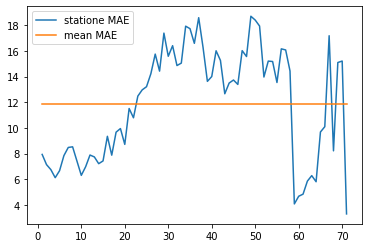

In [17]:
m = np.nanmean(score)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,score, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

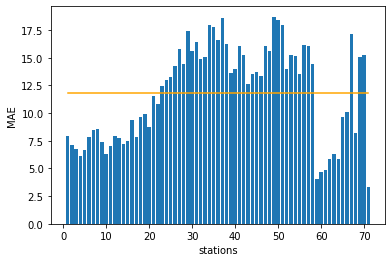

In [18]:
m = np.nanmean(score)*np.ones(71)
fig1 = plt.figure(1)
plt.bar(x,score,width=0.8)
# plt.xticks('stations')
plt.xlabel('stations')
plt.ylabel('MAE')
plt.plot(x,m, color='Orange')

plt.show()

In [ ]:
#lr=1e-1,epoch=500
score = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/jupyterNB_logs/Transformer_csv_v2/version_"+str(i)+"/metrics.csv")
    s=np.array(df['val_loss_MAE'].fillna(100))
    score[i]=np.min(s)

print(np.nanmean(score))

In [ ]:
print(score)

In [ ]:
m = np.nanmean(score)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,score, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

In [ ]:
m = np.nanmean(score)*np.ones(71)
fig1 = plt.figure(1)
plt.bar(x,score,width=0.8)
# plt.xticks('stations')
plt.xlabel('stations')
plt.ylabel('MAE')
plt.plot(x,m, color='Orange')

plt.show()

@ terminal

(base) luhung3080@luhung3080:

conda activate chou

cd /home/luhung3080/Desktop/PycharmProjects/NCHUproject/jupyterNB_logs/mymodel

tensorboard --logdir=/home/luhung3080/Desktop/PycharmProjects/NCHUproject/jupyterNB_logs/mymodel/version_3 --host=127.0.0.1